In [1]:
%reload_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from tqdm import tqdm

%aimport -plt
%aimport -np
%aimport -glob
%aimport -cv2

from os import listdir
from os.path import isfile, join

%matplotlib inline
from os import listdir
from os.path import isfile, join
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import car_detection
print(dir(car_detection))
from car_detection import log_progress
import builtins
from IPython.lib import deepreload



import csv
import sklearn
from keras_tqdm import TQDMNotebookCallback
import car_detection
import sys
sys.stdout.isatty()
from car_detection import log_progress

def show_image(img, title=''):
    fig = plt.figure(figsize=(10,100))
    plt.imshow(img)
    fig.suptitle(title) 

Using TensorFlow backend.


['Adam', 'BatchNormalization', 'Conv2D', 'Cropping2D', 'FeatureExtractor', 'Input', 'K', 'Lambda', 'MaxPooling2D', 'Model', 'ModelCheckpoint', 'Reshape', 'Undistorter', 'UpSampling2D', 'VideoFileClip', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'apply_threshold', 'bg', 'car_detection', 'clips_array', 'concatenate', 'cv2', 'dice_coef', 'dice_coef_loss', 'draw_labeled_bboxes', 'extract_hog_features', 'feature_extractor', 'fun', 'generate_heatmap', 'generate_heatmaps', 'get_hog_features', 'get_model', 'hog', 'hog_extractor', 'img_cols', 'img_rows', 'isfile', 'joblib', 'join', 'listdir', 'log_progress', 'math', 'multiprocessing', 'np', 'parmap', 'quickpool', 'sliding_window', 'smooth', 'undistorter', 'unet']


In [27]:
dataset = []

In [28]:
#Import CrowdAI dataset
my_path = 'D:\\vehicle_detection\\object-detection-crowdai'
bounding_boxs = {}
labels = [label for label in csv.DictReader(open(my_path + '\\labels.csv','r')) if label['Label'] != 'Pedestrian']

for label in labels:
    file_name = label['Frame']
    current_bounding_boxs = bounding_boxs.get(file_name, [])
    label = {
        'xmin': int(label['xmin']),
        'xmax': int(label['ymin']),
        'ymin': int(label['xmax']),
        'ymax': int(label['ymax'])    
    }
    current_bounding_boxs.append(label)
    bounding_boxs[file_name] = current_bounding_boxs
    
onlyfiles = [f for f in listdir(my_path) if isfile(join(my_path, f)) and f[-4:] == '.jpg']
    
for file_name in onlyfiles:
    boxes = bounding_boxs.get(file_name,[])
    if len(boxes) > 0:    
        dataset.append({
            'path': my_path + '\\' + file_name,
            'boxes': bounding_boxs.get(file_name,[])
        })

In [ ]:
#Import other dataset
my_path = 'D:\\vehicle_detection\\object-detection'
bounding_boxs = {}
fields = ['frame', 'xmin', 'ymin', 'xmax', 'ymax', 'occluded', 'label']
reader = csv.DictReader(open(my_path + '\\labels.csv','r'), delimiter=' ', fieldnames =fields)

labels = [label for label in reader if label['label'] in ['car', 'truck']]

for label in labels:
    file_name = label['frame']
    current_bounding_boxs = bounding_boxs.get(file_name, [])
    label = {
        'xmin': int(label['xmin']),
        'xmax': int(label['xmax']),
        'ymin': int(label['ymin']),
        'ymax': int(label['ymax'])    
    }
    current_bounding_boxs.append(label)
    bounding_boxs[file_name] = current_bounding_boxs
    
onlyfiles = [f for f in listdir(my_path) if isfile(join(my_path, f)) and f[-4:] == '.jpg']
    
for file_name in onlyfiles:
    boxes = bounding_boxs.get(file_name,[])
    if len(boxes) > 0:    
        dataset.append({
            'path': my_path + '\\' + file_name,
            'boxes': bounding_boxs.get(file_name,[])
        })

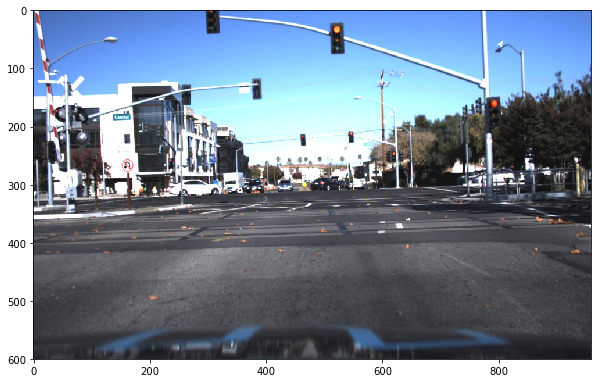

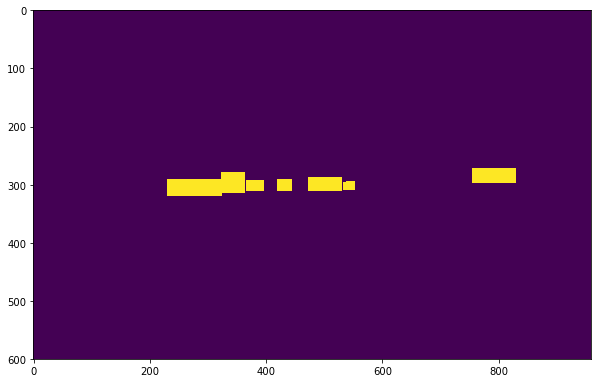

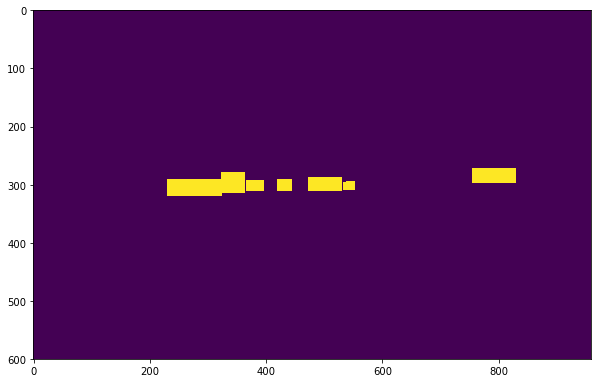

In [31]:
def load_pic(path, scale=1):
    img = cv2.imread(path)
    if scale != 1:
        new_shape = (int(img.shape[1] * scale), int(img.shape[0] * scale))
        img = cv2.resize(img, new_shape)
    if img is not None:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return None

def build_mask(bounding_boxs,size=(1200.0,1920.0), scale=1.0):
    mask = np.zeros((int(size[0]*scale), int(size[1]*scale)), dtype=np.uint8)
    for box in bounding_boxs:
        xmin = int(box['xmin'] * scale)
        xmax = int(box['xmax'] * scale)
        ymin = int(box['ymin'] * scale)
        ymax = int(box['ymax'] * scale)       
        mask[ymin:ymax,xmin:xmax] = 1
    return mask

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

mask = build_mask(dataset[100]['boxes'], scale=0.5)
pic = load_pic(dataset[100]['path'], scale=0.5)
show_image(pic)
show_image(mask)
show_image(mask)



In [2]:
import car_detection
model = car_detection.get_model()
model.load_weights("./tmp/weights__3.14--0.78.hdf5")
print("test")

(?, 600, 960, 3)
(?, 600, 960, 32)
(?, 300, 480, 32)
(?, 150, 240, 64)
(?, 75, 120, 128)
(?, 38, 60, 256)
(?, 600, 960, 1)
(?, 600, 960)
test


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

dataset = shuffle(dataset)
training_set, test_set = train_test_split(dataset, test_size=0.3)
training_set, validation_set = train_test_split(training_set, test_size=0.1)
#training_set = training_set[0:10]
#validation_set = validation_set[0:50]
def myGenerator(dataset):
    #loading data
    while True:
        for i in range(len(dataset)):
            pic = load_pic(dataset[i]['path'], scale=0.5)
            
            mask = build_mask(dataset[i]['boxes'], scale=0.5)
            result = [np.array([pic]), np.array([mask])]

            yield result
training_generator = myGenerator(training_set)
validating_generator = myGenerator(validation_set)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="./tmp/weights__3.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1)
model.fit_generator(training_generator, 
                    steps_per_epoch=len(training_set), 
                    epochs=15, 
                    verbose=0,
                    validation_data=validating_generator, 
                    validation_steps=len(validation_set), 
                    callbacks=[checkpointer,TQDMNotebookCallback()])


In [ ]:
show_image(build_mask(test_set[0]['boxes'], scale=0.5))

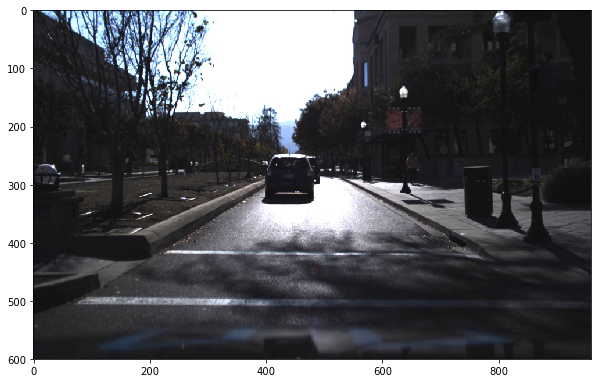

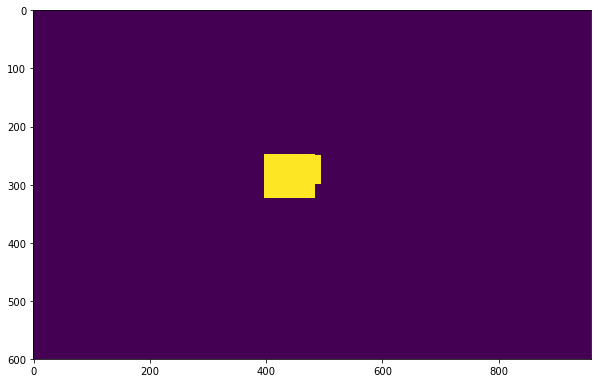

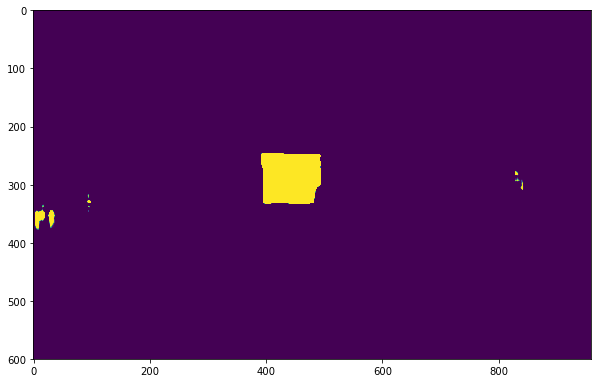

In [33]:
datapoint = test_set[11]
test_pic = load_pic(datapoint['path'], scale=0.5)
prediction = model.predict(np.array([test_pic]))[0]
mask = build_mask(datapoint['boxes'], scale=0.5)
show_image(test_pic)
show_image(mask)
show_image(prediction)

In [23]:
heatmaps = []
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
#         bbox = ((np.min(nonzerox), np.min(nonzeroy)), 
#                  np.max(nonzerox) - np.min(nonzerox),
#                  np.max(nonzeroy) - np.min(nonzeroy))
#         bbox = [np.min(nonzerox), np.min(nonzeroy), 
#                  np.max(nonzerox) - np.min(nonzerox),
#                  np.max(nonzeroy) - np.min(nonzeroy)]
        bboxes.append(bbox)
    #bboxes = cv2.groupRectangles(list(bboxes),1)
        
        
    for bbox in bboxes:#combine_rectangles(bboxes):
        # Draw the box on the image
        width =  bbox[0][0] - bbox[1][0]
        height = bbox[0][1] - bbox[1][1]
        area = width * height
        if area > 300:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def point_in_rectangle(rectangle, point):
    #Rectangle should be two points

    if rectangle[0][0] < point[0] and point[0] < rectangle[1][0]:
        if rectangle[0][1] < point[1] and point[1] < rectangle[1][1]:
            return True
    return False
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def in_other_rect(rect_inner,rect_outer):
    points = [
        rect_outer[0],
        rect_outer[1],
        (rect_outer[1][0], rect_outer[0][1]),
        (rect_outer[0][1], rect_outer[1][1])
    ]
    for point in points:
        if point_in_rectangle(rect_inner, point):
            return True
    return False
        
def combine_rectangles(rects): 
    outer_rects=[rects[:]]
    for rect_inner in rects:
        for rect_outer in rects:
            if(in_other_rect(rect_inner,rect_outer)):
                if rect_inner in outer_rects:
                    outer_rects.remove(rect_inner)
    return outer_rects[0]

def get_find_cars_func(heatmap_shortcircuit=False, raw_shortcircuit=False):
    def find_cars_func(img):
        global heatmaps
        img = cv2.resize(img,(960, 600), interpolation = cv2.INTER_CUBIC)
        draw_img = img.copy()
        heatmap = model.predict(np.array([draw_img]))[0]
        
        if heatmap_shortcircuit == True:
            print(heatmap.shape)
            output = np.stack((heatmap*255,heatmap*255,heatmap*255),axis=2)
            print(output.shape)
            return output
        heatmaps.append(heatmap * 60)
        heatmap = np.array(np.mean(heatmaps, axis=(0)), dtype=np.uint8)
        #heatmap = np.mean(heatmaps).astype(np.int32)
        heatmaps = heatmaps[-10:]
        orig_heat = heatmap.copy()
        heatmap = apply_threshold(heatmap, 55)
        labels = label(heatmap)
        
        if raw_shortcircuit == True:
            hm = heatmap*(255/np.max(heatmap))
            hm = np.stack((hm,hm,hm),axis=2)
            hm = draw_labeled_bboxes(hm, labels)
            draw_img = draw_labeled_bboxes(draw_img, labels)
            
            h20 = apply_threshold(orig_heat.copy(), 20)
            
            h30 = apply_threshold(orig_heat.copy(), 30)
            
            h40 = apply_threshold(orig_heat.copy(), 40)

            
            orig_heat = np.stack((h20,h30,h40),axis=2)

            print(hm.shape)
            print(hm.shape)
            print(hm.shape)
            
            return np.concatenate((img, hm, orig_heat), axis=1)

            #return np.stack((img,hm),axis=0)
        return draw_labeled_bboxes(draw_img, labels)
    return find_cars_func

In [24]:
from moviepy.editor import VideoFileClip, clips_array

def run_video(input, output):
    print(input)
    find_cars_func = get_find_cars_func(heatmap_shortcircuit=True)
    clip1 = VideoFileClip(input)
    result_clip = clip1.fl_image(find_cars_func)
    %time result_clip.write_videofile(output, audio=False)
    del result_clip

    find_cars_func = get_find_cars_func(heatmap_shortcircuit=False)
    clip1 = VideoFileClip(input)
    result_clip = clip1.fl_image(find_cars_func)
    %time result_clip.write_videofile("otherone_{0}".format(output), audio=False)
    del result_clip
    
def run_test_video(input, output):
    print(input)
    find_cars_func = get_find_cars_func(raw_shortcircuit=False)
    clip1 = VideoFileClip(input)#.subclip(28.0,33.0)
    result_clip = clip1.fl_image(find_cars_func)
    %time result_clip.write_videofile(output, audio=False)
    del result_clip

    
input = './project_video.mp4'
output = './project_video_outcome.mp4'
try:
    #run_video(input, output)
    run_test_video(input, output)
except Exception as e: 
    raise e

./project_video.mp4
[((242, 356), (317, 405)), ((316, 358), (340, 383)), ((308, 373), (311, 374))]
((242, 356), (317, 405))
3675
((316, 358), (340, 383))
600
((308, 373), (311, 374))
3
[MoviePy] >>>> Building video ./project_video_outcome.mp4
[MoviePy] Writing video ./project_video_outcome.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

[((242, 356), (317, 405)), ((316, 358), (340, 383)), ((308, 373), (311, 374))]
((242, 356), (317, 405))
3675
((316, 358), (340, 383))
600
((308, 373), (311, 374))
3


  0%|                                                                                 | 1/1261 [00:00<02:19,  9.01it/s]

[((242, 356), (317, 405)), ((316, 368), (324, 376)), ((309, 373), (312, 374))]
((242, 356), (317, 405))
3675
((316, 368), (324, 376))
64
((309, 373), (312, 374))
3


  0%|▏                                                                                | 2/1261 [00:00<02:22,  8.82it/s]

[((242, 356), (316, 405)), ((309, 373), (312, 374))]
((242, 356), (316, 405))
3626
((309, 373), (312, 374))
3


  0%|▏                                                                                | 3/1261 [00:00<02:22,  8.82it/s]

[((242, 365), (260, 370))]
((242, 365), (260, 370))
90


  0%|▎                                                                                | 4/1261 [00:00<02:20,  8.95it/s]

[((242, 365), (260, 370))]
((242, 365), (260, 370))
90


  0%|▎                                                                                | 5/1261 [00:00<02:18,  9.04it/s]

[((252, 365), (260, 369)), ((242, 367), (244, 369))]
((252, 365), (260, 369))
32
((242, 367), (244, 369))
4


  0%|▍                                                                                | 6/1261 [00:00<02:20,  8.91it/s]

[]


  1%|▍                                                                                | 7/1261 [00:00<02:16,  9.18it/s]

[]


  1%|▌                                                                                | 8/1261 [00:00<02:15,  9.28it/s]

[]


  1%|▌                                                                                | 9/1261 [00:00<02:14,  9.31it/s]

[]


  1%|▋                                                                               | 10/1261 [00:01<02:14,  9.31it/s]

[]


  1%|▋                                                                               | 11/1261 [00:01<02:14,  9.29it/s]

[]


  1%|▊                                                                               | 12/1261 [00:01<02:13,  9.33it/s]

[]


  1%|▊                                                                               | 13/1261 [00:01<02:14,  9.31it/s]

[]


  1%|▉                                                                               | 14/1261 [00:01<02:13,  9.32it/s]

[]


  1%|▉                                                                               | 15/1261 [00:01<02:14,  9.29it/s]

[]


  1%|█                                                                               | 16/1261 [00:01<02:15,  9.18it/s]

[]


  1%|█                                                                               | 17/1261 [00:01<02:14,  9.22it/s]

[]


  1%|█▏                                                                              | 18/1261 [00:01<02:14,  9.26it/s]

[]


  2%|█▏                                                                              | 19/1261 [00:02<02:13,  9.29it/s]

[]


  2%|█▎                                                                              | 20/1261 [00:02<02:13,  9.32it/s]

[]


  2%|█▎                                                                              | 21/1261 [00:02<02:13,  9.28it/s]

[]


  2%|█▍                                                                              | 22/1261 [00:02<02:14,  9.22it/s]

[]


  2%|█▍                                                                              | 23/1261 [00:02<02:14,  9.20it/s]

[]


  2%|█▌                                                                              | 24/1261 [00:02<02:13,  9.26it/s]

[]


  2%|█▌                                                                              | 25/1261 [00:02<02:13,  9.28it/s]

[]


  2%|█▋                                                                              | 26/1261 [00:02<02:13,  9.27it/s]

[]


  2%|█▋                                                                              | 27/1261 [00:02<02:13,  9.22it/s]

[]


  2%|█▊                                                                              | 28/1261 [00:03<02:13,  9.21it/s]

[]


  2%|█▊                                                                              | 29/1261 [00:03<02:14,  9.18it/s]

[]


  2%|█▉                                                                              | 30/1261 [00:03<02:13,  9.23it/s]

[]


  2%|█▉                                                                              | 31/1261 [00:03<02:13,  9.24it/s]

[]


  3%|██                                                                              | 32/1261 [00:03<02:12,  9.26it/s]

[]


  3%|██                                                                              | 33/1261 [00:03<02:12,  9.24it/s]

[]


  3%|██▏                                                                             | 34/1261 [00:03<02:12,  9.24it/s]

[]


  3%|██▏                                                                             | 35/1261 [00:03<02:12,  9.25it/s]

[]


  3%|██▎                                                                             | 36/1261 [00:03<02:12,  9.22it/s]

[]


  3%|██▎                                                                             | 37/1261 [00:04<02:13,  9.16it/s]

[]


  3%|██▍                                                                             | 38/1261 [00:04<02:12,  9.24it/s]

[]


  3%|██▍                                                                             | 39/1261 [00:04<02:12,  9.24it/s]

[]


  3%|██▌                                                                             | 40/1261 [00:04<02:12,  9.22it/s]

[]


  3%|██▌                                                                             | 41/1261 [00:04<02:12,  9.23it/s]

[]


  3%|██▋                                                                             | 42/1261 [00:04<02:11,  9.30it/s]

[]


  3%|██▋                                                                             | 43/1261 [00:04<02:10,  9.36it/s]

[]


  3%|██▊                                                                             | 44/1261 [00:04<02:09,  9.37it/s]

[]


  4%|██▊                                                                             | 45/1261 [00:04<02:09,  9.39it/s]

[]


  4%|██▉                                                                             | 46/1261 [00:04<02:09,  9.35it/s]

[]


  4%|██▉                                                                             | 47/1261 [00:05<02:08,  9.42it/s]

[]


  4%|███                                                                             | 48/1261 [00:05<02:09,  9.39it/s]

[]


  4%|███                                                                             | 49/1261 [00:05<02:09,  9.38it/s]

[]


  4%|███▏                                                                            | 50/1261 [00:05<02:12,  9.16it/s]

[]


  4%|███▏                                                                            | 51/1261 [00:05<02:11,  9.19it/s]

[]


  4%|███▎                                                                            | 52/1261 [00:05<02:10,  9.26it/s]

[]


  4%|███▎                                                                            | 53/1261 [00:05<02:10,  9.27it/s]

[]


  4%|███▍                                                                            | 54/1261 [00:05<02:09,  9.31it/s]

[]


  4%|███▍                                                                            | 55/1261 [00:05<02:09,  9.29it/s]

[]


  4%|███▌                                                                            | 56/1261 [00:06<02:09,  9.29it/s]

[]


  5%|███▌                                                                            | 57/1261 [00:06<02:09,  9.28it/s]

[]


  5%|███▋                                                                            | 58/1261 [00:06<02:09,  9.26it/s]

[]


  5%|███▋                                                                            | 59/1261 [00:06<02:09,  9.26it/s]

[]


  5%|███▊                                                                            | 60/1261 [00:06<02:09,  9.31it/s]

[]


  5%|███▊                                                                            | 61/1261 [00:06<02:09,  9.27it/s]

[]


  5%|███▉                                                                            | 62/1261 [00:06<02:09,  9.29it/s]

[]


  5%|███▉                                                                            | 63/1261 [00:06<02:08,  9.33it/s]

[]


  5%|████                                                                            | 64/1261 [00:06<02:09,  9.26it/s]

[]


  5%|████                                                                            | 65/1261 [00:07<02:08,  9.31it/s]

[]


  5%|████▏                                                                           | 66/1261 [00:07<02:07,  9.38it/s]

[]


  5%|████▎                                                                           | 67/1261 [00:07<02:07,  9.38it/s]

[]


  5%|████▎                                                                           | 68/1261 [00:07<02:07,  9.34it/s]

[]


  5%|████▍                                                                           | 69/1261 [00:07<02:07,  9.37it/s]

[]


  6%|████▍                                                                           | 70/1261 [00:07<02:07,  9.34it/s]

[]


  6%|████▌                                                                           | 71/1261 [00:07<02:07,  9.37it/s]

[]


  6%|████▌                                                                           | 72/1261 [00:07<02:07,  9.34it/s]

[]


  6%|████▋                                                                           | 73/1261 [00:07<02:07,  9.29it/s]

[]


  6%|████▋                                                                           | 74/1261 [00:07<02:07,  9.34it/s]

[]


  6%|████▊                                                                           | 75/1261 [00:08<02:06,  9.34it/s]

[]


  6%|████▊                                                                           | 76/1261 [00:08<02:06,  9.35it/s]

[]


  6%|████▉                                                                           | 77/1261 [00:08<02:08,  9.23it/s]

[]


  6%|████▉                                                                           | 78/1261 [00:08<02:07,  9.30it/s]

[]


  6%|█████                                                                           | 79/1261 [00:08<02:06,  9.33it/s]

[]


  6%|█████                                                                           | 80/1261 [00:08<02:06,  9.33it/s]

[]


  6%|█████▏                                                                          | 81/1261 [00:08<02:06,  9.31it/s]

[]


  7%|█████▏                                                                          | 82/1261 [00:08<02:06,  9.32it/s]

[]


  7%|█████▎                                                                          | 83/1261 [00:08<02:08,  9.16it/s]

[]


  7%|█████▎                                                                          | 84/1261 [00:09<02:09,  9.07it/s]

[]


  7%|█████▍                                                                          | 85/1261 [00:09<02:09,  9.10it/s]

[]


  7%|█████▍                                                                          | 86/1261 [00:09<02:07,  9.25it/s]

[]


  7%|█████▌                                                                          | 87/1261 [00:09<02:06,  9.25it/s]

[]


  7%|█████▌                                                                          | 88/1261 [00:09<02:06,  9.30it/s]

[]


  7%|█████▋                                                                          | 89/1261 [00:09<02:05,  9.34it/s]

[]


  7%|█████▋                                                                          | 90/1261 [00:09<02:05,  9.37it/s]

[]


  7%|█████▊                                                                          | 91/1261 [00:09<02:04,  9.39it/s]

[]


  7%|█████▊                                                                          | 92/1261 [00:09<02:04,  9.37it/s]

[]


  7%|█████▉                                                                          | 93/1261 [00:10<02:04,  9.36it/s]

[]


  7%|█████▉                                                                          | 94/1261 [00:10<02:04,  9.36it/s]

[]


  8%|██████                                                                          | 95/1261 [00:10<02:04,  9.35it/s]

[((235, 362), (260, 370))]
((235, 362), (260, 370))
200


  8%|██████                                                                          | 96/1261 [00:10<02:08,  9.07it/s]

[((235, 363), (260, 370)), ((265, 364), (277, 367))]
((235, 363), (260, 370))
175
((265, 364), (277, 367))
36


  8%|██████▏                                                                         | 97/1261 [00:10<02:13,  8.70it/s]

[((235, 364), (260, 370)), ((265, 364), (277, 367))]
((235, 364), (260, 370))
150
((265, 364), (277, 367))
36


  8%|██████▏                                                                         | 98/1261 [00:10<02:18,  8.41it/s]

[((418, 352), (428, 355)), ((235, 364), (241, 367)), ((245, 364), (260, 370)), ((265, 364), (277, 367))]
((418, 352), (428, 355))
30
((235, 364), (241, 367))
18
((245, 364), (260, 370))
90
((265, 364), (277, 367))
36


  8%|██████▎                                                                         | 99/1261 [00:10<02:23,  8.08it/s]

[((238, 350), (238, 350)), ((416, 352), (419, 355)), ((424, 352), (428, 353)), ((232, 356), (236, 358)), ((232, 364), (237, 365)), ((249, 364), (260, 370)), ((265, 364), (277, 367))]
((238, 350), (238, 350))
0
((416, 352), (419, 355))
9
((424, 352), (428, 353))
4
((232, 356), (236, 358))
8
((232, 364), (237, 365))
5
((249, 364), (260, 370))
66
((265, 364), (277, 367))
36


  8%|██████▎                                                                        | 100/1261 [00:10<02:36,  7.43it/s]

[((224, 349), (231, 366)), ((276, 355), (278, 357)), ((285, 355), (287, 355)), ((264, 363), (279, 369)), ((249, 364), (260, 370))]
((224, 349), (231, 366))
119
((276, 355), (278, 357))
4
((285, 355), (287, 355))
0
((264, 363), (279, 369))
90
((249, 364), (260, 370))
66


  8%|██████▎                                                                        | 101/1261 [00:11<02:38,  7.30it/s]

[((222, 348), (231, 365)), ((284, 352), (294, 355)), ((276, 355), (278, 357)), ((227, 356), (230, 359)), ((249, 363), (279, 370))]
((222, 348), (231, 365))
153
((284, 352), (294, 355))
30
((276, 355), (278, 357))
4
((227, 356), (230, 359))
9
((249, 363), (279, 370))
210


  8%|██████▍                                                                        | 102/1261 [00:11<02:41,  7.19it/s]

[((284, 353), (287, 355)), ((273, 355), (278, 357)), ((270, 356), (272, 357)), ((249, 363), (279, 370))]
((284, 353), (287, 355))
6
((273, 355), (278, 357))
10
((270, 356), (272, 357))
2
((249, 363), (279, 370))
210


  8%|██████▍                                                                        | 103/1261 [00:11<02:40,  7.22it/s]

[((216, 349), (216, 351)), ((269, 355), (273, 358)), ((275, 355), (280, 358)), ((281, 356), (281, 356)), ((249, 363), (289, 371)), ((269, 397), (273, 399))]
((216, 349), (216, 351))
0
((269, 355), (273, 358))
12
((275, 355), (280, 358))
15
((281, 356), (281, 356))
0
((249, 363), (289, 371))
320
((269, 397), (273, 399))
8


  8%|██████▌                                                                        | 104/1261 [00:11<02:44,  7.03it/s]

[((269, 355), (272, 358)), ((275, 355), (280, 358)), ((281, 356), (281, 356)), ((286, 357), (286, 357)), ((287, 358), (287, 358)), ((249, 363), (291, 371)), ((269, 376), (291, 409))]
((269, 355), (272, 358))
9
((275, 355), (280, 358))
15
((281, 356), (281, 356))
0
((286, 357), (286, 357))
0
((287, 358), (287, 358))
0
((249, 363), (291, 371))
336
((269, 376), (291, 409))
726


  8%|██████▌                                                                        | 105/1261 [00:11<02:50,  6.80it/s]

[((208, 351), (209, 355)), ((277, 356), (280, 358)), ((281, 356), (281, 356)), ((260, 363), (276, 371)), ((285, 377), (288, 378)), ((272, 388), (273, 390))]
((208, 351), (209, 355))
4
((277, 356), (280, 358))
6
((281, 356), (281, 356))
0
((260, 363), (276, 371))
128
((285, 377), (288, 378))
3
((272, 388), (273, 390))
2


  8%|██████▋                                                                        | 106/1261 [00:11<02:51,  6.75it/s]

[((205, 350), (209, 355)), ((277, 356), (280, 358)), ((281, 356), (281, 356)), ((260, 363), (276, 371)), ((285, 377), (288, 378)), ((272, 388), (273, 390))]
((205, 350), (209, 355))
20
((277, 356), (280, 358))
6
((281, 356), (281, 356))
0
((260, 363), (276, 371))
128
((285, 377), (288, 378))
3
((272, 388), (273, 390))
2


  8%|██████▋                                                                        | 107/1261 [00:11<02:51,  6.73it/s]

[((204, 350), (209, 356)), ((203, 361), (204, 361)), ((260, 364), (269, 369))]
((204, 350), (209, 356))
30
((203, 361), (204, 361))
0
((260, 364), (269, 369))
45


  9%|██████▊                                                                        | 108/1261 [00:12<02:44,  7.00it/s]

[((204, 350), (208, 356)), ((203, 361), (204, 361)), ((260, 364), (269, 369))]
((204, 350), (208, 356))
24
((203, 361), (204, 361))
0
((260, 364), (269, 369))
45


  9%|██████▊                                                                        | 109/1261 [00:12<02:41,  7.14it/s]

[((203, 361), (203, 361)), ((260, 364), (269, 367))]
((203, 361), (203, 361))
0
((260, 364), (269, 367))
27


  9%|██████▉                                                                        | 110/1261 [00:12<02:34,  7.43it/s]

[((260, 364), (269, 367))]
((260, 364), (269, 367))
27


  9%|██████▉                                                                        | 111/1261 [00:12<02:27,  7.79it/s]

[((260, 364), (264, 366))]
((260, 364), (264, 366))
8


  9%|███████                                                                        | 112/1261 [00:12<02:23,  8.02it/s]

[((260, 365), (260, 366))]
((260, 365), (260, 366))
0


  9%|███████                                                                        | 113/1261 [00:12<02:18,  8.27it/s]

[((260, 365), (260, 366))]
((260, 365), (260, 366))
0


  9%|███████▏                                                                       | 114/1261 [00:12<02:16,  8.39it/s]

[]


  9%|███████▏                                                                       | 115/1261 [00:12<02:12,  8.66it/s]

[]


  9%|███████▎                                                                       | 116/1261 [00:13<02:09,  8.83it/s]

[((245, 365), (259, 369))]
((245, 365), (259, 369))
56


  9%|███████▎                                                                       | 117/1261 [00:13<02:10,  8.75it/s]

[((245, 365), (251, 368)), ((256, 365), (259, 366))]
((245, 365), (251, 368))
18
((256, 365), (259, 366))
3


  9%|███████▍                                                                       | 118/1261 [00:13<02:13,  8.58it/s]

[((245, 365), (246, 368))]
((245, 365), (246, 368))
3


  9%|███████▍                                                                       | 119/1261 [00:13<02:12,  8.64it/s]

[((245, 365), (245, 367))]
((245, 365), (245, 367))
0


 10%|███████▌                                                                       | 120/1261 [00:13<02:12,  8.64it/s]

[]


 10%|███████▌                                                                       | 121/1261 [00:13<02:09,  8.80it/s]

[]


 10%|███████▋                                                                       | 122/1261 [00:13<02:07,  8.93it/s]

[]


 10%|███████▋                                                                       | 123/1261 [00:13<02:05,  9.05it/s]

[]


 10%|███████▊                                                                       | 124/1261 [00:13<02:04,  9.13it/s]

[]


 10%|███████▊                                                                       | 125/1261 [00:14<02:03,  9.19it/s]

[]


 10%|███████▉                                                                       | 126/1261 [00:14<02:02,  9.24it/s]

[]


 10%|███████▉                                                                       | 127/1261 [00:14<02:02,  9.29it/s]

[((937, 383), (938, 391)), ((937, 394), (938, 396)), ((949, 412), (950, 413)), ((935, 422), (949, 435)), ((947, 424), (947, 427)), ((937, 450), (937, 451))]
((937, 383), (938, 391))
8
((937, 394), (938, 396))
2
((949, 412), (950, 413))
1
((935, 422), (949, 435))
182
((947, 424), (947, 427))
0
((937, 450), (937, 451))
0


 10%|████████                                                                       | 128/1261 [00:14<02:16,  8.29it/s]

[((958, 348), (958, 354)), ((933, 360), (940, 397)), ((949, 366), (950, 370)), ((948, 384), (953, 404)), ((957, 389), (957, 389)), ((957, 391), (957, 393)), ((956, 394), (956, 395)), ((939, 399), (942, 405)), ((949, 409), (950, 413)), ((932, 422), (954, 457))]
((958, 348), (958, 354))
0
((933, 360), (940, 397))
259
((949, 366), (950, 370))
4
((948, 384), (953, 404))
100
((957, 389), (957, 389))
0
((957, 391), (957, 393))
0
((956, 394), (956, 395))
0
((939, 399), (942, 405))
18
((949, 409), (950, 413))
4
((932, 422), (954, 457))
770


 10%|████████                                                                       | 129/1261 [00:14<02:37,  7.21it/s]

[((931, 350), (959, 405)), ((949, 409), (950, 413)), ((930, 422), (954, 458))]
((931, 350), (959, 405))
1540
((949, 409), (950, 413))
4
((930, 422), (954, 458))
864


 10%|████████▏                                                                      | 130/1261 [00:14<02:34,  7.33it/s]

[((928, 348), (959, 405)), ((949, 409), (950, 413)), ((930, 418), (930, 419)), ((929, 422), (954, 458))]
((928, 348), (959, 405))
1767
((949, 409), (950, 413))
4
((930, 418), (930, 419))
0
((929, 422), (954, 458))
900


 10%|████████▏                                                                      | 131/1261 [00:14<02:34,  7.33it/s]

[((925, 353), (959, 405)), ((949, 409), (950, 413)), ((930, 418), (930, 419)), ((924, 422), (955, 451))]
((925, 353), (959, 405))
1768
((949, 409), (950, 413))
4
((930, 418), (930, 419))
0
((924, 422), (955, 451))
899


 10%|████████▎                                                                      | 132/1261 [00:14<02:34,  7.30it/s]

[((924, 353), (959, 405)), ((949, 409), (950, 413)), ((930, 418), (930, 419)), ((921, 422), (955, 451))]
((924, 353), (959, 405))
1820
((949, 409), (950, 413))
4
((930, 418), (930, 419))
0
((921, 422), (955, 451))
986


 11%|████████▎                                                                      | 133/1261 [00:15<02:34,  7.30it/s]

[((919, 353), (959, 451))]
((919, 353), (959, 451))
3920


 11%|████████▍                                                                      | 134/1261 [00:15<02:26,  7.69it/s]

[((917, 353), (959, 451)), ((920, 457), (921, 457))]
((917, 353), (959, 451))
4116
((920, 457), (921, 457))
0


 11%|████████▍                                                                      | 135/1261 [00:15<02:23,  7.85it/s]

[((913, 353), (959, 453)), ((917, 457), (921, 457))]
((913, 353), (959, 453))
4600
((917, 457), (921, 457))
0


 11%|████████▌                                                                      | 136/1261 [00:15<02:22,  7.91it/s]

[((912, 353), (959, 451)), ((917, 457), (919, 457))]
((912, 353), (959, 451))
4606
((917, 457), (919, 457))
0


 11%|████████▌                                                                      | 137/1261 [00:15<02:20,  8.01it/s]

[((910, 353), (959, 443))]
((910, 353), (959, 443))
4410


 11%|████████▋                                                                      | 138/1261 [00:15<02:16,  8.24it/s]

[((906, 353), (959, 450))]
((906, 353), (959, 450))
5141


 11%|████████▋                                                                      | 139/1261 [00:15<02:14,  8.37it/s]

[((904, 353), (959, 448)), ((907, 449), (907, 450))]
((904, 353), (959, 448))
5225
((907, 449), (907, 450))
0


 11%|████████▊                                                                      | 140/1261 [00:15<02:15,  8.30it/s]

[((903, 353), (959, 451))]
((903, 353), (959, 451))
5488


 11%|████████▊                                                                      | 141/1261 [00:16<02:12,  8.43it/s]

[((902, 353), (959, 449))]
((902, 353), (959, 449))
5472


 11%|████████▉                                                                      | 142/1261 [00:16<02:11,  8.51it/s]

[((896, 352), (959, 445))]
((896, 352), (959, 445))
5859


 11%|████████▉                                                                      | 143/1261 [00:16<02:11,  8.53it/s]

[((893, 352), (959, 445))]
((893, 352), (959, 445))
6138


 11%|█████████                                                                      | 144/1261 [00:16<02:09,  8.61it/s]

[((892, 343), (959, 444))]
((892, 343), (959, 444))
6767


 11%|█████████                                                                      | 145/1261 [00:16<02:09,  8.61it/s]

[((892, 342), (959, 443))]
((892, 342), (959, 443))
6767


 12%|█████████▏                                                                     | 146/1261 [00:16<02:10,  8.55it/s]

[((890, 340), (959, 443))]
((890, 340), (959, 443))
7107


 12%|█████████▏                                                                     | 147/1261 [00:16<02:09,  8.57it/s]

[((888, 339), (959, 445))]
((888, 339), (959, 445))
7526


 12%|█████████▎                                                                     | 148/1261 [00:16<02:09,  8.63it/s]

[((885, 339), (959, 444))]
((885, 339), (959, 444))
7770


 12%|█████████▎                                                                     | 149/1261 [00:16<02:08,  8.65it/s]

[((883, 336), (959, 445))]
((883, 336), (959, 445))
8284


 12%|█████████▍                                                                     | 150/1261 [00:17<02:08,  8.67it/s]

[((880, 333), (959, 445))]
((880, 333), (959, 445))
8848


 12%|█████████▍                                                                     | 151/1261 [00:17<02:07,  8.70it/s]

[((878, 332), (959, 445))]
((878, 332), (959, 445))
9153


 12%|█████████▌                                                                     | 152/1261 [00:17<02:07,  8.70it/s]

[((876, 332), (959, 445))]
((876, 332), (959, 445))
9379


 12%|█████████▌                                                                     | 153/1261 [00:17<02:07,  8.72it/s]

[((875, 332), (959, 445))]
((875, 332), (959, 445))
9492


 12%|█████████▋                                                                     | 154/1261 [00:17<02:06,  8.74it/s]

[((872, 331), (959, 444))]
((872, 331), (959, 444))
9831


 12%|█████████▋                                                                     | 155/1261 [00:17<02:06,  8.71it/s]

[((870, 331), (959, 443))]
((870, 331), (959, 443))
9968


 12%|█████████▊                                                                     | 156/1261 [00:17<02:07,  8.68it/s]

[((869, 330), (959, 440))]
((869, 330), (959, 440))
9900


 12%|█████████▊                                                                     | 157/1261 [00:17<02:07,  8.68it/s]

[((869, 330), (959, 440))]
((869, 330), (959, 440))
9900


 13%|█████████▉                                                                     | 158/1261 [00:18<02:08,  8.60it/s]

[((867, 331), (959, 440))]
((867, 331), (959, 440))
10028


 13%|█████████▉                                                                     | 159/1261 [00:18<02:08,  8.60it/s]

[((864, 331), (959, 440))]
((864, 331), (959, 440))
10355


 13%|██████████                                                                     | 160/1261 [00:18<02:07,  8.61it/s]

[((864, 331), (959, 440))]
((864, 331), (959, 440))
10355


 13%|██████████                                                                     | 161/1261 [00:18<02:09,  8.53it/s]

[((863, 331), (959, 440))]
((863, 331), (959, 440))
10464


 13%|██████████▏                                                                    | 162/1261 [00:18<02:08,  8.56it/s]

[((861, 331), (959, 440))]
((861, 331), (959, 440))
10682


 13%|██████████▏                                                                    | 163/1261 [00:18<02:07,  8.58it/s]

[((857, 331), (959, 440))]
((857, 331), (959, 440))
11118


 13%|██████████▎                                                                    | 164/1261 [00:18<02:07,  8.59it/s]

[((855, 331), (959, 440))]
((855, 331), (959, 440))
11336


 13%|██████████▎                                                                    | 165/1261 [00:18<02:07,  8.60it/s]

[((854, 331), (959, 440))]
((854, 331), (959, 440))
11445


 13%|██████████▍                                                                    | 166/1261 [00:18<02:07,  8.61it/s]

[((852, 331), (959, 440))]
((852, 331), (959, 440))
11663


 13%|██████████▍                                                                    | 167/1261 [00:19<02:06,  8.63it/s]

[((849, 331), (959, 442))]
((849, 331), (959, 442))
12210


 13%|██████████▌                                                                    | 168/1261 [00:19<02:06,  8.62it/s]

[((849, 331), (959, 442))]
((849, 331), (959, 442))
12210


 13%|██████████▌                                                                    | 169/1261 [00:19<02:06,  8.67it/s]

[((847, 330), (959, 440))]
((847, 330), (959, 440))
12320


 13%|██████████▋                                                                    | 170/1261 [00:19<02:05,  8.70it/s]

[((844, 330), (959, 437))]
((844, 330), (959, 437))
12305


 14%|██████████▋                                                                    | 171/1261 [00:19<02:05,  8.70it/s]

[((841, 330), (959, 437))]
((841, 330), (959, 437))
12626


 14%|██████████▊                                                                    | 172/1261 [00:19<02:04,  8.74it/s]

[((840, 330), (959, 437))]
((840, 330), (959, 437))
12733


 14%|██████████▊                                                                    | 173/1261 [00:19<02:04,  8.72it/s]

[((840, 330), (959, 437)), ((388, 381), (390, 382)), ((381, 382), (383, 385))]
((840, 330), (959, 437))
12733
((388, 381), (390, 382))
2
((381, 382), (383, 385))
6


 14%|██████████▉                                                                    | 174/1261 [00:19<02:09,  8.38it/s]

[((837, 330), (959, 438)), ((380, 381), (391, 386)), ((955, 441), (955, 441))]
((837, 330), (959, 438))
13176
((380, 381), (391, 386))
55
((955, 441), (955, 441))
0


 14%|██████████▉                                                                    | 175/1261 [00:20<02:15,  8.01it/s]

[((837, 330), (959, 438)), ((380, 381), (391, 386)), ((955, 441), (955, 441))]
((837, 330), (959, 438))
13176
((380, 381), (391, 386))
55
((955, 441), (955, 441))
0


 14%|███████████                                                                    | 176/1261 [00:20<02:17,  7.91it/s]

[((834, 330), (959, 442)), ((364, 349), (378, 354)), ((377, 373), (378, 373)), ((358, 380), (391, 386))]
((834, 330), (959, 442))
14000
((364, 349), (378, 354))
70
((377, 373), (378, 373))
0
((358, 380), (391, 386))
198


 14%|███████████                                                                    | 177/1261 [00:20<02:20,  7.72it/s]

[((833, 329), (959, 441)), ((364, 349), (378, 354)), ((377, 373), (378, 373)), ((358, 380), (391, 386))]
((833, 329), (959, 441))
14112
((364, 349), (378, 354))
70
((377, 373), (378, 373))
0
((358, 380), (391, 386))
198


 14%|███████████▏                                                                   | 178/1261 [00:20<02:22,  7.60it/s]

[((832, 329), (959, 440)), ((364, 349), (378, 354)), ((377, 373), (378, 373)), ((358, 380), (391, 386))]
((832, 329), (959, 440))
14097
((364, 349), (378, 354))
70
((377, 373), (378, 373))
0
((358, 380), (391, 386))
198


 14%|███████████▏                                                                   | 179/1261 [00:20<02:23,  7.56it/s]

[((830, 329), (959, 440)), ((348, 336), (392, 387)), ((350, 338), (351, 338))]
((830, 329), (959, 440))
14319
((348, 336), (392, 387))
2244
((350, 338), (351, 338))
0


 14%|███████████▎                                                                   | 180/1261 [00:20<02:22,  7.58it/s]

[((829, 329), (959, 440)), ((328, 336), (392, 397)), ((382, 400), (384, 401))]
((829, 329), (959, 440))
14430
((328, 336), (392, 397))
3904
((382, 400), (384, 401))
2


 14%|███████████▎                                                                   | 181/1261 [00:20<02:21,  7.65it/s]

[((827, 328), (959, 440)), ((328, 336), (392, 402)), ((382, 409), (385, 410))]
((827, 328), (959, 440))
14784
((328, 336), (392, 402))
4224
((382, 409), (385, 410))
3


 14%|███████████▍                                                                   | 182/1261 [00:20<02:20,  7.66it/s]

[((824, 328), (959, 440)), ((331, 336), (392, 402)), ((382, 409), (385, 410))]
((824, 328), (959, 440))
15120
((331, 336), (392, 402))
4026
((382, 409), (385, 410))
3


 15%|███████████▍                                                                   | 183/1261 [00:21<02:20,  7.69it/s]

[((822, 328), (959, 440)), ((332, 336), (392, 402)), ((382, 408), (389, 410))]
((822, 328), (959, 440))
15344
((332, 336), (392, 402))
3960
((382, 408), (389, 410))
14


 15%|███████████▌                                                                   | 184/1261 [00:21<02:19,  7.70it/s]

[((819, 329), (959, 440)), ((332, 336), (392, 402)), ((382, 409), (387, 410))]
((819, 329), (959, 440))
15540
((332, 336), (392, 402))
3960
((382, 409), (387, 410))
5


 15%|███████████▌                                                                   | 185/1261 [00:21<02:19,  7.73it/s]

[((819, 329), (959, 440)), ((354, 348), (363, 354)), ((341, 352), (342, 353)), ((365, 359), (392, 395)), ((382, 400), (384, 402))]
((819, 329), (959, 440))
15540
((354, 348), (363, 354))
54
((341, 352), (342, 353))
1
((365, 359), (392, 395))
972
((382, 400), (384, 402))
4


 15%|███████████▋                                                                   | 186/1261 [00:21<02:23,  7.48it/s]

[((819, 329), (959, 440)), ((354, 348), (363, 354)), ((341, 352), (342, 353)), ((381, 361), (382, 362)), ((366, 379), (390, 388))]
((819, 329), (959, 440))
15540
((354, 348), (363, 354))
54
((341, 352), (342, 353))
1
((381, 361), (382, 362))
1
((366, 379), (390, 388))
216


 15%|███████████▋                                                                   | 187/1261 [00:21<02:26,  7.34it/s]

[((819, 330), (959, 440)), ((354, 348), (363, 354)), ((341, 352), (342, 353)), ((381, 361), (382, 362)), ((366, 379), (390, 388))]
((819, 330), (959, 440))
15400
((354, 348), (363, 354))
54
((341, 352), (342, 353))
1
((381, 361), (382, 362))
1
((366, 379), (390, 388))
216


 15%|███████████▊                                                                   | 188/1261 [00:21<02:28,  7.23it/s]

[((817, 330), (959, 440)), ((380, 381), (386, 388))]
((817, 330), (959, 440))
15620
((380, 381), (386, 388))
42


 15%|███████████▊                                                                   | 189/1261 [00:21<02:22,  7.53it/s]

[((817, 330), (959, 440)), ((382, 385), (383, 386))]
((817, 330), (959, 440))
15620
((382, 385), (383, 386))
1


 15%|███████████▉                                                                   | 190/1261 [00:21<02:19,  7.69it/s]

[((815, 330), (959, 440))]
((815, 330), (959, 440))
15840


 15%|███████████▉                                                                   | 191/1261 [00:22<02:14,  7.98it/s]

[((813, 330), (959, 439))]
((813, 330), (959, 439))
15914


 15%|████████████                                                                   | 192/1261 [00:22<02:10,  8.18it/s]

[((813, 330), (959, 439))]
((813, 330), (959, 439))
15914


 15%|████████████                                                                   | 193/1261 [00:22<02:08,  8.31it/s]

[((811, 330), (959, 439))]
((811, 330), (959, 439))
16132


 15%|████████████▏                                                                  | 194/1261 [00:22<02:07,  8.38it/s]

[((810, 330), (959, 439))]
((810, 330), (959, 439))
16241


 15%|████████████▏                                                                  | 195/1261 [00:22<02:06,  8.42it/s]

[((810, 330), (959, 439))]
((810, 330), (959, 439))
16241


 16%|████████████▎                                                                  | 196/1261 [00:22<02:05,  8.51it/s]

[((810, 330), (959, 436))]
((810, 330), (959, 436))
15794


 16%|████████████▎                                                                  | 197/1261 [00:22<02:04,  8.55it/s]

[((806, 330), (959, 435))]
((806, 330), (959, 435))
16065


 16%|████████████▍                                                                  | 198/1261 [00:22<02:04,  8.57it/s]

[((806, 330), (959, 435))]
((806, 330), (959, 435))
16065


 16%|████████████▍                                                                  | 199/1261 [00:23<02:03,  8.58it/s]

[((806, 330), (959, 435))]
((806, 330), (959, 435))
16065


 16%|████████████▌                                                                  | 200/1261 [00:23<02:03,  8.59it/s]

[((805, 330), (959, 434))]
((805, 330), (959, 434))
16016


 16%|████████████▌                                                                  | 201/1261 [00:23<02:02,  8.62it/s]

[((805, 330), (959, 434))]
((805, 330), (959, 434))
16016


 16%|████████████▋                                                                  | 202/1261 [00:23<02:02,  8.62it/s]

[((805, 330), (959, 433))]
((805, 330), (959, 433))
15862


 16%|████████████▋                                                                  | 203/1261 [00:23<02:02,  8.66it/s]

[((804, 330), (958, 433))]
((804, 330), (958, 433))
15862


 16%|████████████▊                                                                  | 204/1261 [00:23<02:01,  8.67it/s]

[((803, 329), (958, 433))]
((803, 329), (958, 433))
16120


 16%|████████████▊                                                                  | 205/1261 [00:23<02:01,  8.68it/s]

[((800, 328), (958, 433))]
((800, 328), (958, 433))
16590


 16%|████████████▉                                                                  | 206/1261 [00:23<02:01,  8.70it/s]

[((798, 328), (958, 433))]
((798, 328), (958, 433))
16800


 16%|████████████▉                                                                  | 207/1261 [00:23<02:01,  8.70it/s]

[((798, 328), (957, 433))]
((798, 328), (957, 433))
16695


 16%|█████████████                                                                  | 208/1261 [00:24<02:01,  8.69it/s]

[((798, 328), (957, 433))]
((798, 328), (957, 433))
16695


 17%|█████████████                                                                  | 209/1261 [00:24<02:01,  8.69it/s]

[((797, 328), (957, 433))]
((797, 328), (957, 433))
16800


 17%|█████████████▏                                                                 | 210/1261 [00:24<02:00,  8.73it/s]

[((797, 328), (957, 432))]
((797, 328), (957, 432))
16640


 17%|█████████████▏                                                                 | 211/1261 [00:24<02:00,  8.74it/s]

[((797, 328), (957, 432))]
((797, 328), (957, 432))
16640


 17%|█████████████▎                                                                 | 212/1261 [00:24<02:00,  8.73it/s]

[((797, 328), (957, 431))]
((797, 328), (957, 431))
16480


 17%|█████████████▎                                                                 | 213/1261 [00:24<02:00,  8.72it/s]

[((797, 328), (957, 432))]
((797, 328), (957, 432))
16640


 17%|█████████████▍                                                                 | 214/1261 [00:24<02:01,  8.64it/s]

[((797, 328), (957, 431))]
((797, 328), (957, 431))
16480


 17%|█████████████▍                                                                 | 215/1261 [00:24<02:01,  8.61it/s]

[((797, 328), (957, 431))]
((797, 328), (957, 431))
16480


 17%|█████████████▌                                                                 | 216/1261 [00:25<02:03,  8.45it/s]

[((793, 328), (957, 431))]
((793, 328), (957, 431))
16892


 17%|█████████████▌                                                                 | 217/1261 [00:25<02:03,  8.47it/s]

[((791, 328), (957, 431))]
((791, 328), (957, 431))
17098


 17%|█████████████▋                                                                 | 218/1261 [00:25<02:01,  8.57it/s]

[((791, 328), (957, 431))]
((791, 328), (957, 431))
17098


 17%|█████████████▋                                                                 | 219/1261 [00:25<02:01,  8.61it/s]

[((791, 327), (957, 431))]
((791, 327), (957, 431))
17264


 17%|█████████████▊                                                                 | 220/1261 [00:25<02:00,  8.63it/s]

[((790, 327), (959, 431))]
((790, 327), (959, 431))
17576


 18%|█████████████▊                                                                 | 221/1261 [00:25<02:00,  8.64it/s]

[((790, 327), (959, 431))]
((790, 327), (959, 431))
17576


 18%|█████████████▉                                                                 | 222/1261 [00:25<01:59,  8.68it/s]

[((790, 327), (959, 431))]
((790, 327), (959, 431))
17576


 18%|█████████████▉                                                                 | 223/1261 [00:25<01:59,  8.71it/s]

[((789, 328), (959, 431))]
((789, 328), (959, 431))
17510


 18%|██████████████                                                                 | 224/1261 [00:25<01:59,  8.68it/s]

[((789, 328), (959, 431))]
((789, 328), (959, 431))
17510


 18%|██████████████                                                                 | 225/1261 [00:26<01:59,  8.66it/s]

[((789, 328), (959, 431))]
((789, 328), (959, 431))
17510


 18%|██████████████▏                                                                | 226/1261 [00:26<01:59,  8.69it/s]

[((789, 328), (959, 431))]
((789, 328), (959, 431))
17510


 18%|██████████████▏                                                                | 227/1261 [00:26<01:58,  8.69it/s]

[((788, 328), (959, 431))]
((788, 328), (959, 431))
17613


 18%|██████████████▎                                                                | 228/1261 [00:26<01:59,  8.68it/s]

[((786, 328), (959, 431))]
((786, 328), (959, 431))
17819


 18%|██████████████▎                                                                | 229/1261 [00:26<01:58,  8.69it/s]

[((785, 328), (959, 431))]
((785, 328), (959, 431))
17922


 18%|██████████████▍                                                                | 230/1261 [00:26<01:58,  8.72it/s]

[((784, 328), (959, 431))]
((784, 328), (959, 431))
18025


 18%|██████████████▍                                                                | 231/1261 [00:26<01:58,  8.69it/s]

[((784, 328), (959, 431))]
((784, 328), (959, 431))
18025


 18%|██████████████▌                                                                | 232/1261 [00:26<01:58,  8.70it/s]

[((784, 328), (959, 431))]
((784, 328), (959, 431))
18025


 18%|██████████████▌                                                                | 233/1261 [00:26<01:58,  8.70it/s]

[((784, 329), (959, 431))]
((784, 329), (959, 431))
17850


 19%|██████████████▋                                                                | 234/1261 [00:27<01:58,  8.70it/s]

[((784, 329), (958, 431))]
((784, 329), (958, 431))
17748


 19%|██████████████▋                                                                | 235/1261 [00:27<01:57,  8.71it/s]

[((784, 329), (958, 431))]
((784, 329), (958, 431))
17748


 19%|██████████████▊                                                                | 236/1261 [00:27<01:57,  8.71it/s]

[((784, 328), (958, 431))]
((784, 328), (958, 431))
17922


 19%|██████████████▊                                                                | 237/1261 [00:27<01:58,  8.64it/s]

[((784, 328), (957, 430))]
((784, 328), (957, 430))
17646


 19%|██████████████▉                                                                | 238/1261 [00:27<01:57,  8.68it/s]

[((783, 328), (957, 430))]
((783, 328), (957, 430))
17748


 19%|██████████████▉                                                                | 239/1261 [00:27<01:58,  8.66it/s]

[((781, 328), (957, 429))]
((781, 328), (957, 429))
17776


 19%|███████████████                                                                | 240/1261 [00:27<01:58,  8.64it/s]

[((778, 328), (956, 429))]
((778, 328), (956, 429))
17978


 19%|███████████████                                                                | 241/1261 [00:27<01:57,  8.68it/s]

[((777, 328), (956, 429))]
((777, 328), (956, 429))
18079


 19%|███████████████▏                                                               | 242/1261 [00:27<01:57,  8.68it/s]

[((777, 328), (956, 429))]
((777, 328), (956, 429))
18079


 19%|███████████████▏                                                               | 243/1261 [00:28<01:56,  8.71it/s]

[((776, 328), (956, 429))]
((776, 328), (956, 429))
18180


 19%|███████████████▎                                                               | 244/1261 [00:28<01:56,  8.73it/s]

[((776, 327), (956, 429))]
((776, 327), (956, 429))
18360


 19%|███████████████▎                                                               | 245/1261 [00:28<01:56,  8.69it/s]

[((775, 327), (956, 429))]
((775, 327), (956, 429))
18462


 20%|███████████████▍                                                               | 246/1261 [00:28<01:57,  8.67it/s]

[((775, 326), (956, 428))]
((775, 326), (956, 428))
18462


 20%|███████████████▍                                                               | 247/1261 [00:28<01:57,  8.61it/s]

[((775, 327), (956, 428))]
((775, 327), (956, 428))
18281


 20%|███████████████▌                                                               | 248/1261 [00:28<01:57,  8.64it/s]

[((774, 327), (956, 428))]
((774, 327), (956, 428))
18382


 20%|███████████████▌                                                               | 249/1261 [00:28<01:57,  8.63it/s]

[((773, 327), (955, 428))]
((773, 327), (955, 428))
18382


 20%|███████████████▋                                                               | 250/1261 [00:28<01:57,  8.60it/s]

[((773, 327), (954, 429))]
((773, 327), (954, 429))
18462


 20%|███████████████▋                                                               | 251/1261 [00:29<01:57,  8.61it/s]

[((772, 327), (954, 427))]
((772, 327), (954, 427))
18200


 20%|███████████████▊                                                               | 252/1261 [00:29<01:57,  8.60it/s]

[((771, 328), (952, 427))]
((771, 328), (952, 427))
17919


 20%|███████████████▊                                                               | 253/1261 [00:29<01:56,  8.63it/s]

[((770, 328), (952, 427))]
((770, 328), (952, 427))
18018


 20%|███████████████▉                                                               | 254/1261 [00:29<01:57,  8.60it/s]

[((769, 328), (952, 427))]
((769, 328), (952, 427))
18117


 20%|███████████████▉                                                               | 255/1261 [00:29<01:56,  8.63it/s]

[((769, 328), (952, 427))]
((769, 328), (952, 427))
18117


 20%|████████████████                                                               | 256/1261 [00:29<01:56,  8.65it/s]

[((768, 328), (951, 427))]
((768, 328), (951, 427))
18117


 20%|████████████████                                                               | 257/1261 [00:29<01:55,  8.70it/s]

[((768, 329), (951, 427))]
((768, 329), (951, 427))
17934


 20%|████████████████▏                                                              | 258/1261 [00:29<01:55,  8.69it/s]

[((768, 329), (950, 427))]
((768, 329), (950, 427))
17836


 21%|████████████████▏                                                              | 259/1261 [00:29<01:55,  8.67it/s]

[((768, 329), (950, 427))]
((768, 329), (950, 427))
17836


 21%|████████████████▎                                                              | 260/1261 [00:30<01:55,  8.65it/s]

[((768, 329), (950, 427))]
((768, 329), (950, 427))
17836


 21%|████████████████▎                                                              | 261/1261 [00:30<01:55,  8.66it/s]

[((768, 329), (949, 427))]
((768, 329), (949, 427))
17738


 21%|████████████████▍                                                              | 262/1261 [00:30<01:54,  8.69it/s]

[((767, 329), (948, 428))]
((767, 329), (948, 428))
17919


 21%|████████████████▍                                                              | 263/1261 [00:30<01:55,  8.67it/s]

[((767, 329), (948, 428))]
((767, 329), (948, 428))
17919


 21%|████████████████▌                                                              | 264/1261 [00:30<01:54,  8.68it/s]

[((764, 329), (948, 428))]
((764, 329), (948, 428))
18216


 21%|████████████████▌                                                              | 265/1261 [00:30<01:54,  8.71it/s]

[((764, 329), (947, 428))]
((764, 329), (947, 428))
18117


 21%|████████████████▋                                                              | 266/1261 [00:30<01:54,  8.70it/s]

[((764, 329), (946, 428))]
((764, 329), (946, 428))
18018


 21%|████████████████▋                                                              | 267/1261 [00:30<01:53,  8.72it/s]

[((764, 329), (945, 428))]
((764, 329), (945, 428))
17919


 21%|████████████████▊                                                              | 268/1261 [00:30<01:53,  8.73it/s]

[((763, 329), (944, 428))]
((763, 329), (944, 428))
17919


 21%|████████████████▊                                                              | 269/1261 [00:31<01:53,  8.74it/s]

[((763, 329), (943, 428))]
((763, 329), (943, 428))
17820


 21%|████████████████▉                                                              | 270/1261 [00:31<01:54,  8.68it/s]

[((762, 328), (941, 428))]
((762, 328), (941, 428))
17900


 21%|████████████████▉                                                              | 271/1261 [00:31<01:54,  8.67it/s]

[((762, 328), (940, 428))]
((762, 328), (940, 428))
17800


 22%|█████████████████                                                              | 272/1261 [00:31<01:54,  8.67it/s]

[((762, 329), (939, 428))]
((762, 329), (939, 428))
17523


 22%|█████████████████                                                              | 273/1261 [00:31<01:53,  8.69it/s]

[((762, 331), (939, 428))]
((762, 331), (939, 428))
17169


 22%|█████████████████▏                                                             | 274/1261 [00:31<01:54,  8.63it/s]

[((761, 331), (939, 428))]
((761, 331), (939, 428))
17266


 22%|█████████████████▏                                                             | 275/1261 [00:31<01:53,  8.71it/s]

[((761, 331), (938, 428))]
((761, 331), (938, 428))
17169


 22%|█████████████████▎                                                             | 276/1261 [00:31<01:53,  8.68it/s]

[((761, 331), (938, 428))]
((761, 331), (938, 428))
17169


 22%|█████████████████▎                                                             | 277/1261 [00:32<01:53,  8.68it/s]

[((761, 331), (937, 431))]
((761, 331), (937, 431))
17600


 22%|█████████████████▍                                                             | 278/1261 [00:32<01:53,  8.69it/s]

[((759, 331), (936, 431))]
((759, 331), (936, 431))
17700


 22%|█████████████████▍                                                             | 279/1261 [00:32<01:52,  8.71it/s]

[((759, 331), (933, 431))]
((759, 331), (933, 431))
17400


 22%|█████████████████▌                                                             | 280/1261 [00:32<01:53,  8.68it/s]

[((759, 331), (933, 431))]
((759, 331), (933, 431))
17400


 22%|█████████████████▌                                                             | 281/1261 [00:32<01:53,  8.66it/s]

[((759, 331), (932, 431))]
((759, 331), (932, 431))
17300


 22%|█████████████████▋                                                             | 282/1261 [00:32<01:52,  8.67it/s]

[((759, 331), (932, 431))]
((759, 331), (932, 431))
17300


 22%|█████████████████▋                                                             | 283/1261 [00:32<01:53,  8.65it/s]

[((759, 331), (931, 431))]
((759, 331), (931, 431))
17200


 23%|█████████████████▊                                                             | 284/1261 [00:32<01:52,  8.66it/s]

[((759, 331), (931, 431))]
((759, 331), (931, 431))
17200


 23%|█████████████████▊                                                             | 285/1261 [00:32<01:53,  8.58it/s]

[((758, 331), (930, 428))]
((758, 331), (930, 428))
16684


 23%|█████████████████▉                                                             | 286/1261 [00:33<01:53,  8.59it/s]

[((756, 331), (928, 427))]
((756, 331), (928, 427))
16512


 23%|█████████████████▉                                                             | 287/1261 [00:33<01:52,  8.63it/s]

[((756, 331), (926, 426))]
((756, 331), (926, 426))
16150


 23%|██████████████████                                                             | 288/1261 [00:33<01:51,  8.70it/s]

[((756, 331), (926, 426))]
((756, 331), (926, 426))
16150


 23%|██████████████████                                                             | 289/1261 [00:33<01:51,  8.70it/s]

[((756, 331), (925, 426))]
((756, 331), (925, 426))
16055


 23%|██████████████████▏                                                            | 290/1261 [00:33<01:50,  8.77it/s]

[((755, 331), (924, 426))]
((755, 331), (924, 426))
16055


 23%|██████████████████▏                                                            | 291/1261 [00:33<01:50,  8.74it/s]

[((754, 333), (923, 426))]
((754, 333), (923, 426))
15717


 23%|██████████████████▎                                                            | 292/1261 [00:33<01:51,  8.73it/s]

[((754, 333), (923, 426))]
((754, 333), (923, 426))
15717


 23%|██████████████████▎                                                            | 293/1261 [00:33<01:50,  8.76it/s]

[((753, 333), (921, 426))]
((753, 333), (921, 426))
15624


 23%|██████████████████▍                                                            | 294/1261 [00:33<01:50,  8.72it/s]

[((753, 333), (920, 426))]
((753, 333), (920, 426))
15531


 23%|██████████████████▍                                                            | 295/1261 [00:34<01:50,  8.71it/s]

[((753, 333), (919, 426))]
((753, 333), (919, 426))
15438


 23%|██████████████████▌                                                            | 296/1261 [00:34<01:50,  8.70it/s]

[((753, 333), (919, 426))]
((753, 333), (919, 426))
15438


 24%|██████████████████▌                                                            | 297/1261 [00:34<01:50,  8.70it/s]

[((753, 333), (918, 426))]
((753, 333), (918, 426))
15345


 24%|██████████████████▋                                                            | 298/1261 [00:34<01:49,  8.76it/s]

[((753, 333), (917, 427))]
((753, 333), (917, 427))
15416


 24%|██████████████████▋                                                            | 299/1261 [00:34<01:49,  8.76it/s]

[((753, 333), (916, 427))]
((753, 333), (916, 427))
15322


 24%|██████████████████▊                                                            | 300/1261 [00:34<01:49,  8.76it/s]

[((753, 333), (915, 427))]
((753, 333), (915, 427))
15228


 24%|██████████████████▊                                                            | 301/1261 [00:34<01:50,  8.73it/s]

[((753, 333), (912, 426))]
((753, 333), (912, 426))
14787


 24%|██████████████████▉                                                            | 302/1261 [00:34<01:49,  8.72it/s]

[((752, 333), (912, 426))]
((752, 333), (912, 426))
14880


 24%|██████████████████▉                                                            | 303/1261 [00:35<02:06,  7.57it/s]

[((750, 333), (912, 426))]
((750, 333), (912, 426))
15066


 24%|███████████████████                                                            | 304/1261 [00:35<02:00,  7.92it/s]

[((750, 333), (912, 426))]
((750, 333), (912, 426))
15066


 24%|███████████████████                                                            | 305/1261 [00:35<01:57,  8.13it/s]

[((750, 333), (908, 426))]
((750, 333), (908, 426))
14694


 24%|███████████████████▏                                                           | 306/1261 [00:35<01:56,  8.17it/s]

[((750, 333), (907, 426))]
((750, 333), (907, 426))
14601


 24%|███████████████████▏                                                           | 307/1261 [00:35<01:54,  8.34it/s]

[((750, 333), (907, 426))]
((750, 333), (907, 426))
14601


 24%|███████████████████▎                                                           | 308/1261 [00:35<01:52,  8.46it/s]

[((748, 333), (907, 427))]
((748, 333), (907, 427))
14946


 25%|███████████████████▎                                                           | 309/1261 [00:35<01:51,  8.51it/s]

[((747, 332), (907, 426))]
((747, 332), (907, 426))
15040


 25%|███████████████████▍                                                           | 310/1261 [00:35<01:51,  8.56it/s]

[((747, 333), (907, 426))]
((747, 333), (907, 426))
14880


 25%|███████████████████▍                                                           | 311/1261 [00:36<01:50,  8.58it/s]

[((747, 333), (907, 426))]
((747, 333), (907, 426))
14880


 25%|███████████████████▌                                                           | 312/1261 [00:36<01:50,  8.61it/s]

[((747, 335), (907, 426))]
((747, 335), (907, 426))
14560


 25%|███████████████████▌                                                           | 313/1261 [00:36<01:50,  8.61it/s]

[((746, 335), (907, 424))]
((746, 335), (907, 424))
14329


 25%|███████████████████▋                                                           | 314/1261 [00:36<01:49,  8.66it/s]

[((746, 335), (906, 424))]
((746, 335), (906, 424))
14240


 25%|███████████████████▋                                                           | 315/1261 [00:36<01:48,  8.69it/s]

[((746, 335), (905, 424))]
((746, 335), (905, 424))
14151


 25%|███████████████████▊                                                           | 316/1261 [00:36<01:49,  8.63it/s]

[((746, 335), (903, 423))]
((746, 335), (903, 423))
13816


 25%|███████████████████▊                                                           | 317/1261 [00:36<01:49,  8.64it/s]

[((746, 335), (901, 423))]
((746, 335), (901, 423))
13640


 25%|███████████████████▉                                                           | 318/1261 [00:36<01:48,  8.68it/s]

[((746, 335), (901, 423))]
((746, 335), (901, 423))
13640


 25%|███████████████████▉                                                           | 319/1261 [00:36<01:48,  8.70it/s]

[((746, 335), (900, 423))]
((746, 335), (900, 423))
13552


 25%|████████████████████                                                           | 320/1261 [00:37<01:48,  8.70it/s]

[((746, 335), (900, 423))]
((746, 335), (900, 423))
13552


 25%|████████████████████                                                           | 321/1261 [00:37<01:48,  8.65it/s]

[((745, 335), (899, 423))]
((745, 335), (899, 423))
13552


 26%|████████████████████▏                                                          | 322/1261 [00:37<01:48,  8.64it/s]

[((745, 335), (899, 423))]
((745, 335), (899, 423))
13552


 26%|████████████████████▏                                                          | 323/1261 [00:37<01:48,  8.64it/s]

[((745, 334), (899, 421))]
((745, 334), (899, 421))
13398


 26%|████████████████████▎                                                          | 324/1261 [00:37<01:48,  8.67it/s]

[((745, 334), (899, 420))]
((745, 334), (899, 420))
13244


 26%|████████████████████▎                                                          | 325/1261 [00:37<01:47,  8.69it/s]

[((745, 334), (896, 420))]
((745, 334), (896, 420))
12986


 26%|████████████████████▍                                                          | 326/1261 [00:37<01:47,  8.69it/s]

[((745, 334), (896, 420))]
((745, 334), (896, 420))
12986


 26%|████████████████████▍                                                          | 327/1261 [00:37<01:47,  8.69it/s]

[((745, 334), (895, 420))]
((745, 334), (895, 420))
12900


 26%|████████████████████▌                                                          | 328/1261 [00:37<01:46,  8.74it/s]

[((745, 334), (893, 419))]
((745, 334), (893, 419))
12580


 26%|████████████████████▌                                                          | 329/1261 [00:38<01:47,  8.68it/s]

[((745, 334), (892, 419))]
((745, 334), (892, 419))
12495


 26%|████████████████████▋                                                          | 330/1261 [00:38<01:47,  8.67it/s]

[((745, 334), (891, 419))]
((745, 334), (891, 419))
12410


 26%|████████████████████▋                                                          | 331/1261 [00:38<01:46,  8.71it/s]

[((745, 335), (891, 419))]
((745, 335), (891, 419))
12264


 26%|████████████████████▊                                                          | 332/1261 [00:38<01:46,  8.73it/s]

[((745, 338), (890, 419))]
((745, 338), (890, 419))
11745


 26%|████████████████████▊                                                          | 333/1261 [00:38<01:46,  8.74it/s]

[((742, 338), (888, 419))]
((742, 338), (888, 419))
11826


 26%|████████████████████▉                                                          | 334/1261 [00:38<01:45,  8.76it/s]

[((741, 338), (887, 420))]
((741, 338), (887, 420))
11972


 27%|████████████████████▉                                                          | 335/1261 [00:38<01:45,  8.77it/s]

[((741, 338), (886, 420))]
((741, 338), (886, 420))
11890


 27%|█████████████████████                                                          | 336/1261 [00:38<01:45,  8.74it/s]

[((741, 338), (886, 420))]
((741, 338), (886, 420))
11890


 27%|█████████████████████                                                          | 337/1261 [00:38<01:46,  8.70it/s]

[((740, 338), (884, 420))]
((740, 338), (884, 420))
11808


 27%|█████████████████████▏                                                         | 338/1261 [00:39<01:45,  8.74it/s]

[((740, 338), (883, 420))]
((740, 338), (883, 420))
11726


 27%|█████████████████████▏                                                         | 339/1261 [00:39<01:45,  8.70it/s]

[((740, 338), (879, 419))]
((740, 338), (879, 419))
11259


 27%|█████████████████████▎                                                         | 340/1261 [00:39<01:46,  8.65it/s]

[((740, 338), (879, 419))]
((740, 338), (879, 419))
11259


 27%|█████████████████████▎                                                         | 341/1261 [00:39<01:46,  8.66it/s]

[((740, 338), (879, 419))]
((740, 338), (879, 419))
11259


 27%|█████████████████████▍                                                         | 342/1261 [00:39<01:46,  8.66it/s]

[((739, 338), (879, 419))]
((739, 338), (879, 419))
11340


 27%|█████████████████████▍                                                         | 343/1261 [00:39<01:45,  8.67it/s]

[((739, 338), (879, 420))]
((739, 338), (879, 420))
11480


 27%|█████████████████████▌                                                         | 344/1261 [00:39<01:45,  8.68it/s]

[((738, 338), (879, 419))]
((738, 338), (879, 419))
11421


 27%|█████████████████████▌                                                         | 345/1261 [00:39<01:45,  8.68it/s]

[((737, 337), (877, 417))]
((737, 337), (877, 417))
11200


 27%|█████████████████████▋                                                         | 346/1261 [00:40<01:45,  8.69it/s]

[((735, 337), (876, 416))]
((735, 337), (876, 416))
11139


 28%|█████████████████████▋                                                         | 347/1261 [00:40<01:45,  8.69it/s]

[((735, 337), (875, 416))]
((735, 337), (875, 416))
11060


 28%|█████████████████████▊                                                         | 348/1261 [00:40<01:45,  8.69it/s]

[((735, 337), (874, 416))]
((735, 337), (874, 416))
10981


 28%|█████████████████████▊                                                         | 349/1261 [00:40<01:47,  8.48it/s]

[((735, 337), (873, 415))]
((735, 337), (873, 415))
10764


 28%|█████████████████████▉                                                         | 350/1261 [00:40<01:47,  8.51it/s]

[((734, 337), (872, 415))]
((734, 337), (872, 415))
10764


 28%|█████████████████████▉                                                         | 351/1261 [00:40<01:45,  8.63it/s]

[((734, 337), (870, 415)), ((89, 494), (90, 496))]
((734, 337), (870, 415))
10608
((89, 494), (90, 496))
2


 28%|██████████████████████                                                         | 352/1261 [00:40<01:47,  8.45it/s]

[((734, 337), (869, 414)), ((89, 494), (90, 496))]
((734, 337), (869, 414))
10395
((89, 494), (90, 496))
2


 28%|██████████████████████                                                         | 353/1261 [00:40<01:49,  8.33it/s]

[((734, 337), (868, 414)), ((88, 496), (89, 497)), ((81, 499), (82, 499))]
((734, 337), (868, 414))
10318
((88, 496), (89, 497))
1
((81, 499), (82, 499))
0


 28%|██████████████████████▏                                                        | 354/1261 [00:41<01:53,  7.99it/s]

[((733, 337), (868, 414)), ((88, 496), (90, 498)), ((80, 499), (83, 499))]
((733, 337), (868, 414))
10395
((88, 496), (90, 498))
4
((80, 499), (83, 499))
0


 28%|██████████████████████▏                                                        | 355/1261 [00:41<01:54,  7.91it/s]

[((733, 336), (867, 413)), ((88, 496), (90, 498)), ((80, 499), (83, 500))]
((733, 336), (867, 413))
10318
((88, 496), (90, 498))
4
((80, 499), (83, 500))
3


 28%|██████████████████████▎                                                        | 356/1261 [00:41<01:55,  7.85it/s]

[((732, 337), (867, 413)), ((88, 496), (90, 498)), ((80, 499), (83, 501))]
((732, 337), (867, 413))
10260
((88, 496), (90, 498))
4
((80, 499), (83, 501))
6


 28%|██████████████████████▎                                                        | 357/1261 [00:41<01:56,  7.77it/s]

[((729, 336), (865, 413)), ((78, 494), (78, 494)), ((78, 496), (91, 505))]
((729, 336), (865, 413))
10472
((78, 494), (78, 494))
0
((78, 496), (91, 505))
117


 28%|██████████████████████▍                                                        | 358/1261 [00:41<01:56,  7.77it/s]

[((729, 337), (863, 413)), ((78, 494), (78, 494)), ((77, 496), (91, 506))]
((729, 337), (863, 413))
10184
((78, 494), (78, 494))
0
((77, 496), (91, 506))
140


 28%|██████████████████████▍                                                        | 359/1261 [00:41<01:58,  7.60it/s]

[((729, 337), (863, 413)), ((88, 500), (90, 502)), ((78, 501), (83, 506))]
((729, 337), (863, 413))
10184
((88, 500), (90, 502))
4
((78, 501), (83, 506))
25


 29%|██████████████████████▌                                                        | 360/1261 [00:41<01:58,  7.61it/s]

[((728, 337), (862, 413)), ((88, 500), (90, 502)), ((78, 502), (83, 506))]
((728, 337), (862, 413))
10184
((88, 500), (90, 502))
4
((78, 502), (83, 506))
20


 29%|██████████████████████▌                                                        | 361/1261 [00:41<01:59,  7.56it/s]

[((726, 338), (859, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((726, 338), (859, 413))
9975
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|██████████████████████▋                                                        | 362/1261 [00:42<02:00,  7.45it/s]

[((726, 338), (858, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((726, 338), (858, 413))
9900
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|██████████████████████▋                                                        | 363/1261 [00:42<01:59,  7.53it/s]

[((726, 339), (858, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((726, 339), (858, 413))
9768
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|██████████████████████▊                                                        | 364/1261 [00:42<01:58,  7.58it/s]

[((726, 338), (856, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((726, 338), (856, 413))
9750
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|██████████████████████▊                                                        | 365/1261 [00:42<01:57,  7.65it/s]

[((725, 338), (856, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((725, 338), (856, 413))
9825
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|██████████████████████▉                                                        | 366/1261 [00:42<01:56,  7.71it/s]

[((725, 338), (856, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((725, 338), (856, 413))
9825
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|██████████████████████▉                                                        | 367/1261 [00:42<01:55,  7.71it/s]

[((725, 338), (854, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((725, 338), (854, 413))
9675
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|███████████████████████                                                        | 368/1261 [00:42<01:56,  7.69it/s]

[((724, 339), (852, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((724, 339), (852, 413))
9472
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|███████████████████████                                                        | 369/1261 [00:42<01:57,  7.60it/s]

[((724, 339), (851, 413)), ((88, 500), (91, 502)), ((78, 502), (83, 506))]
((724, 339), (851, 413))
9398
((88, 500), (91, 502))
6
((78, 502), (83, 506))
20


 29%|███████████████████████▏                                                       | 370/1261 [00:43<01:57,  7.61it/s]

[((723, 339), (849, 413)), ((78, 493), (80, 494)), ((87, 499), (91, 503)), ((77, 502), (85, 507))]
((723, 339), (849, 413))
9324
((78, 493), (80, 494))
2
((87, 499), (91, 503))
16
((77, 502), (85, 507))
40


 29%|███████████████████████▏                                                       | 371/1261 [00:43<01:58,  7.51it/s]

[((721, 339), (849, 413)), ((78, 493), (80, 494)), ((77, 499), (91, 507))]
((721, 339), (849, 413))
9472
((78, 493), (80, 494))
2
((77, 499), (91, 507))
112


 30%|███████████████████████▎                                                       | 372/1261 [00:43<01:57,  7.58it/s]

[((720, 339), (847, 413)), ((78, 494), (79, 494)), ((77, 499), (92, 507))]
((720, 339), (847, 413))
9398
((78, 494), (79, 494))
0
((77, 499), (92, 507))
120


 30%|███████████████████████▎                                                       | 373/1261 [00:43<01:56,  7.63it/s]

[((720, 340), (845, 413)), ((78, 494), (81, 494)), ((77, 499), (92, 508))]
((720, 340), (845, 413))
9125
((78, 494), (81, 494))
0
((77, 499), (92, 508))
135


 30%|███████████████████████▍                                                       | 374/1261 [00:43<01:55,  7.68it/s]

[((720, 340), (842, 413)), ((78, 494), (81, 494)), ((77, 499), (92, 509))]
((720, 340), (842, 413))
8906
((78, 494), (81, 494))
0
((77, 499), (92, 509))
150


 30%|███████████████████████▍                                                       | 375/1261 [00:43<01:55,  7.67it/s]

[((720, 340), (842, 413)), ((78, 494), (81, 494)), ((76, 499), (92, 509))]
((720, 340), (842, 413))
8906
((78, 494), (81, 494))
0
((76, 499), (92, 509))
160


 30%|███████████████████████▌                                                       | 376/1261 [00:43<01:54,  7.71it/s]

[((720, 340), (841, 413)), ((78, 494), (81, 494)), ((76, 499), (92, 509))]
((720, 340), (841, 413))
8833
((78, 494), (81, 494))
0
((76, 499), (92, 509))
160


 30%|███████████████████████▌                                                       | 377/1261 [00:44<01:54,  7.74it/s]

[((719, 340), (841, 413)), ((78, 494), (81, 494)), ((76, 499), (92, 510))]
((719, 340), (841, 413))
8906
((78, 494), (81, 494))
0
((76, 499), (92, 510))
176


 30%|███████████████████████▋                                                       | 378/1261 [00:44<01:54,  7.74it/s]

[((719, 340), (839, 413)), ((78, 494), (81, 494)), ((76, 499), (92, 510))]
((719, 340), (839, 413))
8760
((78, 494), (81, 494))
0
((76, 499), (92, 510))
176


 30%|███████████████████████▋                                                       | 379/1261 [00:44<01:54,  7.71it/s]

[((718, 340), (839, 413)), ((78, 494), (81, 494)), ((76, 499), (92, 510))]
((718, 340), (839, 413))
8833
((78, 494), (81, 494))
0
((76, 499), (92, 510))
176


 30%|███████████████████████▊                                                       | 380/1261 [00:44<01:55,  7.63it/s]

[((715, 340), (837, 411)), ((78, 494), (81, 494)), ((76, 496), (92, 510))]
((715, 340), (837, 411))
8662
((78, 494), (81, 494))
0
((76, 496), (92, 510))
224


 30%|███████████████████████▊                                                       | 381/1261 [00:44<01:55,  7.64it/s]

[((714, 340), (834, 411)), ((78, 494), (81, 494)), ((76, 496), (92, 510))]
((714, 340), (834, 411))
8520
((78, 494), (81, 494))
0
((76, 496), (92, 510))
224


 30%|███████████████████████▉                                                       | 382/1261 [00:44<01:54,  7.65it/s]

[((714, 340), (832, 412)), ((78, 494), (81, 494)), ((105, 495), (106, 497)), ((76, 496), (92, 511))]
((714, 340), (832, 412))
8496
((78, 494), (81, 494))
0
((105, 495), (106, 497))
2
((76, 496), (92, 511))
240


 30%|███████████████████████▉                                                       | 383/1261 [00:44<01:55,  7.57it/s]

[((711, 340), (831, 412)), ((76, 492), (93, 514)), ((105, 495), (106, 497)), ((96, 498), (98, 500))]
((711, 340), (831, 412))
8640
((76, 492), (93, 514))
374
((105, 495), (106, 497))
2
((96, 498), (98, 500))
4


 30%|████████████████████████                                                       | 384/1261 [00:44<01:57,  7.48it/s]

[((711, 340), (829, 412)), ((75, 492), (93, 516)), ((105, 495), (106, 497)), ((96, 498), (98, 501))]
((711, 340), (829, 412))
8496
((75, 492), (93, 516))
432
((105, 495), (106, 497))
2
((96, 498), (98, 501))
6


 31%|████████████████████████                                                       | 385/1261 [00:45<01:58,  7.39it/s]

[((711, 340), (828, 412)), ((76, 492), (107, 516)), ((100, 496), (100, 496))]
((711, 340), (828, 412))
8424
((76, 492), (107, 516))
744
((100, 496), (100, 496))
0


 31%|████████████████████████▏                                                      | 386/1261 [00:45<01:56,  7.49it/s]

[((711, 340), (827, 412)), ((76, 492), (107, 516)), ((100, 496), (100, 496))]
((711, 340), (827, 412))
8352
((76, 492), (107, 516))
744
((100, 496), (100, 496))
0


 31%|████████████████████████▏                                                      | 387/1261 [00:45<01:55,  7.55it/s]

[((709, 340), (826, 412)), ((76, 492), (107, 516)), ((100, 496), (100, 496))]
((709, 340), (826, 412))
8424
((76, 492), (107, 516))
744
((100, 496), (100, 496))
0


 31%|████████████████████████▎                                                      | 388/1261 [00:45<01:55,  7.56it/s]

[((708, 339), (826, 412)), ((76, 492), (107, 516))]
((708, 339), (826, 412))
8614
((76, 492), (107, 516))
744


 31%|████████████████████████▎                                                      | 389/1261 [00:45<01:53,  7.67it/s]

[((708, 339), (825, 411)), ((76, 492), (108, 516))]
((708, 339), (825, 411))
8424
((76, 492), (108, 516))
768


 31%|████████████████████████▍                                                      | 390/1261 [00:45<01:51,  7.80it/s]

[((707, 339), (823, 411)), ((77, 494), (106, 516))]
((707, 339), (823, 411))
8352
((77, 494), (106, 516))
638


 31%|████████████████████████▍                                                      | 391/1261 [00:45<01:50,  7.89it/s]

[((706, 339), (823, 409)), ((84, 494), (106, 510))]
((706, 339), (823, 409))
8190
((84, 494), (106, 510))
352


 31%|████████████████████████▌                                                      | 392/1261 [00:45<01:49,  7.97it/s]

[((706, 339), (820, 409)), ((84, 494), (106, 510))]
((706, 339), (820, 409))
7980
((84, 494), (106, 510))
352


 31%|████████████████████████▌                                                      | 393/1261 [00:46<01:47,  8.06it/s]

[((704, 339), (819, 410)), ((84, 494), (106, 510))]
((704, 339), (819, 410))
8165
((84, 494), (106, 510))
352


 31%|████████████████████████▋                                                      | 394/1261 [00:46<01:47,  8.08it/s]

[((702, 338), (818, 410)), ((84, 494), (106, 510))]
((702, 338), (818, 410))
8352
((84, 494), (106, 510))
352


 31%|████████████████████████▋                                                      | 395/1261 [00:46<01:46,  8.11it/s]

[((701, 337), (816, 410)), ((104, 494), (106, 502)), ((84, 504), (98, 510))]
((701, 337), (816, 410))
8395
((104, 494), (106, 502))
16
((84, 504), (98, 510))
84


 31%|████████████████████████▊                                                      | 396/1261 [00:46<01:47,  8.02it/s]

[((701, 336), (815, 410)), ((104, 494), (106, 501)), ((84, 504), (95, 510))]
((701, 336), (815, 410))
8436
((104, 494), (106, 501))
14
((84, 504), (95, 510))
66


 31%|████████████████████████▊                                                      | 397/1261 [00:46<01:49,  7.89it/s]

[((701, 336), (812, 410)), ((105, 495), (106, 499)), ((84, 504), (93, 510))]
((701, 336), (812, 410))
8214
((105, 495), (106, 499))
4
((84, 504), (93, 510))
54


 32%|████████████████████████▉                                                      | 398/1261 [00:46<01:50,  7.84it/s]

[((701, 336), (812, 407)), ((511, 345), (517, 349)), ((105, 495), (106, 499)), ((84, 504), (93, 510))]
((701, 336), (812, 407))
7881
((511, 345), (517, 349))
24
((105, 495), (106, 499))
4
((84, 504), (93, 510))
54


 32%|████████████████████████▉                                                      | 399/1261 [00:46<01:52,  7.65it/s]

[((700, 336), (810, 407)), ((511, 345), (520, 349)), ((84, 504), (93, 509))]
((700, 336), (810, 407))
7810
((511, 345), (520, 349))
36
((84, 504), (93, 509))
45


 32%|█████████████████████████                                                      | 400/1261 [00:46<01:52,  7.68it/s]

[((700, 336), (810, 407)), ((508, 345), (520, 356)), ((84, 504), (90, 506))]
((700, 336), (810, 407))
7810
((508, 345), (520, 356))
132
((84, 504), (90, 506))
12


 32%|█████████████████████████                                                      | 401/1261 [00:47<01:52,  7.66it/s]

[((698, 335), (809, 407)), ((508, 345), (520, 356)), ((84, 503), (90, 506))]
((698, 335), (809, 407))
7992
((508, 345), (520, 356))
132
((84, 503), (90, 506))
18


 32%|█████████████████████████▏                                                     | 402/1261 [00:47<01:51,  7.67it/s]

[((694, 336), (809, 407)), ((509, 345), (520, 356)), ((80, 501), (90, 506))]
((694, 336), (809, 407))
8165
((509, 345), (520, 356))
121
((80, 501), (90, 506))
50


 32%|█████████████████████████▏                                                     | 403/1261 [00:47<01:51,  7.71it/s]

[((694, 336), (808, 406)), ((508, 345), (520, 356)), ((89, 501), (90, 505)), ((80, 505), (84, 506))]
((694, 336), (808, 406))
7980
((508, 345), (520, 356))
132
((89, 501), (90, 505))
4
((80, 505), (84, 506))
4


 32%|█████████████████████████▎                                                     | 404/1261 [00:47<01:53,  7.56it/s]

[((694, 336), (806, 406)), ((508, 345), (520, 356)), ((89, 501), (90, 505)), ((80, 505), (84, 506))]
((694, 336), (806, 406))
7840
((508, 345), (520, 356))
132
((89, 501), (90, 505))
4
((80, 505), (84, 506))
4


 32%|█████████████████████████▎                                                     | 405/1261 [00:47<01:54,  7.48it/s]

[((693, 336), (806, 405)), ((508, 345), (520, 356)), ((89, 501), (90, 505)), ((80, 505), (84, 506))]
((693, 336), (806, 405))
7797
((508, 345), (520, 356))
132
((89, 501), (90, 505))
4
((80, 505), (84, 506))
4


 32%|█████████████████████████▍                                                     | 406/1261 [00:47<01:54,  7.44it/s]

[((693, 336), (804, 405)), ((508, 345), (520, 356)), ((89, 501), (90, 505)), ((80, 505), (84, 506))]
((693, 336), (804, 405))
7659
((508, 345), (520, 356))
132
((89, 501), (90, 505))
4
((80, 505), (84, 506))
4


 32%|█████████████████████████▍                                                     | 407/1261 [00:47<01:55,  7.38it/s]

[((692, 336), (802, 405)), ((508, 345), (520, 356)), ((89, 501), (90, 505)), ((80, 505), (84, 506))]
((692, 336), (802, 405))
7590
((508, 345), (520, 356))
132
((89, 501), (90, 505))
4
((80, 505), (84, 506))
4


 32%|█████████████████████████▌                                                     | 408/1261 [00:48<01:56,  7.34it/s]

[((692, 336), (801, 405)), ((508, 345), (520, 356)), ((89, 501), (90, 503)), ((80, 505), (84, 506))]
((692, 336), (801, 405))
7521
((508, 345), (520, 356))
132
((89, 501), (90, 503))
2
((80, 505), (84, 506))
4


 32%|█████████████████████████▌                                                     | 409/1261 [00:48<01:55,  7.35it/s]

[((692, 336), (801, 404)), ((508, 345), (520, 356)), ((89, 501), (90, 503)), ((81, 505), (82, 505))]
((692, 336), (801, 404))
7412
((508, 345), (520, 356))
132
((89, 501), (90, 503))
2
((81, 505), (82, 505))
0


 33%|█████████████████████████▋                                                     | 410/1261 [00:48<01:55,  7.34it/s]

[((692, 336), (800, 404)), ((508, 345), (520, 356)), ((89, 501), (90, 503)), ((81, 505), (82, 505))]
((692, 336), (800, 404))
7344
((508, 345), (520, 356))
132
((89, 501), (90, 503))
2
((81, 505), (82, 505))
0


 33%|█████████████████████████▋                                                     | 411/1261 [00:48<01:55,  7.34it/s]

[((692, 336), (800, 404)), ((508, 345), (520, 357)), ((89, 500), (91, 503)), ((78, 504), (83, 506))]
((692, 336), (800, 404))
7344
((508, 345), (520, 357))
144
((89, 500), (91, 503))
6
((78, 504), (83, 506))
10


 33%|█████████████████████████▊                                                     | 412/1261 [00:48<01:55,  7.33it/s]

[((690, 336), (799, 405)), ((508, 345), (520, 356)), ((89, 500), (91, 503)), ((78, 504), (83, 505))]
((690, 336), (799, 405))
7521
((508, 345), (520, 356))
132
((89, 500), (91, 503))
6
((78, 504), (83, 505))
5


 33%|█████████████████████████▊                                                     | 413/1261 [00:48<01:55,  7.31it/s]

[((688, 335), (798, 405)), ((509, 345), (514, 351)), ((89, 500), (91, 503)), ((78, 504), (83, 505))]
((688, 335), (798, 405))
7700
((509, 345), (514, 351))
30
((89, 500), (91, 503))
6
((78, 504), (83, 505))
5


 33%|█████████████████████████▉                                                     | 414/1261 [00:48<01:55,  7.33it/s]

[((687, 335), (796, 405)), ((509, 347), (513, 351)), ((88, 500), (91, 504)), ((78, 504), (83, 505))]
((687, 335), (796, 405))
7630
((509, 347), (513, 351))
16
((88, 500), (91, 504))
12
((78, 504), (83, 505))
5


 33%|█████████████████████████▉                                                     | 415/1261 [00:49<01:55,  7.31it/s]

[((687, 335), (796, 405)), ((509, 347), (513, 351)), ((78, 494), (79, 495)), ((84, 496), (91, 504)), ((78, 501), (83, 505))]
((687, 335), (796, 405))
7630
((509, 347), (513, 351))
16
((78, 494), (79, 495))
1
((84, 496), (91, 504))
56
((78, 501), (83, 505))
20


 33%|██████████████████████████                                                     | 416/1261 [00:49<01:57,  7.16it/s]

[((686, 336), (795, 404)), ((509, 347), (513, 351)), ((78, 494), (79, 495)), ((84, 496), (91, 504)), ((78, 501), (83, 505))]
((686, 336), (795, 404))
7412
((509, 347), (513, 351))
16
((78, 494), (79, 495))
1
((84, 496), (91, 504))
56
((78, 501), (83, 505))
20


 33%|██████████████████████████                                                     | 417/1261 [00:49<01:58,  7.10it/s]

[((685, 336), (795, 403)), ((510, 349), (512, 350)), ((78, 494), (79, 495)), ((84, 496), (91, 504)), ((78, 501), (83, 505))]
((685, 336), (795, 403))
7370
((510, 349), (512, 350))
2
((78, 494), (79, 495))
1
((84, 496), (91, 504))
56
((78, 501), (83, 505))
20


 33%|██████████████████████████▏                                                    | 418/1261 [00:49<01:59,  7.08it/s]

[((685, 336), (795, 403)), ((511, 349), (512, 349)), ((78, 494), (79, 495)), ((78, 496), (91, 505))]
((685, 336), (795, 403))
7370
((511, 349), (512, 349))
0
((78, 494), (79, 495))
1
((78, 496), (91, 505))
117


 33%|██████████████████████████▏                                                    | 419/1261 [00:49<01:58,  7.13it/s]

[((685, 335), (794, 403)), ((78, 494), (79, 495)), ((78, 496), (91, 506))]
((685, 335), (794, 403))
7412
((78, 494), (79, 495))
1
((78, 496), (91, 506))
130


 33%|██████████████████████████▎                                                    | 420/1261 [00:49<01:55,  7.30it/s]

[((685, 335), (793, 403)), ((77, 493), (92, 507))]
((685, 335), (793, 403))
7344
((77, 493), (92, 507))
210


 33%|██████████████████████████▍                                                    | 421/1261 [00:49<01:51,  7.55it/s]

[((684, 335), (792, 403)), ((77, 493), (99, 507))]
((684, 335), (792, 403))
7344
((77, 493), (99, 507))
308


 33%|██████████████████████████▍                                                    | 422/1261 [00:49<01:48,  7.71it/s]

[((684, 335), (792, 403)), ((77, 493), (99, 507))]
((684, 335), (792, 403))
7344
((77, 493), (99, 507))
308


 34%|██████████████████████████▌                                                    | 423/1261 [00:50<01:47,  7.77it/s]

[((683, 335), (792, 403)), ((77, 493), (93, 509)), ((96, 495), (98, 498))]
((683, 335), (792, 403))
7412
((77, 493), (93, 509))
256
((96, 495), (98, 498))
6


 34%|██████████████████████████▌                                                    | 424/1261 [00:50<01:47,  7.75it/s]

[((682, 335), (791, 403)), ((84, 497), (91, 504))]
((682, 335), (791, 403))
7412
((84, 497), (91, 504))
49


 34%|██████████████████████████▋                                                    | 425/1261 [00:50<01:46,  7.86it/s]

[((681, 336), (791, 403)), ((84, 497), (91, 503))]
((681, 336), (791, 403))
7370
((84, 497), (91, 503))
42


 34%|██████████████████████████▋                                                    | 426/1261 [00:50<01:45,  7.94it/s]

[((681, 336), (791, 403)), ((88, 497), (90, 499))]
((681, 336), (791, 403))
7370
((88, 497), (90, 499))
4


 34%|██████████████████████████▊                                                    | 427/1261 [00:50<01:43,  8.03it/s]

[((681, 336), (789, 402))]
((681, 336), (789, 402))
7128


 34%|██████████████████████████▊                                                    | 428/1261 [00:50<01:41,  8.22it/s]

[((679, 336), (788, 402))]
((679, 336), (788, 402))
7194


 34%|██████████████████████████▉                                                    | 429/1261 [00:50<01:39,  8.38it/s]

[((679, 336), (788, 402))]
((679, 336), (788, 402))
7194


 34%|██████████████████████████▉                                                    | 430/1261 [00:50<01:38,  8.40it/s]

[((678, 336), (787, 402))]
((678, 336), (787, 402))
7194


 34%|███████████████████████████                                                    | 431/1261 [00:51<01:37,  8.49it/s]

[((678, 336), (785, 402))]
((678, 336), (785, 402))
7062


 34%|███████████████████████████                                                    | 432/1261 [00:51<01:37,  8.54it/s]

[((678, 336), (784, 401))]
((678, 336), (784, 401))
6890


 34%|███████████████████████████▏                                                   | 433/1261 [00:51<01:36,  8.61it/s]

[((678, 336), (784, 401))]
((678, 336), (784, 401))
6890


 34%|███████████████████████████▏                                                   | 434/1261 [00:51<01:36,  8.60it/s]

[((678, 336), (784, 401))]
((678, 336), (784, 401))
6890


 34%|███████████████████████████▎                                                   | 435/1261 [00:51<01:35,  8.62it/s]

[((677, 335), (784, 401))]
((677, 335), (784, 401))
7062


 35%|███████████████████████████▎                                                   | 436/1261 [00:51<01:35,  8.68it/s]

[((676, 336), (784, 401))]
((676, 336), (784, 401))
7020


 35%|███████████████████████████▍                                                   | 437/1261 [00:51<01:34,  8.71it/s]

[((676, 336), (783, 401))]
((676, 336), (783, 401))
6955


 35%|███████████████████████████▍                                                   | 438/1261 [00:51<01:34,  8.72it/s]

[((676, 336), (783, 401))]
((676, 336), (783, 401))
6955


 35%|███████████████████████████▌                                                   | 439/1261 [00:51<01:34,  8.72it/s]

[((676, 338), (782, 401))]
((676, 338), (782, 401))
6678


 35%|███████████████████████████▌                                                   | 440/1261 [00:52<01:34,  8.72it/s]

[((676, 338), (782, 401))]
((676, 338), (782, 401))
6678


 35%|███████████████████████████▋                                                   | 441/1261 [00:52<01:34,  8.68it/s]

[((676, 338), (782, 401))]
((676, 338), (782, 401))
6678


 35%|███████████████████████████▋                                                   | 442/1261 [00:52<01:33,  8.72it/s]

[((676, 338), (782, 400))]
((676, 338), (782, 400))
6572


 35%|███████████████████████████▊                                                   | 443/1261 [00:52<01:33,  8.72it/s]

[((676, 338), (781, 400))]
((676, 338), (781, 400))
6510


 35%|███████████████████████████▊                                                   | 444/1261 [00:52<01:33,  8.72it/s]

[((676, 338), (780, 400))]
((676, 338), (780, 400))
6448


 35%|███████████████████████████▉                                                   | 445/1261 [00:52<01:33,  8.70it/s]

[((676, 338), (780, 400))]
((676, 338), (780, 400))
6448


 35%|███████████████████████████▉                                                   | 446/1261 [00:52<01:33,  8.70it/s]

[((676, 338), (780, 400))]
((676, 338), (780, 400))
6448


 35%|████████████████████████████                                                   | 447/1261 [00:52<01:33,  8.67it/s]

[((676, 338), (780, 400))]
((676, 338), (780, 400))
6448


 36%|████████████████████████████                                                   | 448/1261 [00:53<01:33,  8.68it/s]

[((676, 338), (780, 400))]
((676, 338), (780, 400))
6448


 36%|████████████████████████████▏                                                  | 449/1261 [00:53<01:33,  8.67it/s]

[((676, 338), (779, 400))]
((676, 338), (779, 400))
6386


 36%|████████████████████████████▏                                                  | 450/1261 [00:53<01:33,  8.63it/s]

[((675, 337), (779, 400))]
((675, 337), (779, 400))
6552


 36%|████████████████████████████▎                                                  | 451/1261 [00:53<01:33,  8.65it/s]

[((675, 336), (779, 401))]
((675, 336), (779, 401))
6760


 36%|████████████████████████████▎                                                  | 452/1261 [00:53<01:33,  8.66it/s]

[((675, 336), (779, 400))]
((675, 336), (779, 400))
6656


 36%|████████████████████████████▍                                                  | 453/1261 [00:53<01:33,  8.67it/s]

[((674, 336), (778, 401))]
((674, 336), (778, 401))
6760


 36%|████████████████████████████▍                                                  | 454/1261 [00:53<01:33,  8.65it/s]

[((674, 336), (778, 401))]
((674, 336), (778, 401))
6760


 36%|████████████████████████████▌                                                  | 455/1261 [00:53<01:32,  8.68it/s]

[((674, 337), (777, 401))]
((674, 337), (777, 401))
6592


 36%|████████████████████████████▌                                                  | 456/1261 [00:53<01:32,  8.69it/s]

[((674, 337), (777, 401))]
((674, 337), (777, 401))
6592


 36%|████████████████████████████▋                                                  | 457/1261 [00:54<01:33,  8.62it/s]

[((674, 337), (777, 401))]
((674, 337), (777, 401))
6592


 36%|████████████████████████████▋                                                  | 458/1261 [00:54<01:32,  8.66it/s]

[((674, 337), (777, 401))]
((674, 337), (777, 401))
6592


 36%|████████████████████████████▊                                                  | 459/1261 [00:54<01:32,  8.69it/s]

[((674, 337), (777, 401))]
((674, 337), (777, 401))
6592


 36%|████████████████████████████▊                                                  | 460/1261 [00:54<01:32,  8.69it/s]

[((674, 337), (777, 401))]
((674, 337), (777, 401))
6592


 37%|████████████████████████████▉                                                  | 461/1261 [00:54<01:31,  8.70it/s]

[((673, 337), (776, 401))]
((673, 337), (776, 401))
6592


 37%|████████████████████████████▉                                                  | 462/1261 [00:54<01:31,  8.74it/s]

[((672, 337), (776, 401))]
((672, 337), (776, 401))
6656


 37%|█████████████████████████████                                                  | 463/1261 [00:54<01:32,  8.65it/s]

[((672, 337), (776, 401))]
((672, 337), (776, 401))
6656


 37%|█████████████████████████████                                                  | 464/1261 [00:54<01:32,  8.66it/s]

[((671, 337), (776, 401))]
((671, 337), (776, 401))
6720


 37%|█████████████████████████████▏                                                 | 465/1261 [00:54<01:31,  8.68it/s]

[((671, 337), (775, 401))]
((671, 337), (775, 401))
6656


 37%|█████████████████████████████▏                                                 | 466/1261 [00:55<01:31,  8.69it/s]

[((671, 338), (773, 401))]
((671, 338), (773, 401))
6426


 37%|█████████████████████████████▎                                                 | 467/1261 [00:55<01:31,  8.69it/s]

[((671, 338), (773, 401))]
((671, 338), (773, 401))
6426


 37%|█████████████████████████████▎                                                 | 468/1261 [00:55<01:31,  8.67it/s]

[((671, 338), (773, 401))]
((671, 338), (773, 401))
6426


 37%|█████████████████████████████▍                                                 | 469/1261 [00:55<01:31,  8.67it/s]

[((670, 338), (773, 401))]
((670, 338), (773, 401))
6489


 37%|█████████████████████████████▍                                                 | 470/1261 [00:55<01:30,  8.70it/s]

[((670, 338), (773, 401))]
((670, 338), (773, 401))
6489


 37%|█████████████████████████████▌                                                 | 471/1261 [00:55<01:30,  8.70it/s]

[((670, 338), (773, 401))]
((670, 338), (773, 401))
6489


 37%|█████████████████████████████▌                                                 | 472/1261 [00:55<01:30,  8.70it/s]

[((670, 338), (773, 401))]
((670, 338), (773, 401))
6489


 38%|█████████████████████████████▋                                                 | 473/1261 [00:55<01:31,  8.65it/s]

[((670, 338), (773, 401))]
((670, 338), (773, 401))
6489


 38%|█████████████████████████████▋                                                 | 474/1261 [00:56<01:30,  8.66it/s]

[((670, 338), (773, 400))]
((670, 338), (773, 400))
6386


 38%|█████████████████████████████▊                                                 | 475/1261 [00:56<01:30,  8.69it/s]

[((670, 338), (772, 398))]
((670, 338), (772, 398))
6120


 38%|█████████████████████████████▊                                                 | 476/1261 [00:56<01:30,  8.67it/s]

[((669, 338), (772, 398))]
((669, 338), (772, 398))
6180


 38%|█████████████████████████████▉                                                 | 477/1261 [00:56<01:31,  8.54it/s]

[((668, 337), (770, 398))]
((668, 337), (770, 398))
6222


 38%|█████████████████████████████▉                                                 | 478/1261 [00:56<01:30,  8.61it/s]

[((668, 336), (769, 398))]
((668, 336), (769, 398))
6262


 38%|██████████████████████████████                                                 | 479/1261 [00:56<01:30,  8.66it/s]

[((668, 336), (769, 398))]
((668, 336), (769, 398))
6262


 38%|██████████████████████████████                                                 | 480/1261 [00:56<01:30,  8.67it/s]

[((668, 336), (769, 398))]
((668, 336), (769, 398))
6262


 38%|██████████████████████████████▏                                                | 481/1261 [00:56<01:29,  8.68it/s]

[((668, 336), (769, 398))]
((668, 336), (769, 398))
6262


 38%|██████████████████████████████▏                                                | 482/1261 [00:56<01:29,  8.68it/s]

[((668, 336), (769, 398))]
((668, 336), (769, 398))
6262


 38%|██████████████████████████████▎                                                | 483/1261 [00:57<01:29,  8.72it/s]

[((668, 336), (769, 398))]
((668, 336), (769, 398))
6262


 38%|██████████████████████████████▎                                                | 484/1261 [00:57<01:29,  8.70it/s]

[((668, 335), (769, 396))]
((668, 335), (769, 396))
6161


 38%|██████████████████████████████▍                                                | 485/1261 [00:57<01:29,  8.72it/s]

[((668, 336), (768, 396))]
((668, 336), (768, 396))
6000


 39%|██████████████████████████████▍                                                | 486/1261 [00:57<01:29,  8.70it/s]

[((668, 336), (768, 396))]
((668, 336), (768, 396))
6000


 39%|██████████████████████████████▌                                                | 487/1261 [00:57<01:30,  8.52it/s]

[((667, 336), (767, 396))]
((667, 336), (767, 396))
6000


 39%|██████████████████████████████▌                                                | 488/1261 [00:57<01:31,  8.48it/s]

[((667, 336), (767, 396))]
((667, 336), (767, 396))
6000


 39%|██████████████████████████████▋                                                | 489/1261 [00:57<01:29,  8.60it/s]

[((667, 336), (767, 396))]
((667, 336), (767, 396))
6000


 39%|██████████████████████████████▋                                                | 490/1261 [00:57<01:29,  8.61it/s]

[((667, 336), (767, 396))]
((667, 336), (767, 396))
6000


 39%|██████████████████████████████▊                                                | 491/1261 [00:57<01:28,  8.67it/s]

[((667, 336), (767, 396))]
((667, 336), (767, 396))
6000


 39%|██████████████████████████████▊                                                | 492/1261 [00:58<01:28,  8.65it/s]

[((667, 336), (767, 396))]
((667, 336), (767, 396))
6000


 39%|██████████████████████████████▉                                                | 493/1261 [00:58<01:29,  8.58it/s]

[((667, 336), (767, 396))]
((667, 336), (767, 396))
6000


 39%|██████████████████████████████▉                                                | 494/1261 [00:58<01:28,  8.62it/s]

[((667, 336), (767, 396))]
((667, 336), (767, 396))
6000


 39%|███████████████████████████████                                                | 495/1261 [00:58<01:28,  8.67it/s]

[((667, 337), (766, 396))]
((667, 337), (766, 396))
5841


 39%|███████████████████████████████                                                | 496/1261 [00:58<01:27,  8.70it/s]

[((667, 337), (766, 395))]
((667, 337), (766, 395))
5742


 39%|███████████████████████████████▏                                               | 497/1261 [00:58<01:27,  8.72it/s]

[((667, 337), (764, 395))]
((667, 337), (764, 395))
5626


 39%|███████████████████████████████▏                                               | 498/1261 [00:58<01:27,  8.69it/s]

[((665, 337), (764, 395))]
((665, 337), (764, 395))
5742


 40%|███████████████████████████████▎                                               | 499/1261 [00:58<01:27,  8.69it/s]

[((665, 337), (763, 395))]
((665, 337), (763, 395))
5684


 40%|███████████████████████████████▎                                               | 500/1261 [00:59<01:27,  8.70it/s]

[((665, 337), (763, 395))]
((665, 337), (763, 395))
5684


 40%|███████████████████████████████▍                                               | 501/1261 [00:59<01:27,  8.66it/s]

[((665, 336), (762, 394))]
((665, 336), (762, 394))
5626


 40%|███████████████████████████████▍                                               | 502/1261 [00:59<01:27,  8.67it/s]

[((665, 336), (762, 394))]
((665, 336), (762, 394))
5626


 40%|███████████████████████████████▌                                               | 503/1261 [00:59<01:27,  8.65it/s]

[((665, 336), (762, 394))]
((665, 336), (762, 394))
5626


 40%|███████████████████████████████▌                                               | 504/1261 [00:59<01:27,  8.69it/s]

[((665, 336), (762, 394))]
((665, 336), (762, 394))
5626


 40%|███████████████████████████████▋                                               | 505/1261 [00:59<01:27,  8.64it/s]

[((665, 336), (762, 394))]
((665, 336), (762, 394))
5626


 40%|███████████████████████████████▋                                               | 506/1261 [00:59<01:27,  8.65it/s]

[((665, 336), (762, 394))]
((665, 336), (762, 394))
5626


 40%|███████████████████████████████▊                                               | 507/1261 [00:59<01:27,  8.66it/s]

[((665, 336), (761, 394))]
((665, 336), (761, 394))
5568


 40%|███████████████████████████████▊                                               | 508/1261 [00:59<01:27,  8.65it/s]

[((665, 336), (760, 394))]
((665, 336), (760, 394))
5510


 40%|███████████████████████████████▉                                               | 509/1261 [01:00<01:26,  8.69it/s]

[((665, 336), (759, 394))]
((665, 336), (759, 394))
5452


 40%|███████████████████████████████▉                                               | 510/1261 [01:00<01:26,  8.69it/s]

[((665, 335), (759, 394))]
((665, 335), (759, 394))
5546


 41%|████████████████████████████████                                               | 511/1261 [01:00<01:26,  8.71it/s]

[((664, 334), (759, 394))]
((664, 334), (759, 394))
5700


 41%|████████████████████████████████                                               | 512/1261 [01:00<01:26,  8.70it/s]

[((664, 334), (758, 394))]
((664, 334), (758, 394))
5640


 41%|████████████████████████████████▏                                              | 513/1261 [01:00<01:25,  8.70it/s]

[((664, 334), (757, 394))]
((664, 334), (757, 394))
5580


 41%|████████████████████████████████▏                                              | 514/1261 [01:00<01:25,  8.72it/s]

[((664, 334), (757, 394))]
((664, 334), (757, 394))
5580


 41%|████████████████████████████████▎                                              | 515/1261 [01:00<01:25,  8.72it/s]

[((664, 334), (757, 394))]
((664, 334), (757, 394))
5580


 41%|████████████████████████████████▎                                              | 516/1261 [01:00<01:25,  8.72it/s]

[((664, 334), (757, 394))]
((664, 334), (757, 394))
5580


 41%|████████████████████████████████▍                                              | 517/1261 [01:00<01:25,  8.69it/s]

[((664, 334), (757, 394))]
((664, 334), (757, 394))
5580


 41%|████████████████████████████████▍                                              | 518/1261 [01:01<01:25,  8.74it/s]

[((664, 334), (757, 394))]
((664, 334), (757, 394))
5580


 41%|████████████████████████████████▌                                              | 519/1261 [01:01<01:24,  8.77it/s]

[((663, 334), (757, 394))]
((663, 334), (757, 394))
5640


 41%|████████████████████████████████▌                                              | 520/1261 [01:01<01:24,  8.79it/s]

[((663, 334), (757, 394))]
((663, 334), (757, 394))
5640


 41%|████████████████████████████████▋                                              | 521/1261 [01:01<01:24,  8.76it/s]

[((663, 334), (757, 394))]
((663, 334), (757, 394))
5640


 41%|████████████████████████████████▋                                              | 522/1261 [01:01<01:23,  8.81it/s]

[((663, 335), (757, 394))]
((663, 335), (757, 394))
5546


 41%|████████████████████████████████▊                                              | 523/1261 [01:01<01:23,  8.85it/s]

[((663, 335), (757, 394))]
((663, 335), (757, 394))
5546


 42%|████████████████████████████████▊                                              | 524/1261 [01:01<01:23,  8.83it/s]

[((663, 334), (757, 394))]
((663, 334), (757, 394))
5640


 42%|████████████████████████████████▉                                              | 525/1261 [01:01<01:23,  8.78it/s]

[((663, 334), (756, 394))]
((663, 334), (756, 394))
5580


 42%|████████████████████████████████▉                                              | 526/1261 [01:01<01:23,  8.75it/s]

[((663, 334), (756, 394))]
((663, 334), (756, 394))
5580


 42%|█████████████████████████████████                                              | 527/1261 [01:02<01:25,  8.60it/s]

[((663, 334), (757, 394))]
((663, 334), (757, 394))
5640


 42%|█████████████████████████████████                                              | 528/1261 [01:02<01:24,  8.63it/s]

[((663, 334), (757, 394))]
((663, 334), (757, 394))
5640


 42%|█████████████████████████████████▏                                             | 529/1261 [01:02<01:24,  8.67it/s]

[((663, 335), (757, 394))]
((663, 335), (757, 394))
5546


 42%|█████████████████████████████████▏                                             | 530/1261 [01:02<01:23,  8.72it/s]

[((664, 336), (757, 394))]
((664, 336), (757, 394))
5394


 42%|█████████████████████████████████▎                                             | 531/1261 [01:02<01:23,  8.72it/s]

[((664, 337), (756, 394))]
((664, 337), (756, 394))
5244


 42%|█████████████████████████████████▎                                             | 532/1261 [01:02<01:23,  8.70it/s]

[((664, 338), (755, 394))]
((664, 338), (755, 394))
5096


 42%|█████████████████████████████████▍                                             | 533/1261 [01:02<01:23,  8.74it/s]

[((664, 338), (755, 394))]
((664, 338), (755, 394))
5096


 42%|█████████████████████████████████▍                                             | 534/1261 [01:02<01:23,  8.76it/s]

[((664, 338), (755, 395))]
((664, 338), (755, 395))
5187


 42%|█████████████████████████████████▌                                             | 535/1261 [01:03<01:22,  8.77it/s]

[((666, 338), (754, 394))]
((666, 338), (754, 394))
4928


 43%|█████████████████████████████████▌                                             | 536/1261 [01:03<01:23,  8.72it/s]

[((666, 338), (754, 394))]
((666, 338), (754, 394))
4928


 43%|█████████████████████████████████▋                                             | 537/1261 [01:03<01:23,  8.71it/s]

[((666, 338), (754, 394))]
((666, 338), (754, 394))
4928


 43%|█████████████████████████████████▋                                             | 538/1261 [01:03<01:22,  8.74it/s]

[((666, 338), (754, 394))]
((666, 338), (754, 394))
4928


 43%|█████████████████████████████████▊                                             | 539/1261 [01:03<01:22,  8.71it/s]

[((666, 338), (754, 393))]
((666, 338), (754, 393))
4840


 43%|█████████████████████████████████▊                                             | 540/1261 [01:03<01:22,  8.76it/s]

[((667, 338), (753, 393))]
((667, 338), (753, 393))
4730


 43%|█████████████████████████████████▉                                             | 541/1261 [01:03<01:22,  8.76it/s]

[((667, 338), (753, 393))]
((667, 338), (753, 393))
4730


 43%|█████████████████████████████████▉                                             | 542/1261 [01:03<01:22,  8.76it/s]

[((667, 338), (752, 393))]
((667, 338), (752, 393))
4675


 43%|██████████████████████████████████                                             | 543/1261 [01:03<01:22,  8.74it/s]

[((667, 337), (752, 393))]
((667, 337), (752, 393))
4760


 43%|██████████████████████████████████                                             | 544/1261 [01:04<01:22,  8.72it/s]

[((667, 336), (752, 393))]
((667, 336), (752, 393))
4845


 43%|██████████████████████████████████▏                                            | 545/1261 [01:04<01:22,  8.67it/s]

[((667, 336), (752, 393))]
((667, 336), (752, 393))
4845


 43%|██████████████████████████████████▏                                            | 546/1261 [01:04<01:22,  8.70it/s]

[((667, 336), (752, 393))]
((667, 336), (752, 393))
4845


 43%|██████████████████████████████████▎                                            | 547/1261 [01:04<01:21,  8.72it/s]

[((667, 336), (752, 393))]
((667, 336), (752, 393))
4845


 43%|██████████████████████████████████▎                                            | 548/1261 [01:04<01:21,  8.76it/s]

[((667, 336), (752, 393))]
((667, 336), (752, 393))
4845


 44%|██████████████████████████████████▍                                            | 549/1261 [01:04<01:20,  8.81it/s]

[((667, 336), (752, 392))]
((667, 336), (752, 392))
4760


 44%|██████████████████████████████████▍                                            | 550/1261 [01:04<01:20,  8.79it/s]

[((667, 336), (752, 392))]
((667, 336), (752, 392))
4760


 44%|██████████████████████████████████▌                                            | 551/1261 [01:04<01:20,  8.81it/s]

[((667, 336), (752, 390))]
((667, 336), (752, 390))
4590


 44%|██████████████████████████████████▌                                            | 552/1261 [01:04<01:20,  8.78it/s]

[((667, 336), (752, 390))]
((667, 336), (752, 390))
4590


 44%|██████████████████████████████████▋                                            | 553/1261 [01:05<01:20,  8.77it/s]

[((667, 336), (752, 390))]
((667, 336), (752, 390))
4590


 44%|██████████████████████████████████▋                                            | 554/1261 [01:05<01:20,  8.77it/s]

[((667, 336), (752, 390))]
((667, 336), (752, 390))
4590


 44%|██████████████████████████████████▊                                            | 555/1261 [01:05<01:20,  8.74it/s]

[((667, 336), (751, 390))]
((667, 336), (751, 390))
4536


 44%|██████████████████████████████████▊                                            | 556/1261 [01:05<01:20,  8.73it/s]

[((666, 336), (750, 390))]
((666, 336), (750, 390))
4536


 44%|██████████████████████████████████▉                                            | 557/1261 [01:05<01:20,  8.74it/s]

[((666, 336), (750, 390))]
((666, 336), (750, 390))
4536


 44%|██████████████████████████████████▉                                            | 558/1261 [01:05<01:20,  8.72it/s]

[((665, 335), (750, 387))]
((665, 335), (750, 387))
4420


 44%|███████████████████████████████████                                            | 559/1261 [01:05<01:20,  8.69it/s]

[((665, 335), (750, 383))]
((665, 335), (750, 383))
4080


 44%|███████████████████████████████████                                            | 560/1261 [01:05<01:20,  8.69it/s]

[((665, 335), (750, 382))]
((665, 335), (750, 382))
3995


 44%|███████████████████████████████████▏                                           | 561/1261 [01:06<01:20,  8.69it/s]

[((665, 335), (750, 381))]
((665, 335), (750, 381))
3910


 45%|███████████████████████████████████▏                                           | 562/1261 [01:06<01:20,  8.73it/s]

[((664, 335), (750, 381))]
((664, 335), (750, 381))
3956


 45%|███████████████████████████████████▎                                           | 563/1261 [01:06<01:19,  8.77it/s]

[((664, 335), (750, 381))]
((664, 335), (750, 381))
3956


 45%|███████████████████████████████████▎                                           | 564/1261 [01:06<01:19,  8.79it/s]

[((664, 336), (750, 381))]
((664, 336), (750, 381))
3870


 45%|███████████████████████████████████▍                                           | 565/1261 [01:06<01:19,  8.72it/s]

[((664, 338), (750, 381))]
((664, 338), (750, 381))
3698


 45%|███████████████████████████████████▍                                           | 566/1261 [01:06<01:19,  8.72it/s]

[((664, 339), (750, 381))]
((664, 339), (750, 381))
3612


 45%|███████████████████████████████████▌                                           | 567/1261 [01:06<01:19,  8.70it/s]

[((664, 339), (750, 381))]
((664, 339), (750, 381))
3612


 45%|███████████████████████████████████▌                                           | 568/1261 [01:06<01:19,  8.77it/s]

[((664, 339), (750, 381))]
((664, 339), (750, 381))
3612


 45%|███████████████████████████████████▋                                           | 569/1261 [01:06<01:19,  8.75it/s]

[((664, 339), (748, 381))]
((664, 339), (748, 381))
3528


 45%|███████████████████████████████████▋                                           | 570/1261 [01:07<01:19,  8.74it/s]

[((664, 339), (748, 381))]
((664, 339), (748, 381))
3528


 45%|███████████████████████████████████▊                                           | 571/1261 [01:07<01:19,  8.73it/s]

[((664, 339), (748, 381))]
((664, 339), (748, 381))
3528


 45%|███████████████████████████████████▊                                           | 572/1261 [01:07<01:19,  8.68it/s]

[((664, 339), (748, 386))]
((664, 339), (748, 386))
3948


 45%|███████████████████████████████████▉                                           | 573/1261 [01:07<01:19,  8.71it/s]

[((663, 339), (748, 390))]
((663, 339), (748, 390))
4335


 46%|███████████████████████████████████▉                                           | 574/1261 [01:07<01:18,  8.74it/s]

[((662, 339), (748, 391))]
((662, 339), (748, 391))
4472


 46%|████████████████████████████████████                                           | 575/1261 [01:07<01:18,  8.73it/s]

[((662, 339), (747, 391))]
((662, 339), (747, 391))
4420


 46%|████████████████████████████████████                                           | 576/1261 [01:07<01:18,  8.75it/s]

[((662, 339), (747, 391))]
((662, 339), (747, 391))
4420


 46%|████████████████████████████████████▏                                          | 577/1261 [01:07<01:17,  8.78it/s]

[((662, 339), (747, 391))]
((662, 339), (747, 391))
4420


 46%|████████████████████████████████████▏                                          | 578/1261 [01:07<01:17,  8.78it/s]

[((662, 337), (747, 391))]
((662, 337), (747, 391))
4590


 46%|████████████████████████████████████▎                                          | 579/1261 [01:08<01:17,  8.75it/s]

[((662, 337), (747, 391))]
((662, 337), (747, 391))
4590


 46%|████████████████████████████████████▎                                          | 580/1261 [01:08<01:17,  8.74it/s]

[((662, 337), (747, 391))]
((662, 337), (747, 391))
4590


 46%|████████████████████████████████████▍                                          | 581/1261 [01:08<01:17,  8.74it/s]

[((662, 337), (747, 391))]
((662, 337), (747, 391))
4590


 46%|████████████████████████████████████▍                                          | 582/1261 [01:08<01:18,  8.68it/s]

[((662, 337), (746, 391))]
((662, 337), (746, 391))
4536


 46%|████████████████████████████████████▌                                          | 583/1261 [01:08<01:17,  8.73it/s]

[((662, 338), (746, 391))]
((662, 338), (746, 391))
4452


 46%|████████████████████████████████████▌                                          | 584/1261 [01:08<01:17,  8.74it/s]

[((662, 338), (746, 391))]
((662, 338), (746, 391))
4452


 46%|████████████████████████████████████▋                                          | 585/1261 [01:08<01:16,  8.79it/s]

[((662, 338), (746, 391))]
((662, 338), (746, 391))
4452


 46%|████████████████████████████████████▋                                          | 586/1261 [01:08<01:17,  8.71it/s]

[((662, 339), (746, 392))]
((662, 339), (746, 392))
4452


 47%|████████████████████████████████████▊                                          | 587/1261 [01:08<01:17,  8.70it/s]

[((662, 339), (746, 392))]
((662, 339), (746, 392))
4452


 47%|████████████████████████████████████▊                                          | 588/1261 [01:09<01:17,  8.73it/s]

[((662, 339), (746, 392))]
((662, 339), (746, 392))
4452


 47%|████████████████████████████████████▉                                          | 589/1261 [01:09<01:17,  8.63it/s]

[((662, 339), (746, 390))]
((662, 339), (746, 390))
4284


 47%|████████████████████████████████████▉                                          | 590/1261 [01:09<01:17,  8.65it/s]

[((662, 339), (745, 389))]
((662, 339), (745, 389))
4150


 47%|█████████████████████████████████████                                          | 591/1261 [01:09<01:17,  8.68it/s]

[((662, 339), (745, 389))]
((662, 339), (745, 389))
4150


 47%|█████████████████████████████████████                                          | 592/1261 [01:09<01:16,  8.73it/s]

[((662, 339), (745, 389))]
((662, 339), (745, 389))
4150


 47%|█████████████████████████████████████▏                                         | 593/1261 [01:09<01:16,  8.73it/s]

[((662, 339), (745, 389))]
((662, 339), (745, 389))
4150


 47%|█████████████████████████████████████▏                                         | 594/1261 [01:09<01:16,  8.74it/s]

[((662, 339), (745, 389))]
((662, 339), (745, 389))
4150


 47%|█████████████████████████████████████▎                                         | 595/1261 [01:09<01:17,  8.60it/s]

[((662, 339), (745, 389))]
((662, 339), (745, 389))
4150


 47%|█████████████████████████████████████▎                                         | 596/1261 [01:10<01:17,  8.58it/s]

[((662, 339), (745, 389))]
((662, 339), (745, 389))
4150


 47%|█████████████████████████████████████▍                                         | 597/1261 [01:10<01:17,  8.61it/s]

[((662, 338), (745, 389))]
((662, 338), (745, 389))
4233


 47%|█████████████████████████████████████▍                                         | 598/1261 [01:10<01:15,  8.72it/s]

[((662, 337), (745, 389))]
((662, 337), (745, 389))
4316


 48%|█████████████████████████████████████▌                                         | 599/1261 [01:10<01:15,  8.75it/s]

[((662, 337), (745, 389))]
((662, 337), (745, 389))
4316


 48%|█████████████████████████████████████▌                                         | 600/1261 [01:10<01:15,  8.75it/s]

[((664, 337), (745, 389))]
((664, 337), (745, 389))
4212


 48%|█████████████████████████████████████▋                                         | 601/1261 [01:10<01:15,  8.72it/s]

[((664, 337), (746, 387))]
((664, 337), (746, 387))
4100


 48%|█████████████████████████████████████▋                                         | 602/1261 [01:10<01:15,  8.71it/s]

[((664, 337), (746, 387))]
((664, 337), (746, 387))
4100


 48%|█████████████████████████████████████▊                                         | 603/1261 [01:10<01:15,  8.75it/s]

[((664, 337), (746, 387))]
((664, 337), (746, 387))
4100


 48%|█████████████████████████████████████▊                                         | 604/1261 [01:10<01:15,  8.71it/s]

[((664, 337), (745, 387))]
((664, 337), (745, 387))
4050


 48%|█████████████████████████████████████▉                                         | 605/1261 [01:11<01:16,  8.59it/s]

[((664, 337), (745, 387))]
((664, 337), (745, 387))
4050


 48%|█████████████████████████████████████▉                                         | 606/1261 [01:11<01:15,  8.65it/s]

[((664, 338), (745, 387))]
((664, 338), (745, 387))
3969


 48%|██████████████████████████████████████                                         | 607/1261 [01:11<01:15,  8.70it/s]

[((664, 338), (745, 387))]
((664, 338), (745, 387))
3969


 48%|██████████████████████████████████████                                         | 608/1261 [01:11<01:15,  8.70it/s]

[((664, 338), (745, 387))]
((664, 338), (745, 387))
3969


 48%|██████████████████████████████████████▏                                        | 609/1261 [01:11<01:15,  8.69it/s]

[((664, 338), (745, 387))]
((664, 338), (745, 387))
3969


 48%|██████████████████████████████████████▏                                        | 610/1261 [01:11<01:14,  8.71it/s]

[((664, 338), (744, 387))]
((664, 338), (744, 387))
3920


 48%|██████████████████████████████████████▎                                        | 611/1261 [01:11<01:14,  8.71it/s]

[((664, 339), (744, 387))]
((664, 339), (744, 387))
3840


 49%|██████████████████████████████████████▎                                        | 612/1261 [01:11<01:14,  8.75it/s]

[((664, 339), (743, 389))]
((664, 339), (743, 389))
3950


 49%|██████████████████████████████████████▍                                        | 613/1261 [01:11<01:14,  8.75it/s]

[((664, 339), (743, 389))]
((664, 339), (743, 389))
3950


 49%|██████████████████████████████████████▍                                        | 614/1261 [01:12<01:13,  8.76it/s]

[((664, 339), (741, 391))]
((664, 339), (741, 391))
4004


 49%|██████████████████████████████████████▌                                        | 615/1261 [01:12<01:13,  8.78it/s]

[((664, 341), (741, 393))]
((664, 341), (741, 393))
4004


 49%|██████████████████████████████████████▌                                        | 616/1261 [01:12<01:13,  8.77it/s]

[((664, 342), (741, 393))]
((664, 342), (741, 393))
3927


 49%|██████████████████████████████████████▋                                        | 617/1261 [01:12<01:13,  8.78it/s]

[((664, 342), (739, 393))]
((664, 342), (739, 393))
3825


 49%|██████████████████████████████████████▋                                        | 618/1261 [01:12<01:13,  8.77it/s]

[((664, 343), (739, 393))]
((664, 343), (739, 393))
3750


 49%|██████████████████████████████████████▊                                        | 619/1261 [01:12<01:13,  8.77it/s]

[((662, 343), (739, 393))]
((662, 343), (739, 393))
3850


 49%|██████████████████████████████████████▊                                        | 620/1261 [01:12<01:13,  8.75it/s]

[((659, 343), (739, 393))]
((659, 343), (739, 393))
4000


 49%|██████████████████████████████████████▉                                        | 621/1261 [01:12<01:13,  8.76it/s]

[((660, 343), (739, 393))]
((660, 343), (739, 393))
3950


 49%|██████████████████████████████████████▉                                        | 622/1261 [01:12<01:12,  8.78it/s]

[((660, 343), (739, 394))]
((660, 343), (739, 394))
4029


 49%|███████████████████████████████████████                                        | 623/1261 [01:13<01:12,  8.74it/s]

[((660, 343), (739, 394))]
((660, 343), (739, 394))
4029


 49%|███████████████████████████████████████                                        | 624/1261 [01:13<01:12,  8.75it/s]

[((660, 344), (738, 394))]
((660, 344), (738, 394))
3900


 50%|███████████████████████████████████████▏                                       | 625/1261 [01:13<01:12,  8.79it/s]

[((660, 344), (737, 394))]
((660, 344), (737, 394))
3850


 50%|███████████████████████████████████████▏                                       | 626/1261 [01:13<01:12,  8.78it/s]

[((660, 344), (737, 394))]
((660, 344), (737, 394))
3850


 50%|███████████████████████████████████████▎                                       | 627/1261 [01:13<01:11,  8.84it/s]

[((660, 344), (737, 394))]
((660, 344), (737, 394))
3850


 50%|███████████████████████████████████████▎                                       | 628/1261 [01:13<01:11,  8.83it/s]

[((660, 344), (737, 394))]
((660, 344), (737, 394))
3850


 50%|███████████████████████████████████████▍                                       | 629/1261 [01:13<01:11,  8.81it/s]

[((661, 344), (737, 393))]
((661, 344), (737, 393))
3724


 50%|███████████████████████████████████████▍                                       | 630/1261 [01:13<01:11,  8.79it/s]

[((661, 344), (735, 390))]
((661, 344), (735, 390))
3404


 50%|███████████████████████████████████████▌                                       | 631/1261 [01:14<01:12,  8.75it/s]

[((661, 343), (735, 390))]
((661, 343), (735, 390))
3478


 50%|███████████████████████████████████████▌                                       | 632/1261 [01:14<01:11,  8.77it/s]

[((661, 343), (735, 390))]
((661, 343), (735, 390))
3478


 50%|███████████████████████████████████████▋                                       | 633/1261 [01:14<01:11,  8.79it/s]

[((661, 343), (734, 390))]
((661, 343), (734, 390))
3431


 50%|███████████████████████████████████████▋                                       | 634/1261 [01:14<01:11,  8.78it/s]

[((661, 344), (733, 390))]
((661, 344), (733, 390))
3312


 50%|███████████████████████████████████████▊                                       | 635/1261 [01:14<01:11,  8.79it/s]

[((661, 345), (731, 390))]
((661, 345), (731, 390))
3150


 50%|███████████████████████████████████████▊                                       | 636/1261 [01:14<01:11,  8.79it/s]

[((661, 346), (729, 390))]
((661, 346), (729, 390))
2992


 51%|███████████████████████████████████████▉                                       | 637/1261 [01:14<01:10,  8.79it/s]

[((661, 346), (729, 390))]
((661, 346), (729, 390))
2992


 51%|███████████████████████████████████████▉                                       | 638/1261 [01:14<01:10,  8.79it/s]

[((661, 346), (729, 390))]
((661, 346), (729, 390))
2992


 51%|████████████████████████████████████████                                       | 639/1261 [01:14<01:11,  8.76it/s]

[((661, 346), (729, 390))]
((661, 346), (729, 390))
2992


 51%|████████████████████████████████████████                                       | 640/1261 [01:15<01:10,  8.76it/s]

[((660, 346), (729, 390))]
((660, 346), (729, 390))
3036


 51%|████████████████████████████████████████▏                                      | 641/1261 [01:15<01:10,  8.78it/s]

[((660, 346), (729, 390))]
((660, 346), (729, 390))
3036


 51%|████████████████████████████████████████▏                                      | 642/1261 [01:15<01:10,  8.80it/s]

[((659, 346), (729, 390))]
((659, 346), (729, 390))
3080


 51%|████████████████████████████████████████▎                                      | 643/1261 [01:15<01:10,  8.77it/s]

[((659, 346), (729, 391))]
((659, 346), (729, 391))
3150


 51%|████████████████████████████████████████▎                                      | 644/1261 [01:15<01:10,  8.76it/s]

[((659, 346), (729, 392))]
((659, 346), (729, 392))
3220


 51%|████████████████████████████████████████▍                                      | 645/1261 [01:15<01:10,  8.79it/s]

[((659, 346), (729, 392))]
((659, 346), (729, 392))
3220


 51%|████████████████████████████████████████▍                                      | 646/1261 [01:15<01:10,  8.78it/s]

[((659, 346), (729, 392))]
((659, 346), (729, 392))
3220


 51%|████████████████████████████████████████▌                                      | 647/1261 [01:15<01:09,  8.78it/s]

[((659, 346), (728, 392))]
((659, 346), (728, 392))
3174


 51%|████████████████████████████████████████▌                                      | 648/1261 [01:15<01:10,  8.70it/s]

[((659, 345), (725, 392))]
((659, 345), (725, 392))
3102


 51%|████████████████████████████████████████▋                                      | 649/1261 [01:16<01:10,  8.70it/s]

[((659, 344), (724, 392))]
((659, 344), (724, 392))
3120


 52%|████████████████████████████████████████▋                                      | 650/1261 [01:16<01:10,  8.72it/s]

[((659, 341), (723, 392))]
((659, 341), (723, 392))
3264


 52%|████████████████████████████████████████▊                                      | 651/1261 [01:16<01:09,  8.76it/s]

[((659, 341), (723, 392))]
((659, 341), (723, 392))
3264


 52%|████████████████████████████████████████▊                                      | 652/1261 [01:16<01:09,  8.74it/s]

[((659, 342), (723, 392))]
((659, 342), (723, 392))
3200


 52%|████████████████████████████████████████▉                                      | 653/1261 [01:16<01:09,  8.77it/s]

[((659, 342), (723, 393))]
((659, 342), (723, 393))
3264


 52%|████████████████████████████████████████▉                                      | 654/1261 [01:16<01:08,  8.81it/s]

[((656, 342), (723, 393))]
((656, 342), (723, 393))
3417


 52%|█████████████████████████████████████████                                      | 655/1261 [01:16<01:08,  8.81it/s]

[((653, 342), (723, 393))]
((653, 342), (723, 393))
3570


 52%|█████████████████████████████████████████                                      | 656/1261 [01:16<01:08,  8.81it/s]

[((653, 342), (721, 392))]
((653, 342), (721, 392))
3400


 52%|█████████████████████████████████████████▏                                     | 657/1261 [01:16<01:09,  8.70it/s]

[((653, 342), (721, 392))]
((653, 342), (721, 392))
3400


 52%|█████████████████████████████████████████▏                                     | 658/1261 [01:17<01:09,  8.72it/s]

[((653, 342), (721, 392))]
((653, 342), (721, 392))
3400


 52%|█████████████████████████████████████████▎                                     | 659/1261 [01:17<01:09,  8.71it/s]

[((653, 342), (718, 392))]
((653, 342), (718, 392))
3250


 52%|█████████████████████████████████████████▎                                     | 660/1261 [01:17<01:09,  8.70it/s]

[((653, 342), (717, 391))]
((653, 342), (717, 391))
3136


 52%|█████████████████████████████████████████▍                                     | 661/1261 [01:17<01:08,  8.77it/s]

[((653, 342), (717, 390))]
((653, 342), (717, 390))
3072


 52%|█████████████████████████████████████████▍                                     | 662/1261 [01:17<01:08,  8.79it/s]

[((651, 342), (717, 390))]
((651, 342), (717, 390))
3168


 53%|█████████████████████████████████████████▌                                     | 663/1261 [01:17<01:08,  8.76it/s]

[((651, 340), (717, 390))]
((651, 340), (717, 390))
3300


 53%|█████████████████████████████████████████▌                                     | 664/1261 [01:17<01:08,  8.76it/s]

[((651, 340), (716, 390))]
((651, 340), (716, 390))
3250


 53%|█████████████████████████████████████████▋                                     | 665/1261 [01:17<01:08,  8.76it/s]

[((650, 340), (716, 390))]
((650, 340), (716, 390))
3300


 53%|█████████████████████████████████████████▋                                     | 666/1261 [01:18<01:08,  8.74it/s]

[((649, 340), (716, 390))]
((649, 340), (716, 390))
3350


 53%|█████████████████████████████████████████▊                                     | 667/1261 [01:18<01:08,  8.73it/s]

[((648, 340), (716, 390))]
((648, 340), (716, 390))
3400


 53%|█████████████████████████████████████████▊                                     | 668/1261 [01:18<01:07,  8.77it/s]

[((648, 340), (715, 390))]
((648, 340), (715, 390))
3350


 53%|█████████████████████████████████████████▉                                     | 669/1261 [01:18<01:07,  8.76it/s]

[((648, 340), (715, 389))]
((648, 340), (715, 389))
3283


 53%|█████████████████████████████████████████▉                                     | 670/1261 [01:18<01:07,  8.77it/s]

[((647, 339), (715, 389))]
((647, 339), (715, 389))
3400


 53%|██████████████████████████████████████████                                     | 671/1261 [01:18<01:07,  8.73it/s]

[((646, 339), (715, 389))]
((646, 339), (715, 389))
3450


 53%|██████████████████████████████████████████                                     | 672/1261 [01:18<01:07,  8.72it/s]

[((646, 339), (714, 389))]
((646, 339), (714, 389))
3400


 53%|██████████████████████████████████████████▏                                    | 673/1261 [01:18<01:07,  8.73it/s]

[((646, 339), (714, 389))]
((646, 339), (714, 389))
3400


 53%|██████████████████████████████████████████▏                                    | 674/1261 [01:18<01:06,  8.82it/s]

[((646, 339), (714, 389))]
((646, 339), (714, 389))
3400


 54%|██████████████████████████████████████████▎                                    | 675/1261 [01:19<01:06,  8.82it/s]

[((646, 339), (714, 389))]
((646, 339), (714, 389))
3400


 54%|██████████████████████████████████████████▎                                    | 676/1261 [01:19<01:06,  8.73it/s]

[((646, 339), (714, 389))]
((646, 339), (714, 389))
3400


 54%|██████████████████████████████████████████▍                                    | 677/1261 [01:19<01:06,  8.75it/s]

[((646, 339), (714, 389))]
((646, 339), (714, 389))
3400


 54%|██████████████████████████████████████████▍                                    | 678/1261 [01:19<01:06,  8.81it/s]

[((646, 339), (714, 389))]
((646, 339), (714, 389))
3400


 54%|██████████████████████████████████████████▌                                    | 679/1261 [01:19<01:06,  8.80it/s]

[((645, 339), (713, 389))]
((645, 339), (713, 389))
3400


 54%|██████████████████████████████████████████▌                                    | 680/1261 [01:19<01:06,  8.79it/s]

[((645, 339), (713, 389))]
((645, 339), (713, 389))
3400


 54%|██████████████████████████████████████████▋                                    | 681/1261 [01:19<01:06,  8.76it/s]

[((645, 339), (713, 390))]
((645, 339), (713, 390))
3468


 54%|██████████████████████████████████████████▋                                    | 682/1261 [01:19<01:06,  8.76it/s]

[((645, 339), (713, 390))]
((645, 339), (713, 390))
3468


 54%|██████████████████████████████████████████▊                                    | 683/1261 [01:19<01:06,  8.70it/s]

[((645, 339), (713, 390))]
((645, 339), (713, 390))
3468


 54%|██████████████████████████████████████████▊                                    | 684/1261 [01:20<01:06,  8.73it/s]

[((645, 339), (711, 390))]
((645, 339), (711, 390))
3366


 54%|██████████████████████████████████████████▉                                    | 685/1261 [01:20<01:05,  8.73it/s]

[((645, 339), (711, 390))]
((645, 339), (711, 390))
3366


 54%|██████████████████████████████████████████▉                                    | 686/1261 [01:20<01:05,  8.75it/s]

[((645, 339), (711, 390)), ((941, 392), (948, 398)), ((950, 398), (954, 401))]
((645, 339), (711, 390))
3366
((941, 392), (948, 398))
42
((950, 398), (954, 401))
12


 54%|███████████████████████████████████████████                                    | 687/1261 [01:20<01:07,  8.49it/s]

[((645, 339), (711, 390)), ((905, 388), (958, 490)), ((943, 467), (951, 473))]
((645, 339), (711, 390))
3366
((905, 388), (958, 490))
5406
((943, 467), (951, 473))
48


 55%|███████████████████████████████████████████                                    | 688/1261 [01:20<01:09,  8.25it/s]

[((645, 339), (711, 389)), ((883, 386), (958, 491)), ((943, 467), (951, 473)), ((910, 519), (915, 522))]
((645, 339), (711, 389))
3300
((883, 386), (958, 491))
7875
((943, 467), (951, 473))
48
((910, 519), (915, 522))
15


 55%|███████████████████████████████████████████▏                                   | 689/1261 [01:20<01:11,  7.99it/s]

[((645, 339), (711, 389)), ((883, 368), (957, 504)), ((943, 467), (951, 473)), ((904, 508), (915, 523))]
((645, 339), (711, 389))
3300
((883, 368), (957, 504))
10064
((943, 467), (951, 473))
48
((904, 508), (915, 523))
165


 55%|███████████████████████████████████████████▏                                   | 690/1261 [01:20<01:13,  7.79it/s]

[((645, 339), (711, 389)), ((883, 364), (957, 523)), ((943, 467), (951, 473))]
((645, 339), (711, 389))
3300
((883, 364), (957, 523))
11766
((943, 467), (951, 473))
48


 55%|███████████████████████████████████████████▎                                   | 691/1261 [01:20<01:13,  7.72it/s]

[((645, 339), (711, 389)), ((868, 362), (957, 523))]
((645, 339), (711, 389))
3300
((868, 362), (957, 523))
14329


 55%|███████████████████████████████████████████▎                                   | 692/1261 [01:21<01:12,  7.88it/s]

[((645, 339), (711, 389)), ((868, 360), (957, 522))]
((645, 339), (711, 389))
3300
((868, 360), (957, 522))
14418


 55%|███████████████████████████████████████████▍                                   | 693/1261 [01:21<01:11,  7.95it/s]

[((645, 339), (711, 389)), ((860, 359), (957, 459)), ((884, 477), (885, 488)), ((888, 481), (890, 483)), ((884, 490), (898, 515))]
((645, 339), (711, 389))
3300
((860, 359), (957, 459))
9700
((884, 477), (885, 488))
11
((888, 481), (890, 483))
4
((884, 490), (898, 515))
350


 55%|███████████████████████████████████████████▍                                   | 694/1261 [01:21<01:14,  7.65it/s]

[((645, 339), (711, 389)), ((856, 359), (957, 460)), ((877, 468), (881, 470)), ((876, 474), (898, 520)), ((888, 481), (890, 483))]
((645, 339), (711, 389))
3300
((856, 359), (957, 460))
10201
((877, 468), (881, 470))
8
((876, 474), (898, 520))
1012
((888, 481), (890, 483))
4


 55%|███████████████████████████████████████████▌                                   | 695/1261 [01:21<01:16,  7.41it/s]

[((645, 339), (711, 389)), ((853, 358), (957, 519)), ((888, 481), (890, 483))]
((645, 339), (711, 389))
3300
((853, 358), (957, 519))
16744
((888, 481), (890, 483))
4


 55%|███████████████████████████████████████████▌                                   | 696/1261 [01:21<01:15,  7.48it/s]

[((645, 339), (711, 389)), ((853, 358), (958, 508)), ((888, 481), (890, 483))]
((645, 339), (711, 389))
3300
((853, 358), (958, 508))
15750
((888, 481), (890, 483))
4


 55%|███████████████████████████████████████████▋                                   | 697/1261 [01:21<01:14,  7.54it/s]

[((645, 340), (710, 389)), ((819, 357), (959, 474)), ((861, 496), (864, 504))]
((645, 340), (710, 389))
3185
((819, 357), (959, 474))
16380
((861, 496), (864, 504))
24


 55%|███████████████████████████████████████████▋                                   | 698/1261 [01:21<01:14,  7.60it/s]

[((645, 340), (710, 389)), ((819, 356), (959, 464)), ((855, 467), (860, 481)), ((860, 494), (864, 504))]
((645, 340), (710, 389))
3185
((819, 356), (959, 464))
15120
((855, 467), (860, 481))
70
((860, 494), (864, 504))
40


 55%|███████████████████████████████████████████▊                                   | 699/1261 [01:22<01:14,  7.51it/s]

[((645, 341), (710, 390)), ((819, 356), (959, 508))]
((645, 341), (710, 390))
3185
((819, 356), (959, 508))
21280


 56%|███████████████████████████████████████████▊                                   | 700/1261 [01:22<01:12,  7.70it/s]

[((643, 342), (710, 390)), ((819, 353), (959, 507))]
((643, 342), (710, 390))
3216
((819, 353), (959, 507))
21560


 56%|███████████████████████████████████████████▉                                   | 701/1261 [01:22<01:11,  7.86it/s]

[((643, 342), (710, 391)), ((819, 342), (959, 507))]
((643, 342), (710, 391))
3283
((819, 342), (959, 507))
23100


 56%|███████████████████████████████████████████▉                                   | 702/1261 [01:22<01:10,  7.95it/s]

[((819, 339), (959, 507)), ((643, 342), (710, 391))]
((819, 339), (959, 507))
23520
((643, 342), (710, 391))
3283


 56%|████████████████████████████████████████████                                   | 703/1261 [01:22<01:09,  8.05it/s]

[((804, 338), (959, 507)), ((643, 342), (710, 391))]
((804, 338), (959, 507))
26195
((643, 342), (710, 391))
3283


 56%|████████████████████████████████████████████                                   | 704/1261 [01:22<01:08,  8.08it/s]

[((795, 331), (959, 507)), ((642, 342), (710, 391))]
((795, 331), (959, 507))
28864
((642, 342), (710, 391))
3332


 56%|████████████████████████████████████████████▏                                  | 705/1261 [01:22<01:08,  8.10it/s]

[((795, 331), (959, 507)), ((643, 342), (710, 391))]
((795, 331), (959, 507))
28864
((643, 342), (710, 391))
3283


 56%|████████████████████████████████████████████▏                                  | 706/1261 [01:22<01:08,  8.07it/s]

[((795, 331), (959, 507)), ((643, 342), (710, 391))]
((795, 331), (959, 507))
28864
((643, 342), (710, 391))
3283


 56%|████████████████████████████████████████████▎                                  | 707/1261 [01:22<01:08,  8.07it/s]

[((795, 331), (959, 507)), ((643, 342), (710, 391))]
((795, 331), (959, 507))
28864
((643, 342), (710, 391))
3283


 56%|████████████████████████████████████████████▎                                  | 708/1261 [01:23<01:08,  8.09it/s]

[((795, 330), (959, 507)), ((643, 342), (711, 391)), ((877, 496), (881, 499))]
((795, 330), (959, 507))
29028
((643, 342), (711, 391))
3332
((877, 496), (881, 499))
12


 56%|████████████████████████████████████████████▍                                  | 709/1261 [01:23<01:09,  7.94it/s]

[((795, 331), (959, 507)), ((643, 342), (710, 392)), ((956, 472), (956, 473)), ((900, 484), (913, 492))]
((795, 331), (959, 507))
28864
((643, 342), (710, 392))
3350
((956, 472), (956, 473))
0
((900, 484), (913, 492))
104


 56%|████████████████████████████████████████████▍                                  | 710/1261 [01:23<01:11,  7.71it/s]

[((795, 331), (959, 507)), ((642, 342), (710, 392)), ((956, 472), (956, 477)), ((898, 484), (913, 495))]
((795, 331), (959, 507))
28864
((642, 342), (710, 392))
3400
((956, 472), (956, 477))
0
((898, 484), (913, 495))
165


 56%|████████████████████████████████████████████▌                                  | 711/1261 [01:23<01:12,  7.58it/s]

[((795, 331), (959, 507)), ((642, 341), (710, 391))]
((795, 331), (959, 507))
28864
((642, 341), (710, 391))
3400


 56%|████████████████████████████████████████████▌                                  | 712/1261 [01:23<01:10,  7.75it/s]

[((789, 330), (959, 519)), ((643, 341), (710, 391)), ((924, 504), (931, 506)), ((941, 504), (941, 505))]
((789, 330), (959, 519))
32130
((643, 341), (710, 391))
3350
((924, 504), (931, 506))
14
((941, 504), (941, 505))
0


 57%|████████████████████████████████████████████▋                                  | 713/1261 [01:23<01:12,  7.55it/s]

[((781, 330), (959, 518)), ((643, 341), (710, 391)), ((944, 506), (947, 506))]
((781, 330), (959, 518))
33464
((643, 341), (710, 391))
3350
((944, 506), (947, 506))
0


 57%|████████████████████████████████████████████▋                                  | 714/1261 [01:23<01:11,  7.62it/s]

[((773, 330), (959, 523)), ((643, 341), (710, 391)), ((914, 514), (920, 519)), ((904, 517), (907, 518))]
((773, 330), (959, 523))
35898
((643, 341), (710, 391))
3350
((914, 514), (920, 519))
30
((904, 517), (907, 518))
3


 57%|████████████████████████████████████████████▊                                  | 715/1261 [01:24<01:12,  7.49it/s]

[((773, 328), (957, 523)), ((643, 341), (710, 391)), ((914, 514), (920, 519)), ((904, 517), (907, 518))]
((773, 328), (957, 523))
35880
((643, 341), (710, 391))
3350
((914, 514), (920, 519))
30
((904, 517), (907, 518))
3


 57%|████████████████████████████████████████████▊                                  | 716/1261 [01:24<01:13,  7.43it/s]

[((766, 328), (957, 523)), ((643, 341), (710, 391))]
((766, 328), (957, 523))
37245
((643, 341), (710, 391))
3350


 57%|████████████████████████████████████████████▉                                  | 717/1261 [01:24<01:11,  7.66it/s]

[((766, 327), (957, 523)), ((643, 341), (710, 391))]
((766, 327), (957, 523))
37436
((643, 341), (710, 391))
3350


 57%|████████████████████████████████████████████▉                                  | 718/1261 [01:24<01:09,  7.82it/s]

[((766, 327), (957, 524)), ((643, 341), (710, 391))]
((766, 327), (957, 524))
37627
((643, 341), (710, 391))
3350


 57%|█████████████████████████████████████████████                                  | 719/1261 [01:24<01:08,  7.94it/s]

[((766, 328), (957, 524)), ((938, 337), (938, 337)), ((643, 341), (710, 390))]
((766, 328), (957, 524))
37436
((938, 337), (938, 337))
0
((643, 341), (710, 390))
3283


 57%|█████████████████████████████████████████████                                  | 720/1261 [01:24<01:08,  7.84it/s]

[((765, 328), (957, 523)), ((938, 337), (938, 337)), ((643, 341), (710, 389))]
((765, 328), (957, 523))
37440
((938, 337), (938, 337))
0
((643, 341), (710, 389))
3216


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [01:24<01:09,  7.81it/s]

[((765, 328), (957, 523)), ((938, 337), (938, 337)), ((644, 341), (710, 389))]
((765, 328), (957, 523))
37440
((938, 337), (938, 337))
0
((644, 341), (710, 389))
3168


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [01:24<01:09,  7.78it/s]

[((758, 328), (957, 522)), ((938, 337), (938, 337)), ((644, 341), (710, 389))]
((758, 328), (957, 522))
38606
((938, 337), (938, 337))
0
((644, 341), (710, 389))
3168


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [01:25<01:09,  7.77it/s]

[((757, 327), (957, 521)), ((938, 337), (938, 337)), ((644, 341), (710, 389))]
((757, 327), (957, 521))
38800
((938, 337), (938, 337))
0
((644, 341), (710, 389))
3168


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [01:25<01:09,  7.73it/s]

[((756, 326), (957, 518)), ((938, 337), (938, 337)), ((644, 341), (710, 389))]
((756, 326), (957, 518))
38592
((938, 337), (938, 337))
0
((644, 341), (710, 389))
3168


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [01:25<01:08,  7.77it/s]

[((754, 325), (957, 517)), ((938, 337), (938, 337)), ((644, 341), (710, 389))]
((754, 325), (957, 517))
38976
((938, 337), (938, 337))
0
((644, 341), (710, 389))
3168


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [01:25<01:09,  7.71it/s]

[((749, 325), (957, 512)), ((938, 337), (938, 337)), ((645, 340), (710, 389)), ((924, 505), (929, 505))]
((749, 325), (957, 512))
38896
((938, 337), (938, 337))
0
((645, 340), (710, 389))
3185
((924, 505), (929, 505))
0


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [01:25<01:11,  7.43it/s]

[((749, 325), (957, 509)), ((938, 337), (938, 337)), ((645, 340), (710, 389))]
((749, 325), (957, 509))
38272
((938, 337), (938, 337))
0
((645, 340), (710, 389))
3185


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [01:25<01:10,  7.52it/s]

[((747, 327), (957, 509)), ((938, 337), (938, 337)), ((647, 340), (710, 389))]
((747, 327), (957, 509))
38220
((938, 337), (938, 337))
0
((647, 340), (710, 389))
3087


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [01:25<01:10,  7.55it/s]

[((744, 327), (957, 507)), ((948, 335), (956, 347)), ((938, 337), (938, 337)), ((647, 340), (710, 389))]
((744, 327), (957, 507))
38340
((948, 335), (956, 347))
96
((938, 337), (938, 337))
0
((647, 340), (710, 389))
3087


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [01:26<01:11,  7.46it/s]

[((742, 327), (957, 505)), ((647, 340), (710, 389))]
((742, 327), (957, 505))
38270
((647, 340), (710, 389))
3087


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [01:26<01:10,  7.56it/s]

[((741, 327), (957, 504)), ((647, 341), (710, 389))]
((741, 327), (957, 504))
38232
((647, 341), (710, 389))
3024


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [01:26<01:08,  7.74it/s]

[((740, 327), (959, 503)), ((647, 341), (711, 389))]
((740, 327), (959, 503))
38544
((647, 341), (711, 389))
3072


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [01:26<01:07,  7.87it/s]

[((739, 328), (959, 502)), ((648, 341), (712, 389))]
((739, 328), (959, 502))
38280
((648, 341), (712, 389))
3072


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [01:26<01:06,  7.98it/s]

[((739, 328), (959, 500)), ((648, 341), (712, 389))]
((739, 328), (959, 500))
37840
((648, 341), (712, 389))
3072


 58%|██████████████████████████████████████████████                                 | 735/1261 [01:26<01:05,  8.07it/s]

[((732, 328), (959, 499)), ((648, 341), (713, 389)), ((589, 348), (600, 352)), ((588, 358), (597, 362))]
((732, 328), (959, 499))
38817
((648, 341), (713, 389))
3120
((589, 348), (600, 352))
44
((588, 358), (597, 362))
36


 58%|██████████████████████████████████████████████                                 | 736/1261 [01:26<01:06,  7.84it/s]

[((730, 328), (959, 499)), ((649, 341), (713, 389)), ((590, 360), (590, 361))]
((730, 328), (959, 499))
39159
((649, 341), (713, 389))
3072
((590, 360), (590, 361))
0


 58%|██████████████████████████████████████████████▏                                | 737/1261 [01:26<01:07,  7.78it/s]

[((728, 328), (959, 499)), ((649, 341), (714, 389)), ((590, 360), (590, 361))]
((728, 328), (959, 499))
39501
((649, 341), (714, 389))
3120
((590, 360), (590, 361))
0


 59%|██████████████████████████████████████████████▏                                | 738/1261 [01:27<01:07,  7.77it/s]

[((728, 329), (959, 498)), ((650, 341), (714, 389)), ((590, 360), (590, 361))]
((728, 329), (959, 498))
39039
((650, 341), (714, 389))
3072
((590, 360), (590, 361))
0


 59%|██████████████████████████████████████████████▎                                | 739/1261 [01:27<01:07,  7.77it/s]

[((728, 329), (959, 498)), ((650, 341), (714, 390)), ((590, 361), (590, 361))]
((728, 329), (959, 498))
39039
((650, 341), (714, 390))
3136
((590, 361), (590, 361))
0


 59%|██████████████████████████████████████████████▎                                | 740/1261 [01:27<01:06,  7.79it/s]

[((727, 330), (959, 496)), ((650, 341), (714, 390)), ((590, 361), (590, 361))]
((727, 330), (959, 496))
38512
((650, 341), (714, 390))
3136
((590, 361), (590, 361))
0


 59%|██████████████████████████████████████████████▍                                | 741/1261 [01:27<01:06,  7.76it/s]

[((726, 331), (959, 495)), ((650, 341), (714, 390)), ((590, 361), (590, 361))]
((726, 331), (959, 495))
38212
((650, 341), (714, 390))
3136
((590, 361), (590, 361))
0


 59%|██████████████████████████████████████████████▍                                | 742/1261 [01:27<01:06,  7.77it/s]

[((726, 331), (959, 494)), ((650, 341), (714, 390)), ((590, 361), (590, 361))]
((726, 331), (959, 494))
37979
((650, 341), (714, 390))
3136
((590, 361), (590, 361))
0


 59%|██████████████████████████████████████████████▌                                | 743/1261 [01:27<01:06,  7.77it/s]

[((725, 331), (959, 494)), ((653, 342), (714, 390)), ((590, 361), (590, 361))]
((725, 331), (959, 494))
38142
((653, 342), (714, 390))
2928
((590, 361), (590, 361))
0


 59%|██████████████████████████████████████████████▌                                | 744/1261 [01:27<01:06,  7.78it/s]

[((725, 332), (957, 492)), ((653, 342), (714, 390)), ((590, 361), (590, 361))]
((725, 332), (957, 492))
37120
((653, 342), (714, 390))
2928
((590, 361), (590, 361))
0


 59%|██████████████████████████████████████████████▋                                | 745/1261 [01:27<01:07,  7.66it/s]

[((723, 332), (956, 491)), ((658, 342), (716, 390)), ((590, 361), (590, 361))]
((723, 332), (956, 491))
37047
((658, 342), (716, 390))
2784
((590, 361), (590, 361))
0


 59%|██████████████████████████████████████████████▋                                | 746/1261 [01:28<01:06,  7.69it/s]

[((658, 332), (956, 490)), ((590, 361), (590, 361))]
((658, 332), (956, 490))
47084
((590, 361), (590, 361))
0


 59%|██████████████████████████████████████████████▊                                | 747/1261 [01:28<01:05,  7.83it/s]

[((658, 332), (956, 488)), ((589, 361), (590, 362))]
((658, 332), (956, 488))
46488
((589, 361), (590, 362))
1


 59%|██████████████████████████████████████████████▊                                | 748/1261 [01:28<01:04,  7.94it/s]

[((658, 332), (955, 487)), ((589, 361), (590, 362))]
((658, 332), (955, 487))
46035
((589, 361), (590, 362))
1


 59%|██████████████████████████████████████████████▉                                | 749/1261 [01:28<01:04,  7.97it/s]

[((658, 332), (952, 487)), ((589, 361), (590, 362))]
((658, 332), (952, 487))
45570
((589, 361), (590, 362))
1


 59%|██████████████████████████████████████████████▉                                | 750/1261 [01:28<01:03,  8.08it/s]

[((658, 332), (951, 485))]
((658, 332), (951, 485))
44829


 60%|███████████████████████████████████████████████                                | 751/1261 [01:28<01:02,  8.21it/s]

[((658, 332), (948, 484))]
((658, 332), (948, 484))
44080


 60%|███████████████████████████████████████████████                                | 752/1261 [01:28<01:01,  8.29it/s]

[((658, 332), (948, 483))]
((658, 332), (948, 483))
43790


 60%|███████████████████████████████████████████████▏                               | 753/1261 [01:28<01:00,  8.38it/s]

[((659, 332), (944, 480))]
((659, 332), (944, 480))
42180


 60%|███████████████████████████████████████████████▏                               | 754/1261 [01:29<00:59,  8.47it/s]

[((669, 332), (939, 479))]
((669, 332), (939, 479))
39690


 60%|███████████████████████████████████████████████▎                               | 755/1261 [01:29<00:59,  8.49it/s]

[((669, 331), (935, 476))]
((669, 331), (935, 476))
38570


 60%|███████████████████████████████████████████████▎                               | 756/1261 [01:29<00:58,  8.61it/s]

[((669, 331), (932, 475))]
((669, 331), (932, 475))
37872


 60%|███████████████████████████████████████████████▍                               | 757/1261 [01:29<00:58,  8.64it/s]

[((669, 331), (931, 475))]
((669, 331), (931, 475))
37728


 60%|███████████████████████████████████████████████▍                               | 758/1261 [01:29<00:57,  8.68it/s]

[((669, 330), (928, 474))]
((669, 330), (928, 474))
37296


 60%|███████████████████████████████████████████████▌                               | 759/1261 [01:29<00:57,  8.66it/s]

[((669, 330), (925, 474))]
((669, 330), (925, 474))
36864


 60%|███████████████████████████████████████████████▌                               | 760/1261 [01:29<00:57,  8.65it/s]

[((669, 330), (923, 473))]
((669, 330), (923, 473))
36322


 60%|███████████████████████████████████████████████▋                               | 761/1261 [01:29<00:57,  8.64it/s]

[((669, 330), (921, 470))]
((669, 330), (921, 470))
35280


 60%|███████████████████████████████████████████████▋                               | 762/1261 [01:29<00:57,  8.68it/s]

[((669, 330), (917, 470))]
((669, 330), (917, 470))
34720


 61%|███████████████████████████████████████████████▊                               | 763/1261 [01:30<00:57,  8.67it/s]

[((671, 330), (915, 470))]
((671, 330), (915, 470))
34160


 61%|███████████████████████████████████████████████▊                               | 764/1261 [01:30<00:57,  8.68it/s]

[((671, 329), (913, 467))]
((671, 329), (913, 467))
33396


 61%|███████████████████████████████████████████████▉                               | 765/1261 [01:30<00:56,  8.70it/s]

[((672, 328), (910, 467))]
((672, 328), (910, 467))
33082


 61%|███████████████████████████████████████████████▉                               | 766/1261 [01:30<00:56,  8.69it/s]

[((672, 328), (907, 466))]
((672, 328), (907, 466))
32430


 61%|████████████████████████████████████████████████                               | 767/1261 [01:30<00:56,  8.70it/s]

[((672, 328), (907, 466))]
((672, 328), (907, 466))
32430


 61%|████████████████████████████████████████████████                               | 768/1261 [01:30<00:56,  8.68it/s]

[((672, 327), (907, 466))]
((672, 327), (907, 466))
32665


 61%|████████████████████████████████████████████████▏                              | 769/1261 [01:30<00:56,  8.73it/s]

[((672, 327), (903, 466))]
((672, 327), (903, 466))
32109


 61%|████████████████████████████████████████████████▏                              | 770/1261 [01:30<00:56,  8.67it/s]

[((672, 328), (902, 466))]
((672, 328), (902, 466))
31740


 61%|████████████████████████████████████████████████▎                              | 771/1261 [01:30<00:56,  8.72it/s]

[((672, 328), (898, 465))]
((672, 328), (898, 465))
30962


 61%|████████████████████████████████████████████████▎                              | 772/1261 [01:31<00:56,  8.69it/s]

[((672, 330), (896, 465))]
((672, 330), (896, 465))
30240


 61%|████████████████████████████████████████████████▍                              | 773/1261 [01:31<00:56,  8.60it/s]

[((672, 330), (894, 465))]
((672, 330), (894, 465))
29970


 61%|████████████████████████████████████████████████▍                              | 774/1261 [01:31<00:56,  8.64it/s]

[((672, 331), (893, 465))]
((672, 331), (893, 465))
29614


 61%|████████████████████████████████████████████████▌                              | 775/1261 [01:31<00:56,  8.56it/s]

[((672, 332), (891, 465))]
((672, 332), (891, 465))
29127


 62%|████████████████████████████████████████████████▌                              | 776/1261 [01:31<00:56,  8.60it/s]

[((670, 333), (889, 462))]
((670, 333), (889, 462))
28251


 62%|████████████████████████████████████████████████▋                              | 777/1261 [01:31<00:55,  8.67it/s]

[((676, 333), (889, 461))]
((676, 333), (889, 461))
27264


 62%|████████████████████████████████████████████████▋                              | 778/1261 [01:31<00:55,  8.70it/s]

[((677, 333), (887, 459))]
((677, 333), (887, 459))
26460


 62%|████████████████████████████████████████████████▊                              | 779/1261 [01:31<00:55,  8.72it/s]

[((679, 333), (885, 459))]
((679, 333), (885, 459))
25956


 62%|████████████████████████████████████████████████▊                              | 780/1261 [01:31<00:54,  8.76it/s]

[((679, 334), (883, 459))]
((679, 334), (883, 459))
25500


 62%|████████████████████████████████████████████████▉                              | 781/1261 [01:32<00:54,  8.76it/s]

[((679, 334), (879, 457))]
((679, 334), (879, 457))
24600


 62%|████████████████████████████████████████████████▉                              | 782/1261 [01:32<00:54,  8.76it/s]

[((679, 334), (876, 457))]
((679, 334), (876, 457))
24231


 62%|█████████████████████████████████████████████████                              | 783/1261 [01:32<00:54,  8.72it/s]

[((679, 334), (875, 457))]
((679, 334), (875, 457))
24108


 62%|█████████████████████████████████████████████████                              | 784/1261 [01:32<00:54,  8.73it/s]

[((679, 334), (873, 457))]
((679, 334), (873, 457))
23862


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [01:32<00:54,  8.72it/s]

[((679, 333), (873, 454))]
((679, 333), (873, 454))
23474


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [01:32<00:54,  8.73it/s]

[((679, 333), (870, 453))]
((679, 333), (870, 453))
22920


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [01:32<00:54,  8.76it/s]

[((679, 333), (867, 453))]
((679, 333), (867, 453))
22560


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [01:32<00:54,  8.74it/s]

[((679, 332), (867, 452))]
((679, 332), (867, 452))
22560


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [01:33<00:54,  8.72it/s]

[((679, 332), (865, 452))]
((679, 332), (865, 452))
22320


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [01:33<00:53,  8.74it/s]

[((675, 332), (862, 452))]
((675, 332), (862, 452))
22440


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [01:33<00:53,  8.75it/s]

[((667, 333), (860, 451))]
((667, 333), (860, 451))
22774


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [01:33<00:53,  8.71it/s]

[((674, 333), (860, 451))]
((674, 333), (860, 451))
21948


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [01:33<00:53,  8.71it/s]

[((674, 333), (858, 451))]
((674, 333), (858, 451))
21712


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [01:33<00:53,  8.81it/s]

[((674, 333), (857, 450))]
((674, 333), (857, 450))
21411


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [01:33<00:52,  8.80it/s]

[((674, 333), (857, 450))]
((674, 333), (857, 450))
21411


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [01:33<00:52,  8.78it/s]

[((674, 332), (857, 450))]
((674, 332), (857, 450))
21594


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [01:33<00:52,  8.78it/s]

[((674, 332), (854, 450))]
((674, 332), (854, 450))
21240


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [01:34<00:53,  8.73it/s]

[((674, 332), (848, 448))]
((674, 332), (848, 448))
20184


 63%|██████████████████████████████████████████████████                             | 799/1261 [01:34<00:52,  8.74it/s]

[((674, 332), (845, 448))]
((674, 332), (845, 448))
19836


 63%|██████████████████████████████████████████████████                             | 800/1261 [01:34<00:52,  8.75it/s]

[((674, 332), (843, 448))]
((674, 332), (843, 448))
19604


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [01:34<00:52,  8.78it/s]

[((674, 333), (843, 448))]
((674, 333), (843, 448))
19435


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [01:34<00:52,  8.75it/s]

[((674, 333), (842, 448))]
((674, 333), (842, 448))
19320


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [01:34<00:52,  8.78it/s]

[((666, 332), (842, 448))]
((666, 332), (842, 448))
20416


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [01:34<00:51,  8.80it/s]

[((666, 332), (842, 448))]
((666, 332), (842, 448))
20416


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [01:34<00:52,  8.77it/s]

[((666, 332), (838, 447))]
((666, 332), (838, 447))
19780


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [01:34<00:51,  8.77it/s]

[((666, 332), (835, 447))]
((666, 332), (835, 447))
19435


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [01:35<00:51,  8.79it/s]

[((666, 332), (833, 447))]
((666, 332), (833, 447))
19205


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [01:35<00:51,  8.78it/s]

[((666, 332), (830, 446))]
((666, 332), (830, 446))
18696


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [01:35<00:51,  8.78it/s]

[((666, 332), (829, 445))]
((666, 332), (829, 445))
18419


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [01:35<00:51,  8.75it/s]

[((666, 333), (827, 443))]
((666, 333), (827, 443))
17710


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [01:35<00:51,  8.73it/s]

[((663, 333), (826, 441))]
((663, 333), (826, 441))
17604


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [01:35<00:51,  8.65it/s]

[((663, 334), (826, 441))]
((663, 334), (826, 441))
17441


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [01:35<00:51,  8.66it/s]

[((663, 334), (825, 441))]
((663, 334), (825, 441))
17334


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [01:35<00:51,  8.69it/s]

[((663, 334), (825, 441))]
((663, 334), (825, 441))
17334


 65%|███████████████████████████████████████████████████                            | 815/1261 [01:36<00:51,  8.72it/s]

[((663, 334), (823, 441))]
((663, 334), (823, 441))
17120


 65%|███████████████████████████████████████████████████                            | 816/1261 [01:36<00:50,  8.75it/s]

[((663, 335), (820, 441))]
((663, 335), (820, 441))
16642


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [01:36<00:50,  8.76it/s]

[((663, 335), (818, 441))]
((663, 335), (818, 441))
16430


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [01:36<00:50,  8.78it/s]

[((662, 335), (815, 441))]
((662, 335), (815, 441))
16218


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [01:36<00:50,  8.77it/s]

[((662, 335), (815, 441))]
((662, 335), (815, 441))
16218


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [01:36<00:50,  8.77it/s]

[((662, 335), (813, 440))]
((662, 335), (813, 440))
15855


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [01:36<00:50,  8.77it/s]

[((662, 335), (811, 437))]
((662, 335), (811, 437))
15198


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [01:36<00:50,  8.78it/s]

[((659, 335), (810, 436))]
((659, 335), (810, 436))
15251


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [01:36<00:49,  8.76it/s]

[((658, 336), (810, 436))]
((658, 336), (810, 436))
15200


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [01:37<00:49,  8.77it/s]

[((658, 336), (810, 436))]
((658, 336), (810, 436))
15200


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [01:37<00:50,  8.72it/s]

[((658, 336), (810, 436))]
((658, 336), (810, 436))
15200


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [01:37<00:49,  8.72it/s]

[((656, 337), (810, 436))]
((656, 337), (810, 436))
15246


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [01:37<00:49,  8.73it/s]

[((656, 337), (803, 436))]
((656, 337), (803, 436))
14553


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [01:37<00:49,  8.66it/s]

[((655, 337), (803, 436))]
((655, 337), (803, 436))
14652


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [01:37<00:49,  8.68it/s]

[((655, 337), (801, 436))]
((655, 337), (801, 436))
14454


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [01:37<00:49,  8.73it/s]

[((655, 337), (799, 436))]
((655, 337), (799, 436))
14256


 66%|████████████████████████████████████████████████████                           | 831/1261 [01:37<00:49,  8.74it/s]

[((655, 337), (798, 435))]
((655, 337), (798, 435))
14014


 66%|████████████████████████████████████████████████████                           | 832/1261 [01:37<00:49,  8.75it/s]

[((654, 337), (796, 435))]
((654, 337), (796, 435))
13916


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [01:38<00:48,  8.75it/s]

[((650, 337), (795, 434))]
((650, 337), (795, 434))
14065


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [01:38<00:48,  8.76it/s]

[((650, 337), (794, 434))]
((650, 337), (794, 434))
13968


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [01:38<00:48,  8.76it/s]

[((649, 337), (793, 432))]
((649, 337), (793, 432))
13680


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [01:38<00:48,  8.74it/s]

[((649, 338), (793, 432))]
((649, 338), (793, 432))
13536


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [01:38<00:48,  8.68it/s]

[((649, 338), (793, 432))]
((649, 338), (793, 432))
13536


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [01:38<00:48,  8.70it/s]

[((649, 338), (787, 432))]
((649, 338), (787, 432))
12972


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [01:38<00:48,  8.72it/s]

[((648, 338), (786, 432))]
((648, 338), (786, 432))
12972


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [01:38<00:48,  8.73it/s]

[((648, 337), (784, 432))]
((648, 337), (784, 432))
12920


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [01:38<00:48,  8.70it/s]

[((648, 336), (783, 432))]
((648, 336), (783, 432))
12960


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [01:39<00:48,  8.68it/s]

[((648, 336), (783, 431))]
((648, 336), (783, 431))
12825


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [01:39<00:48,  8.70it/s]

[((648, 336), (780, 431))]
((648, 336), (780, 431))
12540


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [01:39<00:47,  8.69it/s]

[((646, 336), (778, 431))]
((646, 336), (778, 431))
12540


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [01:39<00:47,  8.72it/s]

[((644, 335), (778, 431))]
((644, 335), (778, 431))
12864


 67%|█████████████████████████████████████████████████████                          | 846/1261 [01:39<00:47,  8.73it/s]

[((644, 335), (777, 431))]
((644, 335), (777, 431))
12768


 67%|█████████████████████████████████████████████████████                          | 847/1261 [01:39<00:47,  8.72it/s]

[((644, 335), (777, 430))]
((644, 335), (777, 430))
12635


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [01:39<00:47,  8.71it/s]

[((643, 335), (777, 430))]
((643, 335), (777, 430))
12730


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [01:39<00:47,  8.72it/s]

[((640, 335), (777, 430))]
((640, 335), (777, 430))
13015


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [01:40<00:47,  8.73it/s]

[((640, 335), (777, 430))]
((640, 335), (777, 430))
13015


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [01:40<00:46,  8.77it/s]

[((640, 335), (777, 429))]
((640, 335), (777, 429))
12878


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [01:40<00:46,  8.74it/s]

[((640, 335), (777, 429))]
((640, 335), (777, 429))
12878


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [01:40<00:46,  8.75it/s]

[((638, 335), (777, 428))]
((638, 335), (777, 428))
12927


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [01:40<00:46,  8.73it/s]

[((636, 335), (777, 428))]
((636, 335), (777, 428))
13113


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [01:40<00:46,  8.74it/s]

[((636, 335), (777, 428))]
((636, 335), (777, 428))
13113


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [01:40<00:46,  8.75it/s]

[((634, 335), (777, 428))]
((634, 335), (777, 428))
13299


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [01:40<00:46,  8.76it/s]

[((633, 333), (777, 428))]
((633, 333), (777, 428))
13680


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [01:40<00:46,  8.74it/s]

[((631, 333), (777, 428))]
((631, 333), (777, 428))
13870


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [01:41<00:46,  8.63it/s]

[((630, 333), (778, 428))]
((630, 333), (778, 428))
14060


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [01:41<00:46,  8.56it/s]

[((630, 333), (779, 428))]
((630, 333), (779, 428))
14155


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [01:41<00:46,  8.60it/s]

[((629, 333), (781, 428))]
((629, 333), (781, 428))
14440


 68%|██████████████████████████████████████████████████████                         | 862/1261 [01:41<00:46,  8.65it/s]

[((628, 333), (782, 428))]
((628, 333), (782, 428))
14630


 68%|██████████████████████████████████████████████████████                         | 863/1261 [01:41<00:45,  8.68it/s]

[((628, 333), (784, 427))]
((628, 333), (784, 427))
14664


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [01:41<00:45,  8.73it/s]

[((627, 333), (786, 426))]
((627, 333), (786, 426))
14787


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [01:41<00:45,  8.74it/s]

[((626, 333), (786, 426))]
((626, 333), (786, 426))
14880


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [01:41<00:45,  8.70it/s]

[((626, 333), (786, 425))]
((626, 333), (786, 425))
14720


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [01:41<00:45,  8.65it/s]

[((625, 333), (787, 425))]
((625, 333), (787, 425))
14904


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [01:42<00:45,  8.66it/s]

[((625, 333), (789, 425))]
((625, 333), (789, 425))
15088


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [01:42<00:45,  8.66it/s]

[((623, 333), (790, 425))]
((623, 333), (790, 425))
15364


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [01:42<00:45,  8.53it/s]

[((622, 333), (790, 425))]
((622, 333), (790, 425))
15456


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [01:42<00:45,  8.61it/s]

[((622, 333), (790, 425))]
((622, 333), (790, 425))
15456


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [01:42<00:44,  8.65it/s]

[((621, 333), (790, 425))]
((621, 333), (790, 425))
15548


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [01:42<00:44,  8.66it/s]

[((620, 333), (791, 424))]
((620, 333), (791, 424))
15561


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [01:42<00:44,  8.72it/s]

[((620, 333), (794, 424))]
((620, 333), (794, 424))
15834


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [01:42<00:44,  8.70it/s]

[((620, 334), (795, 424))]
((620, 334), (795, 424))
15750


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [01:43<00:44,  8.70it/s]

[((620, 334), (795, 423))]
((620, 334), (795, 423))
15575


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [01:43<00:43,  8.74it/s]

[((620, 334), (796, 423))]
((620, 334), (796, 423))
15664


 70%|███████████████████████████████████████████████████████                        | 878/1261 [01:43<00:43,  8.75it/s]

[((619, 334), (799, 423))]
((619, 334), (799, 423))
16020


 70%|███████████████████████████████████████████████████████                        | 879/1261 [01:43<00:43,  8.71it/s]

[((619, 334), (799, 423))]
((619, 334), (799, 423))
16020


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [01:43<00:43,  8.70it/s]

[((618, 334), (800, 422))]
((618, 334), (800, 422))
16016


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [01:43<00:43,  8.70it/s]

[((618, 334), (800, 421))]
((618, 334), (800, 421))
15834


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [01:43<00:43,  8.72it/s]

[((617, 334), (800, 421))]
((617, 334), (800, 421))
15921


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [01:43<00:43,  8.73it/s]

[((617, 334), (800, 421))]
((617, 334), (800, 421))
15921


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [01:43<00:43,  8.68it/s]

[((617, 334), (800, 421))]
((617, 334), (800, 421))
15921


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [01:44<00:43,  8.59it/s]

[((614, 335), (801, 421))]
((614, 335), (801, 421))
16082


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [01:44<00:43,  8.64it/s]

[((614, 334), (801, 421))]
((614, 334), (801, 421))
16269


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [01:44<00:43,  8.55it/s]

[((614, 334), (805, 421))]
((614, 334), (805, 421))
16617


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [01:44<00:43,  8.63it/s]

[((613, 334), (807, 421))]
((613, 334), (807, 421))
16878


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [01:44<00:42,  8.65it/s]

[((613, 334), (807, 421))]
((613, 334), (807, 421))
16878


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [01:44<00:42,  8.64it/s]

[((613, 334), (808, 421))]
((613, 334), (808, 421))
16965


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [01:44<00:43,  8.59it/s]

[((613, 334), (808, 421))]
((613, 334), (808, 421))
16965


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [01:44<00:42,  8.60it/s]

[((613, 334), (808, 422))]
((613, 334), (808, 422))
17160


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [01:44<00:42,  8.60it/s]

[((612, 334), (809, 423))]
((612, 334), (809, 423))
17533


 71%|████████████████████████████████████████████████████████                       | 894/1261 [01:45<00:42,  8.62it/s]

[((612, 334), (810, 423))]
((612, 334), (810, 423))
17622


 71%|████████████████████████████████████████████████████████                       | 895/1261 [01:45<00:42,  8.63it/s]

[((612, 334), (810, 423))]
((612, 334), (810, 423))
17622


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [01:45<00:42,  8.69it/s]

[((612, 334), (810, 423))]
((612, 334), (810, 423))
17622


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [01:45<00:41,  8.69it/s]

[((612, 334), (810, 423))]
((612, 334), (810, 423))
17622


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [01:45<00:41,  8.69it/s]

[((612, 334), (810, 421))]
((612, 334), (810, 421))
17226


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [01:45<00:41,  8.69it/s]

[((612, 334), (812, 421))]
((612, 334), (812, 421))
17400


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [01:45<00:41,  8.71it/s]

[((612, 334), (814, 421))]
((612, 334), (814, 421))
17574


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [01:45<00:41,  8.69it/s]

[((612, 334), (815, 419))]
((612, 334), (815, 419))
17255


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [01:46<00:41,  8.73it/s]

[((612, 334), (815, 419))]
((612, 334), (815, 419))
17255


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [01:46<00:41,  8.73it/s]

[((612, 334), (817, 419))]
((612, 334), (817, 419))
17425


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [01:46<00:40,  8.74it/s]

[((612, 334), (819, 419))]
((612, 334), (819, 419))
17595


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [01:46<00:40,  8.75it/s]

[((612, 334), (819, 419))]
((612, 334), (819, 419))
17595


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [01:46<00:40,  8.73it/s]

[((611, 334), (821, 419))]
((611, 334), (821, 419))
17850


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [01:46<00:40,  8.72it/s]

[((611, 334), (822, 419))]
((611, 334), (822, 419))
17935


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [01:46<00:40,  8.67it/s]

[((611, 334), (822, 419))]
((611, 334), (822, 419))
17935


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [01:46<00:40,  8.70it/s]

[((611, 334), (822, 419))]
((611, 334), (822, 419))
17935


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [01:46<00:40,  8.63it/s]

[((610, 334), (822, 419))]
((610, 334), (822, 419))
18020


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [01:47<00:40,  8.56it/s]

[((610, 334), (823, 419))]
((610, 334), (823, 419))
18105


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [01:47<00:40,  8.60it/s]

[((609, 335), (825, 419))]
((609, 335), (825, 419))
18144


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [01:47<00:40,  8.65it/s]

[((608, 335), (827, 419))]
((608, 335), (827, 419))
18396


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [01:47<00:39,  8.69it/s]

[((608, 335), (828, 419))]
((608, 335), (828, 419))
18480


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [01:47<00:40,  8.58it/s]

[((608, 335), (829, 419))]
((608, 335), (829, 419))
18564


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [01:47<00:40,  8.62it/s]

[((608, 335), (830, 419))]
((608, 335), (830, 419))
18648


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [01:47<00:39,  8.62it/s]

[((608, 335), (830, 419))]
((608, 335), (830, 419))
18648


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [01:47<00:39,  8.64it/s]

[((608, 335), (832, 419))]
((608, 335), (832, 419))
18816


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [01:47<00:39,  8.68it/s]

[((608, 335), (834, 419))]
((608, 335), (834, 419))
18984


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [01:48<00:39,  8.70it/s]

[((608, 335), (834, 419))]
((608, 335), (834, 419))
18984


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [01:48<00:39,  8.70it/s]

[((608, 336), (834, 419))]
((608, 336), (834, 419))
18758


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [01:48<00:38,  8.71it/s]

[((606, 336), (834, 419))]
((606, 336), (834, 419))
18924


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [01:48<00:38,  8.75it/s]

[((606, 336), (836, 418))]
((606, 336), (836, 418))
18860


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [01:48<00:38,  8.78it/s]

[((606, 336), (837, 418))]
((606, 336), (837, 418))
18942


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [01:48<00:38,  8.77it/s]

[((605, 336), (841, 418))]
((605, 336), (841, 418))
19352


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [01:48<00:38,  8.75it/s]

[((605, 336), (841, 418))]
((605, 336), (841, 418))
19352


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [01:48<00:38,  8.73it/s]

[((605, 336), (841, 418))]
((605, 336), (841, 418))
19352


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [01:48<00:37,  8.78it/s]

[((604, 336), (842, 418))]
((604, 336), (842, 418))
19516


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [01:49<00:37,  8.76it/s]

[((604, 336), (844, 418))]
((604, 336), (844, 418))
19680


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [01:49<00:37,  8.74it/s]

[((717, 336), (844, 409)), ((603, 337), (715, 418))]
((717, 336), (844, 409))
9271
((603, 337), (715, 418))
9072


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [01:49<00:38,  8.57it/s]

[((718, 336), (845, 410)), ((603, 337), (715, 418))]
((718, 336), (845, 410))
9398
((603, 337), (715, 418))
9072


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [01:49<00:39,  8.43it/s]

[((719, 335), (846, 410)), ((603, 337), (715, 417))]
((719, 335), (846, 410))
9525
((603, 337), (715, 417))
8960


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [01:49<00:39,  8.37it/s]

[((720, 335), (847, 410)), ((602, 337), (715, 417))]
((720, 335), (847, 410))
9525
((602, 337), (715, 417))
9040


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [01:49<00:39,  8.31it/s]

[((721, 335), (847, 410)), ((602, 337), (715, 417))]
((721, 335), (847, 410))
9450
((602, 337), (715, 417))
9040


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [01:49<00:39,  8.25it/s]

[((725, 335), (847, 410)), ((601, 337), (713, 417))]
((725, 335), (847, 410))
9150
((601, 337), (713, 417))
8960


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [01:49<00:39,  8.25it/s]

[((726, 335), (849, 410)), ((601, 336), (712, 416))]
((726, 335), (849, 410))
9225
((601, 336), (712, 416))
8880


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [01:50<00:39,  8.22it/s]

[((600, 336), (712, 416)), ((729, 336), (850, 410))]
((600, 336), (712, 416))
8960
((729, 336), (850, 410))
8954


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [01:50<00:39,  8.25it/s]

[((599, 336), (712, 416)), ((729, 336), (858, 411))]
((599, 336), (712, 416))
9040
((729, 336), (858, 411))
9675


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [01:50<00:39,  8.21it/s]

[((599, 336), (712, 416)), ((730, 336), (858, 411))]
((599, 336), (712, 416))
9040
((730, 336), (858, 411))
9600


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [01:50<00:39,  8.16it/s]

[((599, 336), (712, 416)), ((730, 336), (858, 411))]
((599, 336), (712, 416))
9040
((730, 336), (858, 411))
9600


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [01:50<00:39,  8.10it/s]

[((598, 336), (712, 416)), ((730, 336), (858, 411))]
((598, 336), (712, 416))
9120
((730, 336), (858, 411))
9600


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [01:50<00:39,  7.98it/s]

[((598, 336), (712, 416)), ((730, 336), (858, 411))]
((598, 336), (712, 416))
9120
((730, 336), (858, 411))
9600


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [01:50<00:39,  8.08it/s]

[((598, 336), (712, 416)), ((730, 336), (862, 411))]
((598, 336), (712, 416))
9120
((730, 336), (862, 411))
9900


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [01:50<00:39,  8.07it/s]

[((599, 336), (711, 416)), ((732, 336), (862, 411))]
((599, 336), (711, 416))
8960
((732, 336), (862, 411))
9750


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [01:51<00:39,  8.09it/s]

[((599, 336), (711, 416)), ((732, 336), (862, 411))]
((599, 336), (711, 416))
8960
((732, 336), (862, 411))
9750


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [01:51<00:38,  8.13it/s]

[((599, 336), (710, 416)), ((735, 336), (862, 411))]
((599, 336), (710, 416))
8880
((735, 336), (862, 411))
9525


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [01:51<00:38,  8.13it/s]

[((599, 336), (710, 416)), ((735, 336), (862, 412))]
((599, 336), (710, 416))
8880
((735, 336), (862, 412))
9652


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [01:51<00:39,  7.95it/s]

[((599, 336), (710, 416)), ((735, 336), (862, 412))]
((599, 336), (710, 416))
8880
((735, 336), (862, 412))
9652


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [01:51<00:39,  7.97it/s]

[((599, 336), (710, 416)), ((738, 336), (867, 412))]
((599, 336), (710, 416))
8880
((738, 336), (867, 412))
9804


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [01:51<00:38,  8.04it/s]

[((739, 335), (872, 413)), ((599, 336), (710, 416))]
((739, 335), (872, 413))
10374
((599, 336), (710, 416))
8880


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [01:51<00:38,  8.08it/s]

[((739, 335), (872, 413)), ((599, 336), (710, 416))]
((739, 335), (872, 413))
10374
((599, 336), (710, 416))
8880


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [01:51<00:38,  8.12it/s]

[((740, 335), (874, 413)), ((599, 336), (710, 416))]
((740, 335), (874, 413))
10452
((599, 336), (710, 416))
8880


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [01:52<00:37,  8.17it/s]

[((740, 335), (876, 413)), ((599, 336), (710, 416))]
((740, 335), (876, 413))
10608
((599, 336), (710, 416))
8880


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [01:52<00:37,  8.18it/s]

[((740, 335), (876, 413)), ((599, 336), (710, 416))]
((740, 335), (876, 413))
10608
((599, 336), (710, 416))
8880


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [01:52<00:37,  8.20it/s]

[((740, 335), (876, 413)), ((599, 336), (710, 416))]
((740, 335), (876, 413))
10608
((599, 336), (710, 416))
8880


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [01:52<00:37,  8.22it/s]

[((743, 335), (877, 413)), ((599, 336), (710, 416))]
((743, 335), (877, 413))
10452
((599, 336), (710, 416))
8880


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [01:52<00:36,  8.24it/s]

[((743, 335), (880, 413)), ((599, 336), (710, 416))]
((743, 335), (880, 413))
10686
((599, 336), (710, 416))
8880


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [01:52<00:36,  8.25it/s]

[((744, 335), (881, 413)), ((599, 336), (710, 416))]
((744, 335), (881, 413))
10686
((599, 336), (710, 416))
8880


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [01:52<00:36,  8.22it/s]

[((746, 335), (881, 414)), ((599, 336), (710, 416))]
((746, 335), (881, 414))
10665
((599, 336), (710, 416))
8880


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [01:52<00:36,  8.22it/s]

[((748, 335), (881, 414)), ((599, 336), (710, 416))]
((748, 335), (881, 414))
10507
((599, 336), (710, 416))
8880


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [01:53<00:36,  8.19it/s]

[((748, 335), (882, 414)), ((600, 336), (710, 416))]
((748, 335), (882, 414))
10586
((600, 336), (710, 416))
8800


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [01:53<00:36,  8.21it/s]

[((750, 335), (886, 415)), ((600, 336), (710, 416))]
((750, 335), (886, 415))
10880
((600, 336), (710, 416))
8800


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [01:53<00:36,  8.17it/s]

[((751, 335), (888, 415)), ((600, 336), (710, 416))]
((751, 335), (888, 415))
10960
((600, 336), (710, 416))
8800


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [01:53<00:36,  8.17it/s]

[((751, 335), (888, 416)), ((600, 336), (710, 415))]
((751, 335), (888, 416))
11097
((600, 336), (710, 415))
8690


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [01:53<00:36,  8.20it/s]

[((753, 335), (889, 416)), ((600, 336), (710, 415))]
((753, 335), (889, 416))
11016
((600, 336), (710, 415))
8690


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [01:53<00:35,  8.20it/s]

[((602, 335), (710, 415)), ((753, 335), (891, 416))]
((602, 335), (710, 415))
8640
((753, 335), (891, 416))
11178


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [01:53<00:35,  8.24it/s]

[((753, 335), (892, 416)), ((602, 336), (710, 415))]
((753, 335), (892, 416))
11259
((602, 336), (710, 415))
8532


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [01:53<00:35,  8.24it/s]

[((754, 334), (893, 416)), ((602, 336), (710, 415))]
((754, 334), (893, 416))
11398
((602, 336), (710, 415))
8532


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [01:54<00:35,  8.20it/s]

[((755, 335), (897, 416)), ((602, 336), (709, 415))]
((755, 335), (897, 416))
11502
((602, 336), (709, 415))
8453


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [01:54<00:35,  8.20it/s]

[((756, 334), (897, 416)), ((602, 336), (708, 414))]
((756, 334), (897, 416))
11562
((602, 336), (708, 414))
8268


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [01:54<00:35,  8.20it/s]

[((756, 333), (899, 416)), ((602, 336), (708, 414))]
((756, 333), (899, 416))
11869
((602, 336), (708, 414))
8268


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [01:54<00:35,  8.20it/s]

[((757, 334), (899, 416)), ((602, 336), (708, 414))]
((757, 334), (899, 416))
11644
((602, 336), (708, 414))
8268


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [01:54<00:35,  8.19it/s]

[((759, 334), (899, 416)), ((602, 336), (708, 414))]
((759, 334), (899, 416))
11480
((602, 336), (708, 414))
8268


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [01:54<00:35,  8.20it/s]

[((760, 334), (900, 418)), ((602, 336), (708, 414))]
((760, 334), (900, 418))
11760
((602, 336), (708, 414))
8268


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [01:54<00:34,  8.18it/s]

[((761, 334), (903, 418)), ((602, 337), (708, 414))]
((761, 334), (903, 418))
11928
((602, 337), (708, 414))
8162


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [01:54<00:34,  8.24it/s]

[((762, 334), (906, 418)), ((602, 337), (708, 414))]
((762, 334), (906, 418))
12096
((602, 337), (708, 414))
8162


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [01:54<00:34,  8.20it/s]

[((763, 334), (906, 418)), ((602, 337), (708, 414))]
((763, 334), (906, 418))
12012
((602, 337), (708, 414))
8162


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [01:55<00:34,  8.24it/s]

[((764, 334), (907, 418)), ((602, 336), (708, 414))]
((764, 334), (907, 418))
12012
((602, 336), (708, 414))
8268


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [01:55<00:34,  8.22it/s]

[((765, 334), (908, 418)), ((603, 338), (708, 414))]
((765, 334), (908, 418))
12012
((603, 338), (708, 414))
7980


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [01:55<00:34,  8.21it/s]

[((765, 334), (908, 418)), ((603, 338), (708, 414))]
((765, 334), (908, 418))
12012
((603, 338), (708, 414))
7980


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [01:55<00:34,  8.19it/s]

[((765, 334), (911, 418)), ((603, 338), (708, 415))]
((765, 334), (911, 418))
12264
((603, 338), (708, 415))
8085


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [01:55<00:34,  8.18it/s]

[((765, 334), (913, 419)), ((603, 338), (709, 415))]
((765, 334), (913, 419))
12580
((603, 338), (709, 415))
8162


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [01:55<00:33,  8.24it/s]

[((765, 334), (914, 419)), ((603, 338), (709, 415))]
((765, 334), (914, 419))
12665
((603, 338), (709, 415))
8162


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [01:55<00:33,  8.23it/s]

[((766, 334), (914, 419)), ((603, 338), (709, 414))]
((766, 334), (914, 419))
12580
((603, 338), (709, 414))
8056


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [01:55<00:33,  8.22it/s]

[((766, 334), (914, 420)), ((604, 338), (709, 414))]
((766, 334), (914, 420))
12728
((604, 338), (709, 414))
7980


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [01:56<00:33,  8.23it/s]

[((769, 334), (916, 420)), ((605, 338), (709, 414))]
((769, 334), (916, 420))
12642
((605, 338), (709, 414))
7904


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [01:56<00:33,  8.23it/s]

[((772, 334), (920, 421)), ((605, 338), (709, 414))]
((772, 334), (920, 421))
12876
((605, 338), (709, 414))
7904


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [01:56<00:33,  8.19it/s]

[((772, 334), (924, 420)), ((605, 338), (709, 414))]
((772, 334), (924, 420))
13072
((605, 338), (709, 414))
7904


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [01:56<00:33,  8.16it/s]

[((774, 333), (927, 420)), ((605, 338), (709, 414))]
((774, 333), (927, 420))
13311
((605, 338), (709, 414))
7904


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [01:56<00:33,  8.19it/s]

[((774, 333), (928, 420)), ((605, 338), (708, 414))]
((774, 333), (928, 420))
13398
((605, 338), (708, 414))
7828


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [01:56<00:32,  8.22it/s]

[((774, 332), (930, 420)), ((605, 337), (708, 414))]
((774, 332), (930, 420))
13728
((605, 337), (708, 414))
7931


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [01:56<00:32,  8.24it/s]

[((776, 332), (930, 420)), ((605, 336), (708, 414))]
((776, 332), (930, 420))
13552
((605, 336), (708, 414))
8034


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [01:56<00:32,  8.24it/s]

[((776, 331), (933, 420)), ((605, 335), (708, 414))]
((776, 331), (933, 420))
13973
((605, 335), (708, 414))
8137


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [01:57<00:32,  8.24it/s]

[((778, 332), (933, 420)), ((605, 335), (708, 413))]
((778, 332), (933, 420))
13640
((605, 335), (708, 413))
8034


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [01:57<00:32,  8.23it/s]

[((778, 331), (933, 420)), ((605, 335), (708, 413))]
((778, 331), (933, 420))
13795
((605, 335), (708, 413))
8034


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [01:57<00:32,  8.17it/s]

[((780, 331), (933, 420)), ((605, 335), (708, 412))]
((780, 331), (933, 420))
13617
((605, 335), (708, 412))
7931


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [01:57<00:32,  8.17it/s]

[((781, 331), (935, 420)), ((605, 334), (708, 412))]
((781, 331), (935, 420))
13706
((605, 334), (708, 412))
8034


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [01:57<00:32,  8.20it/s]

[((781, 331), (938, 420)), ((605, 333), (708, 411))]
((781, 331), (938, 420))
13973
((605, 333), (708, 411))
8034


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [01:57<00:32,  8.18it/s]

[((781, 331), (939, 421)), ((605, 332), (708, 411))]
((781, 331), (939, 421))
14220
((605, 332), (708, 411))
8137


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [01:57<00:32,  8.12it/s]

[((605, 332), (708, 411)), ((782, 332), (940, 421))]
((605, 332), (708, 411))
8137
((782, 332), (940, 421))
14062


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [01:57<00:31,  8.16it/s]

[((605, 332), (708, 410)), ((783, 332), (941, 421))]
((605, 332), (708, 410))
8034
((783, 332), (941, 421))
14062


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [01:58<00:31,  8.13it/s]

[((605, 332), (708, 410)), ((783, 332), (942, 422))]
((605, 332), (708, 410))
8034
((783, 332), (942, 422))
14310


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [01:58<00:31,  8.13it/s]

[((605, 332), (708, 409)), ((783, 332), (944, 420))]
((605, 332), (708, 409))
7931
((783, 332), (944, 420))
14168


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [01:58<00:31,  8.15it/s]

[((605, 332), (708, 409)), ((783, 332), (945, 419))]
((605, 332), (708, 409))
7931
((783, 332), (945, 419))
14094


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [01:58<00:31,  8.18it/s]

[((604, 332), (708, 409)), ((791, 332), (945, 419))]
((604, 332), (708, 409))
8008
((791, 332), (945, 419))
13398


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [01:58<00:31,  8.22it/s]

[((604, 332), (708, 409)), ((791, 332), (946, 419))]
((604, 332), (708, 409))
8008
((791, 332), (946, 419))
13485


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [01:58<00:30,  8.21it/s]

[((792, 332), (947, 419)), ((606, 333), (708, 409))]
((792, 332), (947, 419))
13485
((606, 333), (708, 409))
7752


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [01:58<00:30,  8.19it/s]

[((792, 332), (948, 419)), ((606, 333), (708, 409))]
((792, 332), (948, 419))
13572
((606, 333), (708, 409))
7752


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [01:58<00:30,  8.21it/s]

[((792, 332), (951, 419)), ((606, 333), (708, 409))]
((792, 332), (951, 419))
13833
((606, 333), (708, 409))
7752


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [01:59<00:30,  8.20it/s]

[((793, 332), (952, 419)), ((606, 333), (708, 409))]
((793, 332), (952, 419))
13833
((606, 333), (708, 409))
7752


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [01:59<00:30,  8.22it/s]

[((794, 329), (953, 419)), ((606, 332), (707, 409))]
((794, 329), (953, 419))
14310
((606, 332), (707, 409))
7777


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [01:59<00:30,  8.19it/s]

[((795, 328), (954, 419)), ((606, 332), (707, 409))]
((795, 328), (954, 419))
14469
((606, 332), (707, 409))
7777


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [01:59<00:30,  8.19it/s]

[((795, 328), (957, 419)), ((606, 333), (707, 409))]
((795, 328), (957, 419))
14742
((606, 333), (707, 409))
7676


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [01:59<00:30,  8.20it/s]

[((796, 328), (957, 419)), ((606, 333), (707, 409))]
((796, 328), (957, 419))
14651
((606, 333), (707, 409))
7676


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [01:59<00:30,  8.19it/s]

[((796, 328), (957, 421)), ((606, 333), (707, 410))]
((796, 328), (957, 421))
14973
((606, 333), (707, 410))
7777


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [01:59<00:29,  8.20it/s]

[((797, 328), (959, 421)), ((606, 333), (707, 410))]
((797, 328), (959, 421))
15066
((606, 333), (707, 410))
7777


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [01:59<00:29,  8.19it/s]

[((797, 328), (959, 423)), ((606, 333), (707, 410))]
((797, 328), (959, 423))
15390
((606, 333), (707, 410))
7777


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [01:59<00:29,  8.19it/s]

[((797, 328), (959, 422)), ((608, 332), (707, 410))]
((797, 328), (959, 422))
15228
((608, 332), (707, 410))
7722


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [02:00<00:29,  8.19it/s]

[((798, 328), (959, 423)), ((611, 334), (707, 410))]
((798, 328), (959, 423))
15295
((611, 334), (707, 410))
7296


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [02:00<00:29,  8.19it/s]

[((798, 328), (959, 424)), ((610, 334), (707, 410))]
((798, 328), (959, 424))
15456
((610, 334), (707, 410))
7372


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [02:00<00:29,  8.22it/s]

[((798, 328), (959, 424)), ((610, 334), (707, 410))]
((798, 328), (959, 424))
15456
((610, 334), (707, 410))
7372


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [02:00<00:29,  8.22it/s]

[((800, 328), (959, 424)), ((609, 334), (706, 410))]
((800, 328), (959, 424))
15264
((609, 334), (706, 410))
7372


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [02:00<00:28,  8.21it/s]

[((800, 328), (959, 424)), ((609, 334), (706, 410))]
((800, 328), (959, 424))
15264
((609, 334), (706, 410))
7372


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [02:00<00:28,  8.23it/s]

[((800, 328), (959, 424)), ((609, 334), (706, 410))]
((800, 328), (959, 424))
15264
((609, 334), (706, 410))
7372


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [02:00<00:28,  8.24it/s]

[((802, 328), (959, 424)), ((609, 334), (706, 410))]
((802, 328), (959, 424))
15072
((609, 334), (706, 410))
7372


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [02:00<00:28,  8.22it/s]

[((802, 329), (959, 424)), ((609, 334), (706, 410))]
((802, 329), (959, 424))
14915
((609, 334), (706, 410))
7372


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [02:01<00:28,  8.21it/s]

[((803, 329), (959, 424)), ((609, 335), (706, 410))]
((803, 329), (959, 424))
14820
((609, 335), (706, 410))
7275


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [02:01<00:28,  8.22it/s]

[((805, 330), (959, 424)), ((609, 335), (706, 410))]
((805, 330), (959, 424))
14476
((609, 335), (706, 410))
7275


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [02:01<00:28,  8.19it/s]

[((805, 330), (959, 424)), ((609, 335), (706, 410))]
((805, 330), (959, 424))
14476
((609, 335), (706, 410))
7275


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [02:01<00:28,  8.21it/s]

[((805, 330), (959, 425)), ((604, 334), (706, 410))]
((805, 330), (959, 425))
14630
((604, 334), (706, 410))
7752


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [02:01<00:28,  8.21it/s]

[((805, 330), (959, 425)), ((604, 334), (706, 410))]
((805, 330), (959, 425))
14630
((604, 334), (706, 410))
7752


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [02:01<00:27,  8.20it/s]

[((805, 330), (959, 426)), ((604, 334), (706, 410))]
((805, 330), (959, 426))
14784
((604, 334), (706, 410))
7752


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [02:01<00:27,  8.20it/s]

[((806, 330), (959, 426)), ((604, 334), (705, 410))]
((806, 330), (959, 426))
14688
((604, 334), (705, 410))
7676


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [02:01<00:27,  8.22it/s]

[((807, 330), (959, 429)), ((604, 334), (704, 410))]
((807, 330), (959, 429))
15048
((604, 334), (704, 410))
7600


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [02:02<00:27,  8.18it/s]

[((807, 330), (959, 435)), ((604, 334), (704, 410))]
((807, 330), (959, 435))
15960
((604, 334), (704, 410))
7600


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [02:02<00:27,  8.19it/s]

[((807, 330), (959, 437)), ((603, 334), (704, 410))]
((807, 330), (959, 437))
16264
((603, 334), (704, 410))
7676


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [02:02<00:27,  8.13it/s]

[((807, 330), (959, 437)), ((603, 334), (704, 410))]
((807, 330), (959, 437))
16264
((603, 334), (704, 410))
7676


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [02:02<00:27,  8.17it/s]

[((808, 330), (959, 434)), ((605, 339), (703, 410)), ((603, 341), (604, 344))]
((808, 330), (959, 434))
15704
((605, 339), (703, 410))
6958
((603, 341), (604, 344))
3


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [02:02<00:27,  8.03it/s]

[((809, 329), (959, 433)), ((605, 339), (703, 410)), ((603, 341), (604, 344))]
((809, 329), (959, 433))
15600
((605, 339), (703, 410))
6958
((603, 341), (604, 344))
3


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [02:02<00:27,  7.95it/s]

[((809, 329), (959, 434)), ((605, 339), (703, 408)), ((603, 341), (604, 344))]
((809, 329), (959, 434))
15750
((605, 339), (703, 408))
6762
((603, 341), (604, 344))
3


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [02:02<00:27,  7.91it/s]

[((809, 329), (959, 434)), ((605, 339), (703, 408)), ((604, 342), (604, 343))]
((809, 329), (959, 434))
15750
((605, 339), (703, 408))
6762
((604, 342), (604, 343))
0


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [02:02<00:27,  7.89it/s]

[((809, 329), (959, 434)), ((605, 339), (703, 407)), ((604, 342), (604, 343))]
((809, 329), (959, 434))
15750
((605, 339), (703, 407))
6664
((604, 342), (604, 343))
0


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [02:03<00:27,  7.86it/s]

[((811, 329), (959, 435)), ((605, 339), (703, 407)), ((604, 342), (604, 343)), ((233, 360), (238, 362))]
((811, 329), (959, 435))
15688
((605, 339), (703, 407))
6664
((604, 342), (604, 343))
0
((233, 360), (238, 362))
10


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [02:03<00:28,  7.71it/s]

[((813, 329), (959, 430)), ((605, 339), (703, 406)), ((227, 359), (299, 440)), ((254, 424), (254, 425))]
((813, 329), (959, 430))
14746
((605, 339), (703, 406))
6566
((227, 359), (299, 440))
5832
((254, 424), (254, 425))
0


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [02:03<00:28,  7.59it/s]

[((815, 329), (959, 430)), ((605, 339), (703, 406)), ((224, 359), (299, 442))]
((815, 329), (959, 430))
14544
((605, 339), (703, 406))
6566
((224, 359), (299, 442))
6225


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [02:03<00:28,  7.57it/s]

[((816, 329), (959, 430)), ((605, 338), (703, 406)), ((180, 359), (283, 442)), ((181, 375), (187, 381)), ((179, 387), (193, 394)), ((168, 391), (172, 395)), ((118, 404), (122, 409)), ((100, 421), (100, 422)), ((114, 427), (125, 433))]
((816, 329), (959, 430))
14443
((605, 338), (703, 406))
6664
((180, 359), (283, 442))
8549
((181, 375), (187, 381))
36
((179, 387), (193, 394))
98
((168, 391), (172, 395))
16
((118, 404), (122, 409))
20
((100, 421), (100, 422))
0
((114, 427), (125, 433))
66


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [02:03<00:31,  6.88it/s]

[((816, 329), (959, 430)), ((605, 338), (703, 405)), ((118, 359), (228, 419)), ((100, 421), (100, 422)), ((114, 424), (141, 442)), ((220, 428), (253, 436))]
((816, 329), (959, 430))
14443
((605, 338), (703, 405))
6566
((118, 359), (228, 419))
6600
((100, 421), (100, 422))
0
((114, 424), (141, 442))
486
((220, 428), (253, 436))
264


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [02:03<00:31,  6.79it/s]

[((816, 329), (959, 430)), ((605, 338), (703, 405)), ((93, 358), (228, 442)), ((202, 415), (204, 418))]
((816, 329), (959, 430))
14443
((605, 338), (703, 405))
6566
((93, 358), (228, 442))
11340
((202, 415), (204, 418))
6


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [02:03<00:30,  6.95it/s]

[((816, 329), (959, 430)), ((605, 333), (702, 405)), ((131, 358), (220, 373)), ((181, 387), (196, 395)), ((201, 389), (202, 390))]
((816, 329), (959, 430))
14443
((605, 333), (702, 405))
6984
((131, 358), (220, 373))
1335
((181, 387), (196, 395))
120
((201, 389), (202, 390))
1


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [02:04<00:30,  6.96it/s]

[((816, 329), (959, 430)), ((605, 333), (702, 405)), ((132, 360), (174, 370))]
((816, 329), (959, 430))
14443
((605, 333), (702, 405))
6984
((132, 360), (174, 370))
420


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [02:04<00:29,  7.18it/s]

[((816, 329), (959, 430)), ((605, 333), (702, 405)), ((131, 360), (174, 370))]
((816, 329), (959, 430))
14443
((605, 333), (702, 405))
6984
((131, 360), (174, 370))
430


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [02:04<00:28,  7.35it/s]

[((816, 329), (959, 430)), ((605, 331), (702, 405)), ((131, 364), (154, 367))]
((816, 329), (959, 430))
14443
((605, 331), (702, 405))
7178
((131, 364), (154, 367))
69


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [02:04<00:27,  7.44it/s]

[((816, 329), (959, 430)), ((605, 331), (701, 405)), ((138, 364), (154, 367)), ((136, 367), (137, 367))]
((816, 329), (959, 430))
14443
((605, 331), (701, 405))
7104
((138, 364), (154, 367))
48
((136, 367), (137, 367))
0


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [02:04<00:27,  7.39it/s]

[((816, 329), (959, 430)), ((605, 336), (701, 405)), ((138, 365), (154, 367)), ((136, 367), (137, 367))]
((816, 329), (959, 430))
14443
((605, 336), (701, 405))
6624
((138, 365), (154, 367))
32
((136, 367), (137, 367))
0


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [02:04<00:27,  7.36it/s]

[((816, 329), (959, 434)), ((605, 336), (701, 405)), ((137, 367), (137, 367))]
((816, 329), (959, 434))
15015
((605, 336), (701, 405))
6624
((137, 367), (137, 367))
0


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [02:04<00:27,  7.48it/s]

[((819, 330), (959, 434)), ((605, 339), (700, 405))]
((819, 330), (959, 434))
14560
((605, 339), (700, 405))
6270


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [02:04<00:26,  7.62it/s]

[((820, 331), (959, 435)), ((605, 339), (700, 405))]
((820, 331), (959, 435))
14456
((605, 339), (700, 405))
6270


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [02:05<00:25,  7.81it/s]

[((820, 331), (959, 437)), ((605, 339), (700, 406))]
((820, 331), (959, 437))
14734
((605, 339), (700, 406))
6365


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [02:05<00:25,  7.95it/s]

[((820, 331), (959, 437)), ((604, 344), (700, 406))]
((820, 331), (959, 437))
14734
((604, 344), (700, 406))
5952


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [02:05<00:25,  7.95it/s]

[((820, 332), (959, 437)), ((604, 344), (700, 406))]
((820, 332), (959, 437))
14595
((604, 344), (700, 406))
5952


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [02:05<00:24,  8.01it/s]

[((820, 332), (959, 437)), ((604, 344), (700, 406))]
((820, 332), (959, 437))
14595
((604, 344), (700, 406))
5952


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [02:05<00:24,  8.05it/s]

[((820, 332), (959, 437)), ((604, 344), (700, 406))]
((820, 332), (959, 437))
14595
((604, 344), (700, 406))
5952


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [02:05<00:24,  8.10it/s]

[((822, 332), (959, 438)), ((604, 344), (700, 407))]
((822, 332), (959, 438))
14522
((604, 344), (700, 407))
6048


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [02:05<00:24,  8.15it/s]

[((822, 332), (959, 438)), ((604, 344), (699, 407))]
((822, 332), (959, 438))
14522
((604, 344), (699, 407))
5985


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [02:05<00:24,  8.16it/s]

[((822, 332), (959, 438)), ((604, 344), (699, 405))]
((822, 332), (959, 438))
14522
((604, 344), (699, 405))
5795


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [02:06<00:23,  8.15it/s]

[((822, 332), (959, 438)), ((604, 344), (699, 405))]
((822, 332), (959, 438))
14522
((604, 344), (699, 405))
5795


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [02:06<00:23,  8.20it/s]

[((822, 332), (959, 437)), ((604, 344), (698, 405))]
((822, 332), (959, 437))
14385
((604, 344), (698, 405))
5734


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [02:06<00:23,  8.21it/s]

[((822, 332), (959, 437)), ((604, 344), (698, 405))]
((822, 332), (959, 437))
14385
((604, 344), (698, 405))
5734


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [02:06<00:23,  8.18it/s]

[((823, 332), (959, 437)), ((604, 344), (698, 405))]
((823, 332), (959, 437))
14280
((604, 344), (698, 405))
5734


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [02:06<00:23,  8.12it/s]

[((823, 332), (959, 437)), ((604, 344), (698, 405))]
((823, 332), (959, 437))
14280
((604, 344), (698, 405))
5734


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [02:06<00:23,  8.15it/s]

[((825, 331), (959, 437)), ((604, 344), (698, 405))]
((825, 331), (959, 437))
14204
((604, 344), (698, 405))
5734


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [02:06<00:23,  8.19it/s]

[((825, 328), (959, 437)), ((604, 338), (698, 405))]
((825, 328), (959, 437))
14606
((604, 338), (698, 405))
6298


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [02:06<00:23,  8.17it/s]

[((825, 327), (959, 437)), ((602, 334), (698, 405))]
((825, 327), (959, 437))
14740
((602, 334), (698, 405))
6816


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [02:07<00:22,  8.13it/s]

[((825, 327), (959, 437)), ((602, 333), (698, 405))]
((825, 327), (959, 437))
14740
((602, 333), (698, 405))
6912


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [02:07<00:22,  8.15it/s]

[((825, 327), (959, 437)), ((602, 333), (698, 405))]
((825, 327), (959, 437))
14740
((602, 333), (698, 405))
6912


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [02:07<00:22,  8.17it/s]

[((825, 328), (959, 437)), ((602, 333), (698, 406))]
((825, 328), (959, 437))
14606
((602, 333), (698, 406))
7008


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [02:07<00:22,  8.19it/s]

[((825, 328), (959, 437)), ((602, 333), (698, 406))]
((825, 328), (959, 437))
14606
((602, 333), (698, 406))
7008


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [02:07<00:22,  8.19it/s]

[((827, 328), (959, 438)), ((602, 333), (698, 406))]
((827, 328), (959, 438))
14520
((602, 333), (698, 406))
7008


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [02:07<00:22,  8.16it/s]

[((828, 328), (959, 438)), ((602, 333), (698, 406))]
((828, 328), (959, 438))
14410
((602, 333), (698, 406))
7008


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [02:07<00:22,  8.15it/s]

[((830, 328), (959, 439)), ((602, 333), (697, 404))]
((830, 328), (959, 439))
14319
((602, 333), (697, 404))
6745


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [02:07<00:22,  8.16it/s]

[((831, 328), (959, 439)), ((602, 336), (697, 404))]
((831, 328), (959, 439))
14208
((602, 336), (697, 404))
6460


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [02:08<00:21,  8.17it/s]

[((831, 328), (959, 440)), ((602, 337), (697, 404))]
((831, 328), (959, 440))
14336
((602, 337), (697, 404))
6365


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [02:08<00:21,  8.16it/s]

[((831, 328), (959, 440)), ((602, 337), (696, 404))]
((831, 328), (959, 440))
14336
((602, 337), (696, 404))
6298


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [02:08<00:21,  8.18it/s]

[((832, 328), (959, 441)), ((602, 337), (696, 404))]
((832, 328), (959, 441))
14351
((602, 337), (696, 404))
6298


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [02:08<00:21,  8.18it/s]

[((832, 328), (959, 441)), ((600, 337), (696, 404))]
((832, 328), (959, 441))
14351
((600, 337), (696, 404))
6432


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [02:08<00:21,  8.17it/s]

[((832, 328), (959, 441)), ((600, 337), (696, 404))]
((832, 328), (959, 441))
14351
((600, 337), (696, 404))
6432


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [02:08<00:21,  8.17it/s]

[((832, 327), (959, 441)), ((600, 337), (695, 404))]
((832, 327), (959, 441))
14478
((600, 337), (695, 404))
6365


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [02:08<00:21,  8.17it/s]

[((832, 327), (959, 441)), ((600, 337), (694, 404))]
((832, 327), (959, 441))
14478
((600, 337), (694, 404))
6298


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [02:08<00:20,  8.20it/s]

[((833, 328), (959, 441)), ((600, 337), (694, 404))]
((833, 328), (959, 441))
14238
((600, 337), (694, 404))
6298


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [02:09<00:21,  8.10it/s]

[((833, 328), (959, 441)), ((600, 339), (694, 404))]
((833, 328), (959, 441))
14238
((600, 339), (694, 404))
6110


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [02:09<00:21,  8.07it/s]

[((833, 328), (959, 441)), ((600, 340), (693, 404))]
((833, 328), (959, 441))
14238
((600, 340), (693, 404))
5952


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [02:09<00:20,  8.12it/s]

[((833, 328), (959, 441)), ((600, 340), (692, 404))]
((833, 328), (959, 441))
14238
((600, 340), (692, 404))
5888


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [02:09<00:20,  8.14it/s]

[((833, 328), (959, 441)), ((599, 340), (691, 403)), ((853, 441), (853, 441))]
((833, 328), (959, 441))
14238
((599, 340), (691, 403))
5796
((853, 441), (853, 441))
0


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [02:09<00:20,  8.04it/s]

[((834, 328), (959, 442)), ((599, 340), (691, 403))]
((834, 328), (959, 442))
14250
((599, 340), (691, 403))
5796


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [02:09<00:20,  8.12it/s]

[((834, 328), (959, 442)), ((599, 340), (691, 403))]
((834, 328), (959, 442))
14250
((599, 340), (691, 403))
5796


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [02:09<00:20,  8.12it/s]

[((834, 329), (959, 444)), ((599, 340), (691, 403))]
((834, 329), (959, 444))
14375
((599, 340), (691, 403))
5796


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [02:09<00:20,  8.14it/s]

[((834, 329), (959, 445)), ((597, 340), (691, 403))]
((834, 329), (959, 445))
14500
((597, 340), (691, 403))
5922


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [02:10<00:19,  8.16it/s]

[((834, 329), (959, 445)), ((597, 341), (690, 403))]
((834, 329), (959, 445))
14500
((597, 341), (690, 403))
5766


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [02:10<00:19,  8.17it/s]

[((834, 329), (959, 445)), ((597, 341), (690, 403))]
((834, 329), (959, 445))
14500
((597, 341), (690, 403))
5766


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [02:10<00:19,  8.19it/s]

[((835, 329), (959, 445)), ((597, 341), (689, 403))]
((835, 329), (959, 445))
14384
((597, 341), (689, 403))
5704


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [02:10<00:19,  8.17it/s]

[((836, 329), (959, 444)), ((596, 341), (688, 402))]
((836, 329), (959, 444))
14145
((596, 341), (688, 402))
5612


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [02:10<00:19,  8.17it/s]

[((837, 329), (959, 443)), ((596, 341), (688, 402))]
((837, 329), (959, 443))
13908
((596, 341), (688, 402))
5612


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [02:10<00:19,  8.18it/s]

[((838, 329), (959, 443)), ((596, 341), (688, 401))]
((838, 329), (959, 443))
13794
((596, 341), (688, 401))
5520


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [02:10<00:19,  8.17it/s]

[((840, 329), (959, 443)), ((596, 341), (688, 400))]
((840, 329), (959, 443))
13566
((596, 341), (688, 400))
5428


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [02:10<00:19,  8.17it/s]

[((840, 329), (959, 443)), ((596, 341), (687, 400))]
((840, 329), (959, 443))
13566
((596, 341), (687, 400))
5369


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [02:10<00:18,  8.19it/s]

[((840, 329), (959, 442)), ((596, 341), (687, 400))]
((840, 329), (959, 442))
13447
((596, 341), (687, 400))
5369


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [02:11<00:18,  8.16it/s]

[((840, 329), (959, 442)), ((596, 341), (687, 400))]
((840, 329), (959, 442))
13447
((596, 341), (687, 400))
5369


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [02:11<00:18,  8.19it/s]

[((842, 329), (959, 442)), ((596, 341), (687, 400))]
((842, 329), (959, 442))
13221
((596, 341), (687, 400))
5369


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [02:11<00:18,  8.21it/s]

[((842, 329), (959, 442)), ((596, 339), (686, 400))]
((842, 329), (959, 442))
13221
((596, 339), (686, 400))
5490


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [02:11<00:18,  8.16it/s]

[((843, 328), (959, 442)), ((596, 339), (686, 400))]
((843, 328), (959, 442))
13224
((596, 339), (686, 400))
5490


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [02:11<00:18,  8.15it/s]

[((843, 327), (959, 442)), ((596, 339), (686, 400))]
((843, 327), (959, 442))
13340
((596, 339), (686, 400))
5490


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [02:11<00:18,  8.17it/s]

[((844, 327), (959, 442)), ((596, 340), (684, 400)), ((954, 432), (955, 433))]
((844, 327), (959, 442))
13225
((596, 340), (684, 400))
5280
((954, 432), (955, 433))
1


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [02:11<00:18,  8.04it/s]

[((844, 326), (959, 442)), ((596, 340), (684, 400)), ((954, 432), (955, 433))]
((844, 326), (959, 442))
13340
((596, 340), (684, 400))
5280
((954, 432), (955, 433))
1


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [02:11<00:18,  7.95it/s]

[((844, 326), (959, 442)), ((596, 340), (684, 400)), ((954, 432), (955, 433))]
((844, 326), (959, 442))
13340
((596, 340), (684, 400))
5280
((954, 432), (955, 433))
1


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [02:12<00:18,  7.88it/s]

[((844, 326), (959, 443)), ((596, 340), (684, 401)), ((954, 432), (955, 433))]
((844, 326), (959, 443))
13455
((596, 340), (684, 401))
5368
((954, 432), (955, 433))
1


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [02:12<00:18,  7.84it/s]

[((844, 326), (959, 443)), ((596, 340), (684, 401)), ((954, 432), (955, 433))]
((844, 326), (959, 443))
13455
((596, 340), (684, 401))
5368
((954, 432), (955, 433))
1


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [02:12<00:18,  7.85it/s]

[((844, 326), (959, 443)), ((596, 340), (684, 402)), ((954, 432), (955, 433))]
((844, 326), (959, 443))
13455
((596, 340), (684, 402))
5456
((954, 432), (955, 433))
1


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [02:12<00:18,  7.80it/s]

[((844, 326), (959, 447)), ((595, 340), (683, 402))]
((844, 326), (959, 447))
13915
((595, 340), (683, 402))
5456


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [02:12<00:17,  7.95it/s]

[((844, 326), (959, 447)), ((595, 340), (683, 402))]
((844, 326), (959, 447))
13915
((595, 340), (683, 402))
5456


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [02:12<00:17,  8.04it/s]

[((844, 326), (959, 449)), ((595, 340), (683, 401))]
((844, 326), (959, 449))
14145
((595, 340), (683, 401))
5368


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [02:12<00:17,  7.97it/s]

[((844, 326), (959, 449)), ((595, 340), (683, 400))]
((844, 326), (959, 449))
14145
((595, 340), (683, 400))
5280


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [02:12<00:17,  8.06it/s]

[((845, 326), (959, 449)), ((594, 340), (683, 399))]
((845, 326), (959, 449))
14022
((594, 340), (683, 399))
5251


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [02:13<00:17,  8.04it/s]

[((845, 326), (959, 449)), ((594, 340), (683, 399))]
((845, 326), (959, 449))
14022
((594, 340), (683, 399))
5251


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [02:13<00:16,  8.07it/s]

[((846, 326), (959, 443)), ((593, 340), (683, 398))]
((846, 326), (959, 443))
13221
((593, 340), (683, 398))
5220


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [02:13<00:16,  8.09it/s]

[((846, 326), (959, 443)), ((593, 340), (683, 398))]
((846, 326), (959, 443))
13221
((593, 340), (683, 398))
5220


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [02:13<00:16,  8.08it/s]

[((846, 326), (959, 443)), ((592, 339), (683, 398))]
((846, 326), (959, 443))
13221
((592, 339), (683, 398))
5369


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [02:13<00:16,  8.13it/s]

[((849, 326), (959, 443)), ((592, 338), (683, 398))]
((849, 326), (959, 443))
12870
((592, 338), (683, 398))
5460


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [02:13<00:16,  8.13it/s]

[((850, 326), (959, 443)), ((593, 338), (682, 398))]
((850, 326), (959, 443))
12753
((593, 338), (682, 398))
5340


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [02:13<00:16,  8.17it/s]

[((851, 325), (959, 443)), ((593, 337), (681, 398))]
((851, 325), (959, 443))
12744
((593, 337), (681, 398))
5368


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [02:13<00:16,  8.04it/s]

[((851, 325), (959, 443)), ((593, 337), (681, 398))]
((851, 325), (959, 443))
12744
((593, 337), (681, 398))
5368


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [02:14<00:16,  8.10it/s]

[((851, 324), (959, 443)), ((593, 337), (681, 398))]
((851, 324), (959, 443))
12852
((593, 337), (681, 398))
5368


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [02:14<00:16,  7.98it/s]

[((851, 324), (959, 443)), ((593, 337), (681, 398))]
((851, 324), (959, 443))
12852
((593, 337), (681, 398))
5368


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [02:14<00:15,  8.01it/s]

[((851, 324), (959, 443)), ((593, 338), (680, 398))]
((851, 324), (959, 443))
12852
((593, 338), (680, 398))
5220


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [02:14<00:15,  8.06it/s]

[((851, 324), (959, 443)), ((593, 338), (679, 398))]
((851, 324), (959, 443))
12852
((593, 338), (679, 398))
5160


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [02:14<00:15,  8.06it/s]

[((851, 325), (959, 444)), ((593, 339), (677, 398))]
((851, 325), (959, 444))
12852
((593, 339), (677, 398))
4956


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [02:14<00:15,  8.06it/s]

[((851, 325), (959, 444)), ((593, 339), (677, 398))]
((851, 325), (959, 444))
12852
((593, 339), (677, 398))
4956


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [02:14<00:15,  8.10it/s]

[((852, 325), (959, 444)), ((593, 339), (677, 398))]
((852, 325), (959, 444))
12733
((593, 339), (677, 398))
4956


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [02:14<00:15,  8.13it/s]

[((852, 325), (959, 445)), ((593, 339), (676, 399))]
((852, 325), (959, 445))
12840
((593, 339), (676, 399))
4980


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [02:15<00:14,  8.15it/s]

[((853, 326), (959, 445)), ((592, 339), (675, 400))]
((853, 326), (959, 445))
12614
((592, 339), (675, 400))
5063


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [02:15<00:14,  8.18it/s]

[((854, 326), (959, 446)), ((592, 339), (675, 400))]
((854, 326), (959, 446))
12600
((592, 339), (675, 400))
5063


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [02:15<00:14,  8.16it/s]

[((854, 326), (959, 448)), ((591, 339), (675, 400))]
((854, 326), (959, 448))
12810
((591, 339), (675, 400))
5124


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [02:15<00:14,  8.15it/s]

[((854, 326), (959, 449)), ((590, 339), (675, 400))]
((854, 326), (959, 449))
12915
((590, 339), (675, 400))
5185


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [02:15<00:14,  8.03it/s]

[((854, 326), (959, 449)), ((590, 339), (675, 400))]
((854, 326), (959, 449))
12915
((590, 339), (675, 400))
5185


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [02:15<00:15,  7.77it/s]

[((855, 326), (959, 449)), ((589, 339), (674, 400))]
((855, 326), (959, 449))
12792
((589, 339), (674, 400))
5185


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [02:15<00:15,  7.73it/s]

[((855, 326), (959, 449)), ((589, 339), (674, 400))]
((855, 326), (959, 449))
12792
((589, 339), (674, 400))
5185


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [02:15<00:15,  7.66it/s]

[((856, 326), (959, 449)), ((589, 339), (673, 400))]
((856, 326), (959, 449))
12669
((589, 339), (673, 400))
5124


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [02:16<00:14,  7.65it/s]

[((856, 326), (959, 449)), ((589, 339), (673, 400))]
((856, 326), (959, 449))
12669
((589, 339), (673, 400))
5124


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [02:16<00:14,  7.66it/s]

[((856, 326), (959, 449)), ((589, 339), (673, 400))]
((856, 326), (959, 449))
12669
((589, 339), (673, 400))
5124


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [02:16<00:14,  7.61it/s]

[((856, 326), (959, 449)), ((589, 339), (672, 400))]
((856, 326), (959, 449))
12669
((589, 339), (672, 400))
5063


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [02:16<00:14,  7.65it/s]

[((857, 324), (959, 449)), ((588, 339), (672, 400))]
((857, 324), (959, 449))
12750
((588, 339), (672, 400))
5124


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [02:16<00:14,  7.55it/s]

[((859, 324), (959, 449)), ((588, 339), (672, 400))]
((859, 324), (959, 449))
12500
((588, 339), (672, 400))
5124


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [02:16<00:14,  7.59it/s]

[((860, 324), (959, 449)), ((588, 339), (671, 400))]
((860, 324), (959, 449))
12375
((588, 339), (671, 400))
5063


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [02:16<00:14,  7.58it/s]

[((860, 324), (959, 448)), ((587, 339), (671, 399))]
((860, 324), (959, 448))
12276
((587, 339), (671, 399))
5040


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [02:17<00:14,  7.57it/s]

[((862, 323), (959, 448)), ((588, 339), (671, 399))]
((862, 323), (959, 448))
12125
((588, 339), (671, 399))
4980


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [02:17<00:13,  7.61it/s]

[((863, 324), (959, 449)), ((588, 338), (671, 399))]
((863, 324), (959, 449))
12000
((588, 338), (671, 399))
5063


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [02:17<00:13,  7.79it/s]

[((865, 324), (959, 449)), ((588, 338), (671, 397)), ((952, 432), (955, 433))]
((865, 324), (959, 449))
11750
((588, 338), (671, 397))
4897
((952, 432), (955, 433))
3


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [02:17<00:13,  7.78it/s]

[((865, 324), (959, 449)), ((589, 338), (671, 397)), ((952, 432), (955, 433))]
((865, 324), (959, 449))
11750
((589, 338), (671, 397))
4838
((952, 432), (955, 433))
3


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [02:17<00:13,  7.75it/s]

[((866, 324), (959, 449)), ((589, 337), (671, 397)), ((952, 432), (955, 433))]
((866, 324), (959, 449))
11625
((589, 337), (671, 397))
4920
((952, 432), (955, 433))
3


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [02:17<00:13,  7.75it/s]

[((867, 324), (959, 449)), ((589, 337), (671, 397)), ((952, 432), (955, 433))]
((867, 324), (959, 449))
11500
((589, 337), (671, 397))
4920
((952, 432), (955, 433))
3


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [02:17<00:13,  7.73it/s]

[((868, 324), (959, 449)), ((589, 338), (671, 397)), ((952, 432), (955, 433))]
((868, 324), (959, 449))
11375
((589, 338), (671, 397))
4838
((952, 432), (955, 433))
3


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [02:17<00:13,  7.66it/s]

[((869, 324), (959, 450)), ((589, 338), (671, 397)), ((952, 432), (955, 433))]
((869, 324), (959, 450))
11340
((589, 338), (671, 397))
4838
((952, 432), (955, 433))
3


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [02:18<00:12,  7.71it/s]

[((871, 324), (959, 448)), ((589, 339), (671, 397)), ((952, 432), (955, 433))]
((871, 324), (959, 448))
10912
((589, 339), (671, 397))
4756
((952, 432), (955, 433))
3


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [02:18<00:12,  7.70it/s]

[((873, 325), (959, 448)), ((589, 340), (671, 397)), ((952, 432), (955, 433))]
((873, 325), (959, 448))
10578
((589, 340), (671, 397))
4674
((952, 432), (955, 433))
3


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [02:18<00:12,  7.71it/s]

[((873, 325), (959, 449)), ((590, 340), (671, 397)), ((952, 432), (955, 433))]
((873, 325), (959, 449))
10664
((590, 340), (671, 397))
4617
((952, 432), (955, 433))
3


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [02:18<00:12,  7.69it/s]

[((874, 325), (959, 449)), ((590, 340), (671, 397)), ((952, 432), (955, 433))]
((874, 325), (959, 449))
10540
((590, 340), (671, 397))
4617
((952, 432), (955, 433))
3


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [02:18<00:12,  7.63it/s]

[((875, 325), (959, 449)), ((590, 340), (671, 397)), ((952, 432), (955, 433))]
((875, 325), (959, 449))
10416
((590, 340), (671, 397))
4617
((952, 432), (955, 433))
3


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [02:18<00:12,  7.65it/s]

[((876, 328), (959, 449)), ((590, 340), (671, 397)), ((951, 432), (955, 434))]
((876, 328), (959, 449))
10043
((590, 340), (671, 397))
4617
((951, 432), (955, 434))
8


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [02:18<00:12,  7.66it/s]

[((878, 328), (959, 449)), ((590, 340), (670, 398))]
((878, 328), (959, 449))
9801
((590, 340), (670, 398))
4640


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [02:18<00:11,  7.80it/s]

[((878, 331), (959, 449)), ((590, 340), (670, 398))]
((878, 331), (959, 449))
9558
((590, 340), (670, 398))
4640


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [02:19<00:11,  7.91it/s]

[((880, 331), (959, 449)), ((590, 341), (670, 398))]
((880, 331), (959, 449))
9322
((590, 341), (670, 398))
4560


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [02:19<00:11,  7.93it/s]

[((880, 334), (959, 449)), ((590, 341), (670, 398))]
((880, 334), (959, 449))
9085
((590, 341), (670, 398))
4560


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [02:19<00:11,  7.99it/s]

[((881, 334), (959, 448)), ((590, 341), (670, 398))]
((881, 334), (959, 448))
8892
((590, 341), (670, 398))
4560


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [02:19<00:10,  8.09it/s]

[((883, 334), (959, 450)), ((591, 342), (670, 398))]
((883, 334), (959, 450))
8816
((591, 342), (670, 398))
4424


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [02:19<00:10,  8.10it/s]

[((884, 334), (959, 449)), ((591, 342), (670, 398))]
((884, 334), (959, 449))
8625
((591, 342), (670, 398))
4424


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [02:19<00:10,  8.11it/s]

[((887, 334), (959, 449)), ((592, 342), (670, 398))]
((887, 334), (959, 449))
8280
((592, 342), (670, 398))
4368


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [02:19<00:10,  8.06it/s]

[((887, 339), (959, 449)), ((592, 342), (670, 398))]
((887, 339), (959, 449))
7920
((592, 342), (670, 398))
4368


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [02:19<00:10,  8.11it/s]

[((889, 339), (959, 449)), ((592, 342), (670, 398))]
((889, 339), (959, 449))
7700
((592, 342), (670, 398))
4368


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [02:20<00:10,  8.12it/s]

[((889, 340), (959, 449)), ((592, 342), (670, 398))]
((889, 340), (959, 449))
7630
((592, 342), (670, 398))
4368


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [02:20<00:10,  8.04it/s]

[((892, 340), (959, 448)), ((593, 342), (670, 398))]
((892, 340), (959, 448))
7236
((593, 342), (670, 398))
4312


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [02:20<00:10,  8.00it/s]

[((593, 342), (670, 398)), ((892, 348), (959, 451))]
((593, 342), (670, 398))
4312
((892, 348), (959, 451))
6901


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [02:20<00:09,  8.06it/s]

[((593, 342), (670, 398)), ((892, 348), (959, 451))]
((593, 342), (670, 398))
4312
((892, 348), (959, 451))
6901


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [02:20<00:09,  8.06it/s]

[((593, 342), (670, 398)), ((894, 348), (959, 451))]
((593, 342), (670, 398))
4312
((894, 348), (959, 451))
6695


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [02:20<00:09,  8.08it/s]

[((593, 342), (670, 398)), ((896, 352), (959, 451))]
((593, 342), (670, 398))
4312
((896, 352), (959, 451))
6237


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [02:20<00:09,  8.14it/s]

[((593, 341), (670, 398)), ((896, 352), (959, 451))]
((593, 341), (670, 398))
4389
((896, 352), (959, 451))
6237


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [02:20<00:09,  8.13it/s]

[((593, 341), (670, 398)), ((900, 352), (959, 451))]
((593, 341), (670, 398))
4389
((900, 352), (959, 451))
5841


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [02:21<00:09,  8.18it/s]

[((593, 341), (670, 398)), ((903, 352), (959, 453))]
((593, 341), (670, 398))
4389
((903, 352), (959, 453))
5656


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [02:21<00:09,  8.19it/s]

[((593, 341), (670, 398)), ((904, 352), (959, 453))]
((593, 341), (670, 398))
4389
((904, 352), (959, 453))
5555


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [02:21<00:08,  8.21it/s]

[((593, 341), (670, 398)), ((904, 352), (959, 453))]
((593, 341), (670, 398))
4389
((904, 352), (959, 453))
5555


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [02:21<00:08,  8.21it/s]

[((593, 341), (670, 398)), ((904, 352), (959, 454))]
((593, 341), (670, 398))
4389
((904, 352), (959, 454))
5610


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [02:21<00:08,  8.22it/s]

[((593, 341), (670, 398)), ((906, 355), (959, 454))]
((593, 341), (670, 398))
4389
((906, 355), (959, 454))
5247


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [02:21<00:08,  8.22it/s]

[((593, 343), (670, 398)), ((907, 356), (959, 454))]
((593, 343), (670, 398))
4235
((907, 356), (959, 454))
5096


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [02:21<00:08,  8.19it/s]

[((593, 343), (669, 398)), ((908, 357), (959, 453))]
((593, 343), (669, 398))
4180
((908, 357), (959, 453))
4896


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [02:21<00:08,  8.22it/s]

[((593, 343), (669, 398)), ((909, 359), (959, 453)), ((916, 375), (921, 380)), ((922, 384), (935, 398)), ((918, 390), (919, 394)), ((922, 405), (923, 406))]
((593, 343), (669, 398))
4180
((909, 359), (959, 453))
4700
((916, 375), (921, 380))
25
((922, 384), (935, 398))
182
((918, 390), (919, 394))
4
((922, 405), (923, 406))
1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [02:22<00:08,  7.65it/s]

[((593, 344), (669, 398)), ((911, 359), (959, 453)), ((916, 375), (921, 380)), ((922, 384), (935, 398)), ((918, 390), (919, 394)), ((922, 405), (923, 406))]
((593, 344), (669, 398))
4104
((911, 359), (959, 453))
4512
((916, 375), (921, 380))
25
((922, 384), (935, 398))
182
((918, 390), (919, 394))
4
((922, 405), (923, 406))
1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [02:22<00:09,  7.21it/s]

[((593, 344), (669, 398)), ((912, 363), (959, 453)), ((917, 375), (921, 380)), ((922, 384), (935, 398)), ((918, 390), (919, 394)), ((922, 405), (923, 406))]
((593, 344), (669, 398))
4104
((912, 363), (959, 453))
4230
((917, 375), (921, 380))
20
((922, 384), (935, 398))
182
((918, 390), (919, 394))
4
((922, 405), (923, 406))
1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [02:22<00:09,  7.00it/s]

[((593, 344), (668, 398)), ((912, 365), (959, 453)), ((945, 388), (950, 396))]
((593, 344), (668, 398))
4050
((912, 365), (959, 453))
4136
((945, 388), (950, 396))
40


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [02:22<00:08,  7.23it/s]

[((593, 344), (668, 398)), ((915, 365), (959, 453)), ((947, 388), (950, 396)), ((932, 457), (932, 457))]
((593, 344), (668, 398))
4050
((915, 365), (959, 453))
3872
((947, 388), (950, 396))
24
((932, 457), (932, 457))
0


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [02:22<00:08,  7.27it/s]

[((593, 344), (668, 397)), ((915, 365), (959, 457)), ((947, 388), (950, 396))]
((593, 344), (668, 397))
3975
((915, 365), (959, 457))
4048
((947, 388), (950, 396))
24


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [02:22<00:08,  7.40it/s]

[((593, 344), (668, 395)), ((916, 365), (959, 459)), ((947, 388), (950, 396))]
((593, 344), (668, 395))
3825
((916, 365), (959, 459))
4042
((947, 388), (950, 396))
24


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [02:22<00:08,  7.50it/s]

[((593, 344), (668, 395)), ((918, 365), (959, 458)), ((947, 388), (950, 396))]
((593, 344), (668, 395))
3825
((918, 365), (959, 458))
3813
((947, 388), (950, 396))
24


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [02:23<00:07,  7.57it/s]

[((592, 344), (668, 395)), ((921, 365), (959, 457)), ((947, 388), (950, 396))]
((592, 344), (668, 395))
3876
((921, 365), (959, 457))
3496
((947, 388), (950, 396))
24


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [02:23<00:07,  7.65it/s]

[((592, 344), (668, 395)), ((925, 365), (958, 382)), ((957, 383), (957, 386)), ((947, 388), (950, 396)), ((922, 404), (955, 457))]
((592, 344), (668, 395))
3876
((925, 365), (958, 382))
561
((957, 383), (957, 386))
0
((947, 388), (950, 396))
24
((922, 404), (955, 457))
1749


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [02:23<00:07,  7.39it/s]

[((592, 344), (668, 395)), ((927, 365), (959, 382)), ((957, 383), (957, 386)), ((947, 388), (950, 396)), ((924, 404), (953, 455))]
((592, 344), (668, 395))
3876
((927, 365), (959, 382))
544
((957, 383), (957, 386))
0
((947, 388), (950, 396))
24
((924, 404), (953, 455))
1479


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [02:23<00:07,  7.24it/s]

[((592, 344), (668, 395)), ((930, 365), (959, 382)), ((947, 388), (950, 396)), ((926, 404), (953, 451))]
((592, 344), (668, 395))
3876
((930, 365), (959, 382))
493
((947, 388), (950, 396))
24
((926, 404), (953, 451))
1269


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [02:23<00:07,  7.27it/s]

[((592, 344), (668, 395)), ((932, 365), (959, 382)), ((947, 388), (950, 396)), ((949, 404), (950, 408)), ((929, 408), (940, 439)), ((947, 410), (953, 421)), ((948, 427), (949, 433))]
((592, 344), (668, 395))
3876
((932, 365), (959, 382))
459
((947, 388), (950, 396))
24
((949, 404), (950, 408))
4
((929, 408), (940, 439))
341
((947, 410), (953, 421))
66
((948, 427), (949, 433))
6


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [02:23<00:07,  6.93it/s]

[((592, 344), (668, 395)), ((933, 365), (959, 382)), ((947, 388), (950, 396)), ((930, 409), (938, 429)), ((949, 411), (952, 415))]
((592, 344), (668, 395))
3876
((933, 365), (959, 382))
442
((947, 388), (950, 396))
24
((930, 409), (938, 429))
160
((949, 411), (952, 415))
12


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [02:23<00:07,  6.94it/s]

[((592, 343), (668, 395)), ((934, 362), (940, 377)), ((948, 380), (951, 401)), ((933, 381), (940, 392)), ((950, 402), (950, 402)), ((934, 404), (935, 404)), ((937, 405), (937, 405))]
((592, 343), (668, 395))
3952
((934, 362), (940, 377))
90
((948, 380), (951, 401))
63
((933, 381), (940, 392))
77
((950, 402), (950, 402))
0
((934, 404), (935, 404))
0
((937, 405), (937, 405))
0


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [02:24<00:07,  6.72it/s]

[((592, 343), (668, 395)), ((933, 364), (941, 405)), ((947, 380), (951, 402))]
((592, 343), (668, 395))
3952
((933, 364), (941, 405))
328
((947, 380), (951, 402))
88


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [02:24<00:07,  7.04it/s]

[((592, 343), (668, 395)), ((934, 364), (941, 405)), ((948, 382), (951, 402))]
((592, 343), (668, 395))
3952
((934, 364), (941, 405))
287
((948, 382), (951, 402))
60


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [02:24<00:07,  7.22it/s]

[((592, 343), (668, 395)), ((934, 378), (940, 405)), ((949, 388), (951, 399)), ((950, 402), (950, 402))]
((592, 343), (668, 395))
3952
((934, 378), (940, 405))
162
((949, 388), (951, 399))
22
((950, 402), (950, 402))
0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [02:24<00:06,  7.26it/s]

[((592, 343), (668, 395)), ((936, 387), (939, 405))]
((592, 343), (668, 395))
3952
((936, 387), (939, 405))
54


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [02:24<00:06,  7.38it/s]

[((592, 343), (668, 395))]
((592, 343), (668, 395))
3952


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [02:24<00:06,  7.63it/s]

[((592, 343), (668, 395))]
((592, 343), (668, 395))
3952


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [02:24<00:06,  7.79it/s]

[((592, 343), (667, 395))]
((592, 343), (667, 395))
3900


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [02:24<00:05,  7.90it/s]

[((592, 343), (667, 395))]
((592, 343), (667, 395))
3900


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [02:25<00:05,  8.05it/s]

[((592, 343), (667, 395))]
((592, 343), (667, 395))
3900


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [02:25<00:05,  8.05it/s]

[((592, 343), (666, 395))]
((592, 343), (666, 395))
3848


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [02:25<00:05,  8.10it/s]

[((592, 343), (666, 395))]
((592, 343), (666, 395))
3848


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [02:25<00:05,  8.13it/s]

[((592, 343), (666, 395))]
((592, 343), (666, 395))
3848


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [02:25<00:05,  8.12it/s]

[((591, 343), (666, 395))]
((591, 343), (666, 395))
3900


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [02:25<00:04,  8.16it/s]

[((591, 343), (666, 395))]
((591, 343), (666, 395))
3900


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [02:25<00:04,  8.26it/s]

[((591, 343), (666, 395))]
((591, 343), (666, 395))
3900


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [02:25<00:04,  8.25it/s]

[((590, 343), (666, 395))]
((590, 343), (666, 395))
3952


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [02:26<00:04,  8.28it/s]

[((590, 344), (664, 395))]
((590, 344), (664, 395))
3774


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [02:26<00:04,  8.32it/s]

[((590, 344), (664, 395))]
((590, 344), (664, 395))
3774


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [02:26<00:04,  8.46it/s]

[((590, 344), (664, 393))]
((590, 344), (664, 393))
3626


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [02:26<00:03,  8.54it/s]

[((590, 344), (663, 393))]
((590, 344), (663, 393))
3577


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [02:26<00:03,  8.61it/s]

[((590, 344), (660, 392))]
((590, 344), (660, 392))
3360


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [02:26<00:03,  8.63it/s]

[((590, 344), (659, 392))]
((590, 344), (659, 392))
3312


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [02:26<00:03,  8.67it/s]

[((590, 344), (659, 392))]
((590, 344), (659, 392))
3312


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [02:26<00:03,  8.63it/s]

[((590, 344), (659, 392))]
((590, 344), (659, 392))
3312


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [02:26<00:03,  8.65it/s]

[((590, 344), (659, 392))]
((590, 344), (659, 392))
3312


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [02:27<00:03,  8.65it/s]

[((589, 344), (659, 392))]
((589, 344), (659, 392))
3360


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [02:27<00:03,  8.67it/s]

[((588, 344), (657, 392))]
((588, 344), (657, 392))
3312


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [02:27<00:02,  8.72it/s]

[((586, 342), (655, 392))]
((586, 342), (655, 392))
3450


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [02:27<00:02,  8.73it/s]

[((586, 342), (655, 392))]
((586, 342), (655, 392))
3450


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [02:27<00:02,  8.70it/s]

[((585, 342), (654, 392))]
((585, 342), (654, 392))
3450


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [02:27<00:02,  8.72it/s]

[((585, 342), (652, 392))]
((585, 342), (652, 392))
3350


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [02:27<00:02,  8.74it/s]

[((585, 342), (651, 391))]
((585, 342), (651, 391))
3234


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [02:27<00:02,  8.79it/s]

[((584, 342), (651, 392))]
((584, 342), (651, 392))
3350


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [02:27<00:02,  8.81it/s]

[((583, 342), (650, 392))]
((583, 342), (650, 392))
3350


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [02:28<00:02,  8.78it/s]

[((583, 342), (650, 392))]
((583, 342), (650, 392))
3350


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [02:28<00:02,  8.70it/s]

[((582, 342), (650, 392))]
((582, 342), (650, 392))
3400


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [02:28<00:01,  8.74it/s]

[((581, 342), (650, 392))]
((581, 342), (650, 392))
3450


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [02:28<00:01,  8.77it/s]

[((581, 342), (649, 392))]
((581, 342), (649, 392))
3400


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [02:28<00:01,  8.77it/s]

[((580, 343), (648, 392))]
((580, 343), (648, 392))
3332


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [02:28<00:01,  8.79it/s]

[((578, 343), (647, 392))]
((578, 343), (647, 392))
3381


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [02:28<00:01,  8.81it/s]

[((578, 343), (647, 392))]
((578, 343), (647, 392))
3381


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [02:28<00:01,  8.77it/s]

[((578, 344), (646, 392))]
((578, 344), (646, 392))
3264


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [02:29<00:01,  8.72it/s]

[((576, 343), (645, 392))]
((576, 343), (645, 392))
3381


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [02:29<00:01,  8.68it/s]

[((575, 343), (643, 392)), ((937, 351), (943, 371)), ((957, 357), (959, 373)), ((945, 362), (951, 375)), ((957, 376), (957, 378))]
((575, 343), (643, 392))
3332
((937, 351), (943, 371))
120
((957, 357), (959, 373))
32
((945, 362), (951, 375))
78
((957, 376), (957, 378))
0


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [02:29<00:01,  8.09it/s]

[((574, 343), (643, 392)), ((931, 349), (959, 403))]
((574, 343), (643, 392))
3381
((931, 349), (959, 403))
1512


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [02:29<00:00,  8.07it/s]

[((922, 340), (959, 403)), ((574, 343), (643, 392))]
((922, 340), (959, 403))
2331
((574, 343), (643, 392))
3381


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [02:29<00:00,  8.11it/s]

[((921, 340), (959, 403)), ((573, 343), (642, 392))]
((921, 340), (959, 403))
2394
((573, 343), (642, 392))
3381


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [02:29<00:00,  8.17it/s]

[((914, 337), (959, 403)), ((573, 343), (642, 392))]
((914, 337), (959, 403))
2970
((573, 343), (642, 392))
3381


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [02:29<00:00,  8.08it/s]

[((907, 324), (959, 403)), ((571, 343), (639, 392))]
((907, 324), (959, 403))
4108
((571, 343), (639, 392))
3332


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [02:29<00:00,  8.12it/s]

[((902, 324), (959, 403)), ((571, 344), (636, 392))]
((902, 324), (959, 403))
4503
((571, 344), (636, 392))
3120


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [02:30<00:00,  8.09it/s]

[((897, 324), (959, 403)), ((570, 344), (636, 392))]
((897, 324), (959, 403))
4898
((570, 344), (636, 392))
3168


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [02:30<00:00,  8.16it/s]

[((892, 324), (959, 402)), ((570, 344), (635, 392))]
((892, 324), (959, 402))
5226
((570, 344), (635, 392))
3120


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:30<00:00,  8.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_outcome.mp4 

Wall time: 2min 30s


In [ ]:
print(dir(cv2))